<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Germany/Allianz/Allianz_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "ALV.DE"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close   Volume
Date                                                          
2009-01-02   77.01   77.74   75.20   77.15      44.08  1424010
2009-01-05   77.60   77.70   75.75   76.93      43.96  1598972
2009-01-06   76.23   76.50   72.23   73.20      41.83  3403388
2009-01-07   72.00   72.67   70.12   70.50      40.29  2934935
2009-01-08   69.50   69.60   62.50   66.67      38.10  7435818
...            ...     ...     ...     ...        ...      ...
2018-12-19  175.60  177.20  174.68  175.94     168.36  1326802
2018-12-20  173.20  175.82  172.86  174.96     167.43  1599316
2018-12-21  174.60  175.22  173.70  175.02     167.48  3334380
2018-12-27  174.68  174.78  170.46  172.16     164.75  1214929
2018-12-28  172.80  175.92  172.48  175.14     167.60   792046

[2539 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2539.000000  2539.000000  2539.000000  2539.000000  2539.000000  2.539000e+03
mean    123.166526   124.302414   121.922410   123.128429    96.452513  2.033890e+06
std      39.653474    39.668434    39.603965    39.631015    44.819951  1.220989e+06
min      49.000000    49.130000    46.680000    48.680000    27.820000  0.000000e+00
25%      87.460000    88.160000    86.610000    87.345000    55.825000  1.277554e+06
50%     122.150000   123.050000   121.250000   122.050000    89.590000  1.729896e+06
75%     152.975000   154.425000   151.125000   152.575000   123.005000  2.403179e+06
max     206.200000   206.850000   204.950000   205.750000   189.000000  1.812590e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2009-03-13   56.85   58.10   56.09   56.39      32.22  4303892   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   53.661104   54.261448   47.041152   54.323984   53.626537   51.938385      52.535       52.39   48.080832   52.57500   56.003523   51.9155   53.496667   52.57500   55.366667   53.911181               58.464983                 52.57500               46.685017               61.409975                 52.57500               43.740025               64.354966                 52.57500               40.795034               67.299958                 52.57500               37.850042   53.626537   55.229524   53.333710               59.516520                53.626537               47.736554               62.461512                53.626537               44.791562               65.406503                53.626537               41.846571               68.351495   
2009-03-16   57.21   59.90   57.21   58.45      33.40  3553530   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   53.900549   54.252425   47.483506   56.074562   54.698418   52.256345      53.565       53.29   48.882365   53.07875   57.908745   53.0845   54.802222   53.07875   57.420000   53.780313               60.095348                 53.07875               46.062152               63.603647                 53.07875               42.553853               67.111945                 53.07875               39.045555               70.620244                 53.07875               35.537256   54.698418   57.573124   53.308578               61.715015                54.698418               47.681820               65.223314                54.698418               44.173521               68.731613                54.698418               40.665222               72.239912   
2009-03-17   58.16   61.66   57.25   59.90      34.23  4272399

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2.489000e+03  2489.000000  2489.000000  2489.000000    2489.000000   2489.000000     2489.000000     2489.000000       2489.000000  2489.000000  2489.000000  2489.000000  2489.000000   2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000   
mean    124.386360   125.512865   123.164813   124.357509    97.679020  2.000422e+06    15.762555     2.002812   185.324628      30.459221      0.031338        0.028124        0.008437          0.008035     6.595822     2.531137    26.959020     2.002812      2.012455    26.959020   124.256469   123.904027     4.728816   124.359791   124.185588   124.233620   124.103845   123.963783   123.434194   124.186168   124.358940   124.186688   124.243951   124.186168   124.323149   123.836332              127.778966               124.186168              120.593370              129.575365               124.186168              118.796971              131.371764               124.186168              117.000572              133.168163               124.186168              115.204173   124.185588   124.322206   123.888877              127.778387               124.185588              120.592790              129.574786               124.185588              118.796391              131.371185   
std      39.078636    39.109081    38.991227    39.040991    44.411407  1.193359e+06     8.711079     1.408087   103.325294       0.787286      0.174264        0.165360        0.091484          0.089297     3.387334     1.104259    14.776277     1.408087      1.413448    14.776277    39.049682    39.089857   129.870240    39.063000    39.006244    39.177756    39.038652    38.981301    39.068916    39.033192    39.050284    39.044794    39.025505    39.033192    39.044871    39.014789               39.327227                39.033192               38.845071               39.513256                39.033192               38.791244               39.724823                39.033192               38.764406               39.961522                39.033192               38.764613    39.006244    39.031473    39.020616               39.300991                39.006244               38.817475               39.487399                39.006244               38.763350               39.699356   
min      56.850000    58.100000    56.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close   Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  0.000000  0.000000  0.000000  0.000000   0.000000  4303892   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000061  0.621586  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000879                0.000000                 0.000000                0.003964                0.000000                 0.000000                0.007418                0.000000                 0.000000                0.010753                0.000000                 0.000000                0.013976  0.000000  0.000000  0.000168                0.000000                 0.000000                0.000354                0.000000                 0.000000                0.003922                0.000000                 0.000000                0.007367                0.000000                 0.000000   
2009-03-16  0.002410  0.012101  0.007524  0.013792   0.007526  3553530   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.001587  0.000000  0.622669  0.011559  0.007129  0.002079    0.006767    0.005910  0.005048  0.003313  0.012695  0.007646  0.008642  0.003313  0.013678  0.000000                0.010803                 0.003313                0.000000                0.014376                 0.003313                0.000000                0.017689                 0.003313                0.000000                0.020866                 0.003313                0.000000  0.007129  0.015625  0.000000                0.014824                 0.007129                0.000000                0.018428                 0.007129                0.000000                0.021714                 0.007129                0.000000                0.024863                 0.007129   
2009-03-17  0.008771  0.023933  0.007793  0.023500  

140035

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp4wd12t4f
  JVM stdout: /tmp/tmp4wd12t4f/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp4wd12t4f/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 9 days
H2O cluster name:           H2O_from_python_unknownUser_wrcja9
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_115740_mod...  0.528877  18.006048                   0.5  0.733430  0.537920
1  DeepLearning_grid_1_AutoML_20190828_115740_mod...  0.521804  18.287508                   0.5  0.733589  0.538152
2  DeepLearning_grid_1_AutoML_20190828_115740_mod...  0.516807  18.015862                   0.5  0.733583  0.538144
3  DeepLearning_grid_1_AutoML_20190828_115740_mod...  0.500000   0.690863                   0.5  0.498857  0.248858
4  DeepLearning_grid_1_AutoML_20190828_115740_mod...  0.500000  18.587133                   0.5  0.733589  0.538153
5  DeepLearning_grid_1_AutoML_20190828_115740_mod...  0.500000  18.587133                   0.5  0.733589  0.538153
6  DeepLearning_grid_1_AutoML_20190828_115740_mod...  0.500000   0.691237                   0.5  0.499044  0.249045
7  DeepLearning_grid_1_AutoML_20190828_115740_mod...  0.500000   0.692310                   0.5  0.499581  0.249581
8  DeepLearning_grid_1_AutoML_20190828_115740_mod...  0.492537   0.690875                   0.5  0.498863  0.248864
9              DeepLearning_1_AutoML_20190828_115740  0.488806  15.951644                   0.5  0.679594  0.461847

variable  relative_importance  scaled_importance  percentage
0                          COS             1.000000           1.000000    0.001959
1                          day             0.943415           0.943415    0.001848
2                 weekday_name             0.919707           0.919707    0.001801
3                          SIN             0.914560           0.914560    0.001791
4                      weekday             0.914232           0.914232    0.001791
...                        ...                  ...                ...         ...
1036  BBANDS_middleband_14_5_4             0.404019           0.404019    0.000791
1037  BBANDS_middleband_24_0_4             0.403553           0.403553    0.000790
1038                   DEMA_12             0.402933           0.402933    0.000789
1039                   MA_14_2             0.401815           0.401815    0.000787
1040   BBANDS_upperband_14_1_3             0.393174           0.393174    0.000770

[1041 rows x 4 columns]

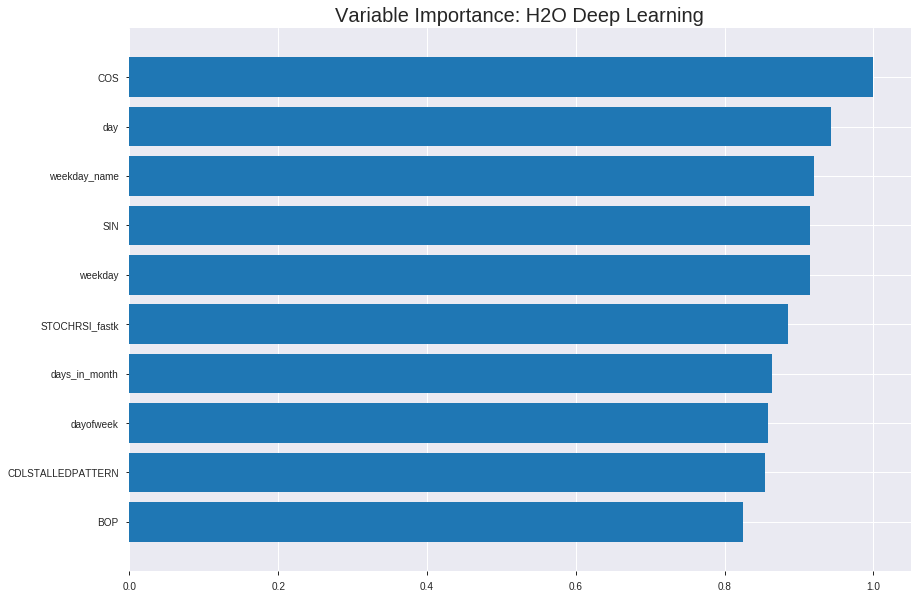

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_115740_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26698442675228856
RMSE: 0.5167053577739334
LogLoss: 0.7345828796958263
Mean Per-Class Error: 0.4664760028037507
AUC: 0.5343023025141179
pr_auc: 0.554407323668345
Gini: 0.06860460502823584
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3978423464823986: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      16   814   0.9807   (814.0/830.0)
1      2    909   0.0022   (2.0/911.0)
Total  18   1723  0.4687   (816.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.397842     0.690205  386
max f2                       0.397842     0.846842  386
max f0point5                 0.469175     0.585869  353
max accuracy                 0.568026     0.54394   270
max precision                0.914021     1         0
max recall                   0.324243     1         396
max specificity              0.914021     1         0
max absolute_mcc             0.469175     0.084526  353
max min_per_class_accuracy   0.638329     0.521405  199
max mean_per_class_accuracy  0.568026     0.533524  270

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 63.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.866262           1.59257   1.59257            0.833333         0.882899  0.833333                    0.882899            0.0164654       0.0164654                  59.2572   59.2572
    2        0.0201034                   0.85297            0.674501  1.14665            0.352941         0.859153  0.6                         0.871366            0.00658617      0.0230516                  -32.5499  14.6652
    3        0.0304423                   0.838924           1.59257   1.2981             0.833333         0.844615  0.679245                    0.86228             0.0164654       0.039517                   59.2572   29.8097
    4        0.0402068                   0.8282             0.786918  1.17395            0.411765         0.832982  0.614286                    0.855165            0.00768386      0.0472009                  -21.3082  17.3953
    5        0.0505457                   0.820909           1.27406   1.19443            0.666667         0.823829  0.625                       0.848755            0.0131723       0.0603732                  27.4058   19.4429
    6        0.100517                    0.782237           0.988493  1.09205            0.517241         0.797081  0.571429                    0.823066            0.0493963       0.109769                   -1.15069  9.20496
    7        0.150488                    0.758024           1.07636   1.08684            0.563218         0.766985  0.568702                    0.804444            0.053787        0.163557                   7.63592   8.68394
    8        0.20046                     0.736293           0.878661  1.03494            0.45977          0.745325  0.541547                    0.789706            0.0439078       0.207464                   -12.1339  3.49438
    9        0.300402                    0.703414           1.08734   1.05238            0.568966         0.720683  0.550669                    0.766743            0.108672        0.316136                   8.73424   5.23766
    10       0.400345                    0.670818           0.988493  1.03643            0.517241         0.68546   0.542324                    0.746451            0.0987925       0.414929                   -1.15069  3.64287
    11       0.500287                    0.637645           1.06538   1.04221            0.557471         0.654212  0.54535                     0.728025            0.106476        0.521405                   6.53759   4.22115
    12       0.60023                     0.607417           1.01046   1.03692            0.528736         0.621832  0.542584                    0.710343            0.100988        0.622393                   1.04596   3.69246
    13       0.700172                    0.576157           1.05439   1.03942            0.551724         0.592409  0.543888                    0.693509            0.105379        0.727772                   5.43927   3.9418
    14       0.800115                    0.543251           0.922594  1.02483            0.482759         0.559635  0.536253                    0.676787            0.0922064       0.819978                   -7.74064  2.48254
    15       0.900057                    0.495391           0.97751   1.01957            0.511494         0.519725  0.533504                    0.659347            0.0976948       0.917673                   -2.24901  1.95715
    16       1                           0.163155           0.823744  1                  0.431034         0.446995  0.523262                    0.638124          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.35426193114325194
RMSE: 0.5951990684999867
LogLoss: 6.093474885045053
Mean Per-Class Error: 0.4714463417392287
AUC: 0.5076735432383968
pr_auc: 0.5246582203214525
Gini: 0.015347086476793503
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.2044573389907401e-59: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    239  1        (239.0/239.0)
1      0    259  0        (0.0/259.0)
Total  0    498  0.4799   (239.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.20446e-59  0.68428    362
max f2                       1.20446e-59  0.844198   362
max f0point5                 1.20446e-59  0.5753     362
max accuracy                 0.424902     0.53012    268
max precision                0.735465     0.7        9
max recall                   1.20446e-59  1          362
max specificity              0.77921      0.995816   0
max absolute_mcc             0.767952     0.0810418  2
max min_per_class_accuracy   0.46841      0.518828   249
max mean_per_class_accuracy  0.424902     0.528554   268

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 34.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.761376           0.769112  0.769112           0.4              0.769785     0.4                         0.769785            0.00772201      0.00772201                 -23.0888   -23.0888
    2        0.0200803                   0.733694           1.92278   1.34595            1                0.744403     0.7                         0.757094            0.019305        0.027027                   92.278     34.5946
    3        0.0301205                   0.726866           0.769112  1.15367            0.4              0.73064      0.6                         0.748276            0.00772201      0.034749                   -23.0888   15.3668
    4        0.0401606                   0.718489           0.384556  0.96139            0.2              0.724248     0.5                         0.742269            0.003861        0.03861                    -61.5444   -3.861
    5        0.0502008                   0.714159           0.769112  0.922934           0.4              0.715849     0.48                        0.736985            0.00772201      0.046332                   -23.0888   -7.70656
    6        0.100402                    0.676147           1.30749   1.11521            0.68             0.691511     0.58                        0.714248            0.0656371       0.111969                   30.749     11.5212
    7        0.150602                    0.649112           0.769112  0.999846           0.4              0.663106     0.52                        0.697201            0.03861         0.150579                   -23.0888   -0.015444
    8        0.200803                    0.625894           0.846023  0.96139            0.44             0.639104     0.5                         0.682677            0.042471        0.19305                    -15.3977   -3.861
    9        0.301205                    0.584443           1.07676   0.999846           0.56             0.602226     0.52                        0.65586             0.108108        0.301158                   7.67568    -0.015444
    10       0.399598                    0.538318           0.94177   0.985545           0.489796         0.559856     0.512563                    0.632221            0.0926641       0.393822                   -5.82302   -1.44545
    11       0.5                         0.469896           1.23058   1.03475            0.64             0.50469      0.538153                    0.606612            0.123552        0.517375                   23.0579    3.4749
    12       0.600402                    0.269481           0.922934  1.01605            0.48             0.407511     0.528428                    0.573318            0.0926641       0.610039                   -7.70656   1.60509
    13       0.698795                    1.58014e-11        0.902529  1.00007            0.469388         0.0478767    0.520115                    0.499333            0.0888031       0.698842                   -9.74706   0.0066569
    14       1                           0                  0.999846  1                  0.52             4.58466e-14  0.52008                     0.348932            0.301158        1                          -0.015444  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 11:59:01  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 11:59:03  1 min 16.150 sec  325 obs/sec       0.276278  1             481        0.693883         10.4581             -0.930069      0.504924        0.369288           0.997089         0.476738                         0.713719           15.691                -1.04087         0.515711          0.3365               0.971727           0.471888
    2019-08-28 11:59:14  1 min 27.754 sec  370 obs/sec       2.55945   9             4456       0.538362         0.877115            -0.161849      0.577994        0.575608           1.06171          0.450316                         0.637235           7.48512               -0.626897        0.510557          0.526544             1.53822            0.47992
    2019-08-28 11:59:26  1 min 38.983 sec  376 obs/sec       4.80126   17            8359       0.540431         0.816877            -0.170799      0.534299        0.552542           1.06171          0.469271                         0.620469           6.83834               -0.542414        0.507754          0.511876             0.769112           0.47992
    2019-08-28 11:59:36  1 min 49.713 sec  382 obs/sec       7.01264   25            12209      0.541814         0.812874            -0.176795      0.526947        0.541058           1.38023          0.470994                         0.644702           7.03865               -0.665247        0.534386          0.56734              1.92278            0.47992
    2019-08-28 11:59:47  2 min  0.270 sec  390 obs/sec       9.31419   33            16216      0.525894         0.766329            -0.108656      0.526749        0.539026           0.955543         0.469845                         0.602639           6.30847               -0.455041        0.510694          0.519941             0.769112           0.47992
    2019-08-28 11:59:58  2 min 11.313 sec  399 obs/sec       11.8156   42            20571      0.516705         0.734583            -0.0702544     0.534302        0.554407           1.59257          0.468696                         0.595199           6.09347               -0.419337        0.507674          0.524658             0.769112           0.47992
    2019-08-28 12:00:09  2 min 22.607 sec  405 obs/sec       14.3607   51            25002      0.59043          1.03829             -0.397456      0.525195        0.553285           1.38023          0.47444                          0.67104            7.52258               -0.80409         0.530161          0.54272              1.15367            0.47992
    2019-08-28 12:00:21  2 min 34.234 sec  413 obs/sec       17.1557   61            29868      0.532352         0.783479            -0.136055      0.53345         0.560534           1.06171          0.471568                         0.634189           7.18618               -0.611379        0.53445           0.566001             1.92278            0.47992
    2019-08-28 12:00:32  2 min

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
COS                       1.0                    1.0                  0.001958750343627644
day                       0.943414568901062      0.943414568901062    0.001847913611018281
weekday_name              0.9197065830230713     0.9197065830230713   0.0018014755855330473
SIN                       0.9145603775978088     0.9145603775978088   0.001791395453887936
weekday                   0.9142318964004517     0.9142318964004517   0.0017907520412297373
---                       ---                    ---                  ---
BBANDS_middleband_14_5_4  0.40401941537857056    0.40401941537857056  0.000791373168705015
BBANDS_middleband_24_0_4  0.4035528600215912     0.4035528600215912   0.0007904593032392103
DEMA_12                   0.4029325246810913     0.4029325246810913   0.0007892442211778418
MA_14_2                   0.4018148183822632     0.4018148183822632   0.0007870549135809374
BBANDS_upperband_14_1_3   0.39317408204078674    0.39317408204078674  0.0007701298683028746


See the whole table with table.as_data_frame()


('accuracy', 0.5381526104417671)

('F1', 0.6997389033942559)

('auc', 0.5288773523685918)

('logloss', 18.00604807666843)

('mean_per_class_error', 0.4670343932511356)

('rmse', 0.7334303109400699)

('mse', 0.5379200210056477)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


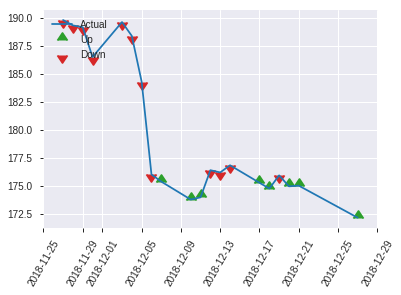


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5379200210056477
RMSE: 0.7334303109400699
LogLoss: 18.00604807666843
Mean Per-Class Error: 0.4670343932511356
AUC: 0.5288773523685918
pr_auc: 0.6958286496116923
Gini: 0.05775470473718358
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.139942345001714e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    134  0        (0.0/134.0)
Total  0    249  0.4618   (115.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       6.13994e-49  0.699739   12
max f2                       6.13994e-49  0.853503   12
max f0point5                 6.13994e-49  0.59292    12
max accuracy                 6.13994e-49  0.538153   12
max precision                0.0184345    1          0
max recall                   6.13994e-49  1          12
max specificity              0.0184345    1          0
max absolute_mcc             3.00633e-34  0.159959   10
max min_per_class_accuracy   3.00633e-34  0.0746269  10
max mean_per_class_accuracy  3.00633e-34  0.532966   10

Gains/Lift Table: Avg response rate: 53.82 %, avg score:  0.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.00105729         1.85821   1.85821            1                0.00969852   1                           0.00969852          0.0223881       0.0223881                  85.8209   85.8209
    2        0.0200803                   2.97087e-08        0.929104  1.48657            0.5              3.5994e-05   0.8                         0.00583351          0.00746269      0.0298507                  -7.08955  48.6567
    3        0.0321285                   8.17453e-14        1.85821   1.62593            1                2.94951e-09  0.875                       0.00364594          0.0223881       0.0522388                  85.8209   62.5933
    4        0.0401606                   2.01722e-29        1.85821   1.67239            1                3.94172e-20  0.9                         0.00291676          0.0149254       0.0671642                  85.8209   67.2388
    5        0.0522088                   8.73088e-47        0.619403  1.42939            0.333333         1.01111e-34  0.769231                    0.00224366          0.00746269      0.0746269                  -38.0597  42.9392
    6        1                           0                  0.976347  1                  0.525424         2.52264e-53  0.538153                    0.000117139         0.925373        1                          -2.36529  0

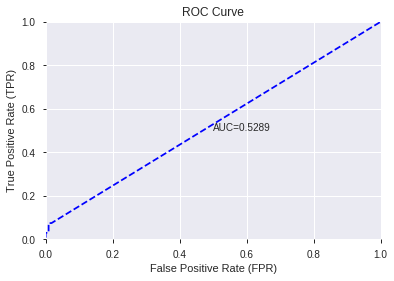

This function is available for GLM models only


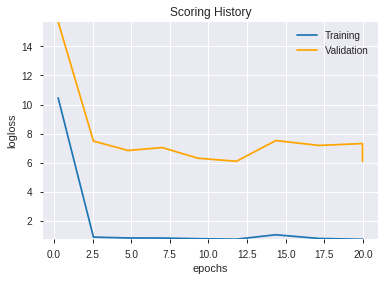

--2019-08-28 12:26:28--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.21.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.21.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  27.6MB/s    in 13s     

2019-08-28 12:26:41 (26.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_115740_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_115740_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_122654_model_5  0.528877  18.065120                   0.5  0.733469  0.537977
1  DeepLearning_grid_1_AutoML_20190828_122654_model_6  0.524854  17.946322                   0.5  0.733210  0.537598
2  DeepLearning_grid_1_AutoML_20190828_122654_model_7  0.520831  17.819878                   0.5  0.732565  0.536652
3  DeepLearning_grid_1_AutoML_20190828_122654_model_4  0.503731  18.587133                   0.5  0.733589  0.538153
4  DeepLearning_grid_1_AutoML_20190828_122654_model_3  0.500000  18.587133                   0.5  0.733589  0.538153
5               DeepLearning_1_AutoML_20190828_122654  0.500000  15.951644                   0.5  0.679594  0.461847
6  DeepLearning_grid_1_AutoML_20190828_122654_model_2  0.500000  18.587133                   0.5  0.733589  0.538153
7  DeepLearning_grid_1_AutoML_20190828_122654_model_9  0.500000   0.690235                   0.5  0.498543  0.248545
8  DeepLearning_grid_1_AutoML_20190828_122654_model_1  0.500000  15.951644                   0.5  0.679594  0.461847
9  DeepLearning_grid_1_AutoML_20190828_122654_model_8  0.495847  17.142109                   0.5  0.721768  0.520949

variable  relative_importance  scaled_importance  percentage
0         aroondown_14             1.000000           1.000000    0.021950
1                month             0.981505           0.981505    0.021544
2            CDLONNECK             0.977176           0.977176    0.021449
3      CDLUNIQUE3RIVER             0.970040           0.970040    0.021292
4          CDLPIERCING             0.965065           0.965065    0.021183
5                  day             0.964640           0.964640    0.021174
6              BETA_24             0.950917           0.950917    0.020873
7        CDLHIKKAKEMOD             0.950456           0.950456    0.020863
8                  SIN             0.948089           0.948089    0.020811
9               SAREXT             0.947775           0.947775    0.020804
10                DX_8             0.938276           0.938276    0.020595
11             CDLDOJI             0.936860           0.936860    0.020564
12   CDLLONGLEGGEDDOJI             0.934716           0.934716    0.020517
13      CDLRICKSHAWMAN             0.933637           0.933637    0.020493
14   CDLSTALLEDPATTERN             0.924208           0.924208    0.020286
15                COSH             0.923459           0.923459    0.020270
16         aroondown_8             0.923443           0.923443    0.020270
17             ADXR_12             0.922337           0.922337    0.020245
18      STOCHRSI_fastk             0.921413           0.921413    0.020225
19                 EXP             0.919470           0.919470    0.020182
20       days_in_month             0.916053           0.916053    0.020107
21                 BOP             0.915603           0.915603    0.020097
22          aroonup_12             0.913705           0.913705    0.020056
23        aroondown_12             0.913051           0.913051    0.020041
24        weekday_name             0.912687           0.912687    0.020033
25  CDLMORNINGDOJISTAR             0.908455           0.908455    0.019941
26      STOCHRSI_fastd             0.908376           0.908376    0.019939
27             weekday             0.907314           0.907314    0.019916
28           dayofyear             0.906486           0.906486    0.019897
29               DX_12             0.905138           0.905138    0.019868
30    CDLSTICKSANDWICH             0.903265           0.903265    0.019827
31    CDLDRAGONFLYDOJI             0.899866           0.899866    0.019752
32           aroonup_8             0.899555           0.899555    0.019745
33          aroonup_30             0.896978           0.896978    0.019689
34          aroonup_14             0.896470           0.896470    0.019678
35             BETA_12             0.896114           0.896114    0.019670
36         HT_DCPERIOD             0.895259           0.895259    0.019651
37           dayofweek             0.886923           0.886923    0.019468
38        HT_TRENDMODE             0.884820           0.884820    0.019422
39              ADX_24             0.880267           0.880267    0.019322
40          weekofyear             0.872045           0.872045    0.019141
41                SINH             0.869968           0.869968    0.019096
42             quarter             0.869803           0.869803    0.019092
43              BETA_8             0.868738           0.868738    0.019069
44        aroondown_30             0.859394           0.859394    0.018864
45                week             0.859039           0.859039    0.018856
46                 COS             0.852213           0.852213    0.018706
47         AROONOSC_30             0.846367           0.846367    0.018578
48        STOCHF_fastk             0.843902           0.843902    0.018524
49           CDL2CROWS             0.836751           0.836751    0.018367

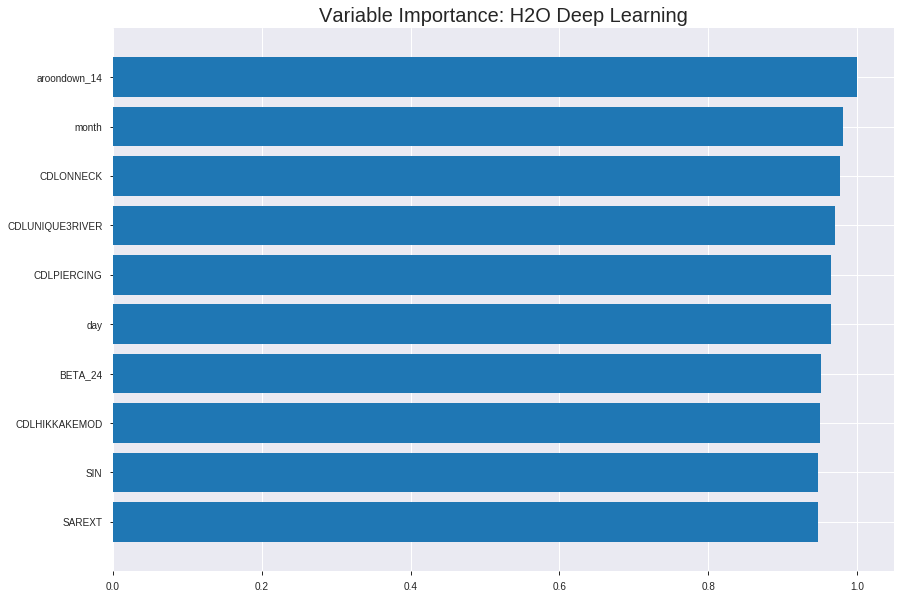

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_122654_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25699397571584837
RMSE: 0.5069457325156691
LogLoss: 0.7084674068569465
Mean Per-Class Error: 0.4550831206274053
AUC: 0.5415980056339519
pr_auc: 0.5468523039505087
Gini: 0.08319601126790377
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4918108385569: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      19   811   0.9771   (811.0/830.0)
1      2    909   0.0022   (2.0/911.0)
Total  21   1720  0.467    (813.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.491811     0.690992   381
max f2                       0.491811     0.847315   381
max f0point5                 0.549655     0.585999   315
max accuracy                 0.591471     0.552556   249
max precision                0.773009     0.75       2
max recall                   0.46133      1          392
max specificity              0.791696     0.998795   0
max absolute_mcc             0.591471     0.0951526  249
max min_per_class_accuracy   0.617459     0.528916   200
max mean_per_class_accuracy  0.591471     0.544917   249

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 61.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.741738           0.7432    0.7432             0.388889         0.754405  0.388889                    0.754405            0.00768386      0.00768386                 -25.68    -25.68
    2        0.0201034                   0.729083           1.349     1.03745            0.705882         0.734885  0.542857                    0.744924            0.0131723       0.0208562                  34.9002   3.74471
    3        0.0304423                   0.722482           0.7432    0.937514           0.388889         0.725566  0.490566                    0.73835             0.00768386      0.0285401                  -25.68    -6.24858
    4        0.0402068                   0.711311           1.349     1.03745            0.705882         0.71627   0.542857                    0.732987            0.0131723       0.0417124                  34.9002   3.74471
    5        0.0505457                   0.7068             1.27406   1.08584            0.666667         0.708933  0.568182                    0.728067            0.0131723       0.0548847                  27.4058   8.58447
    6        0.100517                    0.691654           1.12029   1.10297            0.586207         0.698582  0.577143                    0.713409            0.0559824       0.110867                   12.0292   10.297
    7        0.150488                    0.678719           0.900627  1.03578            0.471264         0.684718  0.541985                    0.703882            0.0450055       0.155873                   -9.93729  3.57798
    8        0.20046                     0.667599           1.07636   1.0459             0.563218         0.672951  0.547278                    0.696171            0.053787        0.20966                    7.63592   4.58956
    9        0.300402                    0.64897            1.04341   1.04507            0.545977         0.658125  0.546845                    0.683513            0.104281        0.313941                   4.34094   4.50685
    10       0.400345                    0.633677           1.05439   1.0474             0.551724         0.641166  0.548063                    0.672942            0.105379        0.419319                   5.43927   4.73962
    11       0.500287                    0.617384           1.09833   1.05757            0.574713         0.625275  0.553387                    0.663419            0.109769        0.529089                   9.83257   5.75704
    12       0.60023                     0.600532           1.08734   1.06253            0.568966         0.609081  0.555981                    0.654372            0.108672        0.637761                   8.73424   6.25276
    13       0.700172                    0.585193           0.97751   1.05039            0.511494         0.593306  0.549631                    0.645655            0.0976948       0.735456                   -2.24901  5.03922
    14       0.800115                    0.567069           0.900627  1.03169            0.471264         0.576444  0.539842                    0.63701             0.090011        0.825467                   -9.93729  3.1685
    15       0.900057                    0.537353           0.94456   1.02201            0.494253         0.554148  0.53478                     0.627809            0.0944018       0.919868                   -5.54399  2.20106
    16       1                           0.291997           0.801778  1                  0.41954          0.511371  0.523262                    0.616172           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3495236516829795
RMSE: 0.5912052534297877
LogLoss: 6.106093537587463
Mean Per-Class Error: 0.4636920243614804
AUC: 0.524046461284955
pr_auc: 0.5576220342447141
Gini: 0.048092922569910046
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.549181461791252e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    239  1        (239.0/239.0)
1      0    259  0        (0.0/259.0)
Total  0    498  0.4799   (239.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.54918e-48  0.68428   360
max f2                       1.54918e-48  0.844198  360
max f0point5                 1.54918e-48  0.5753    360
max accuracy                 0.604987     0.53012   172
max precision                0.744674     1         0
max recall                   1.54918e-48  1         360
max specificity              0.744674     1         0
max absolute_mcc             0.730419     0.096741  4
max min_per_class_accuracy   0.547441     0.506276  249
max mean_per_class_accuracy  0.604987     0.536308  172

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 37.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.729381           1.92278   1.92278            1                0.739912     1                           0.739912            0.019305        0.019305                   92.278     92.278
    2        0.0200803                   0.721279           0.769112  1.34595            0.4              0.72503      0.7                         0.732471            0.00772201      0.027027                   -23.0888   34.5946
    3        0.0301205                   0.716143           1.15367   1.28185            0.6              0.718701     0.666667                    0.727881            0.011583        0.03861                    15.3668    28.1853
    4        0.0401606                   0.705546           1.53822   1.34595            0.8              0.711169     0.7                         0.723703            0.015444        0.0540541                  53.8224    34.5946
    5        0.0502008                   0.699523           0.769112  1.23058            0.4              0.702445     0.64                        0.719451            0.00772201      0.0617761                  -23.0888   23.0579
    6        0.100402                    0.674633           1.15367   1.19212            0.6              0.687977     0.62                        0.703714            0.0579151       0.119691                   15.3668    19.2124
    7        0.150602                    0.662435           1.15367   1.17931            0.6              0.668472     0.613333                    0.691967            0.0579151       0.177606                   15.3668    17.9305
    8        0.200803                    0.649766           0.999846  1.13444            0.52             0.655556     0.59                        0.682864            0.0501931       0.227799                   -0.015444  13.444
    9        0.301205                    0.619054           0.922934  1.06394            0.48             0.635938     0.553333                    0.667222            0.0926641       0.320463                   -7.70656   6.39382
    10       0.399598                    0.593276           1.09873   1.07251            0.571429         0.604023     0.557789                    0.651661            0.108108        0.428571                   9.87314    7.25054
    11       0.5                         0.547729           0.769112  1.01158            0.4              0.567467     0.526104                    0.634754            0.0772201       0.505792                   -23.0888   1.1583
    12       0.600402                    0.355141           1.11521   1.02891            0.58             0.493677     0.535117                    0.611163            0.111969        0.617761                   11.5212    2.89123
    13       0.698795                    5.07376e-13        0.824049  1.00007            0.428571         0.0877375    0.520115                    0.537462            0.0810811       0.698842                   -17.5951   0.0066569
    14       1                           0                  0.999846  1                  0.52             2.64203e-16  0.52008                     0.375576            0.301158        1                          -0.015444  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:29:39  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:29:40  1 min  7.162 sec  1190 obs/sec      0.973004  1             1694       0.506946         0.708467            -0.0302059     0.541598        0.546852           0.7432           0.466973                         0.591205           6.10609               -0.400353        0.524046          0.557622             1.92278            0.47992
    2019-08-28 12:29:47  1 min 13.582 sec  2348 obs/sec      9.76278   10            16997      0.485938         0.663359            0.0534064      0.649335        0.681095           1.80492          0.425043                         0.604377           7.37029               -0.463449        0.519669          0.524615             0.769112           0.47992
    2019-08-28 12:29:53  1 min 19.976 sec  2732 obs/sec      20.4917   21            35676      0.466087         0.621342            0.129167       0.719263        0.752101           1.91109          0.390006                         0.607542           7.629                 -0.478814        0.517229          0.531035             1.15367            0.47992
    2019-08-28 12:29:59  1 min 26.181 sec  2905 obs/sec      31.2217   32            54357      0.443827         0.572941            0.210363       0.776564        0.806438           1.91109          0.322803                         0.607777           7.73064               -0.479956        0.534054          0.549284             1.15367            0.47992
    2019-08-28 12:30:05  1 min 32.186 sec  3024 obs/sec      41.9563   43            73046      0.418714         0.521863            0.297194       0.845455        0.860723           1.91109          0.271109                         0.617537           7.62387               -0.52787         0.51584           0.530905             1.53822            0.47992
    2019-08-28 12:30:11  1 min 38.255 sec  3093 obs/sec      52.7013   54            91753      0.400479         0.485973            0.357074       0.876971        0.887305           1.91109          0.232051                         0.614669           7.77338               -0.513712        0.52592           0.546063             1.15367            0.47992
    2019-08-28 12:30:12  1 min 38.847 sec  3090 obs/sec      52.7013   54            91753      0.506946         0.708467            -0.0302059     0.541598        0.546852           0.7432           0.466973                         0.591205           6.10609               -0.400353        0.524046          0.557622             1.92278            0.47992

Variable Importances: 


variable         relative_importance    scaled_importance    percentage
---------------  ---------------------  -------------------  --------------------
aroondown_14     1.0                    1.0                  0.021949999792369307
month            0.9815053939819336     0.9815053939819336   0.021544043194112798
CDLONNECK        0.977176308631897      0.977176308631897    0.021449019771578346
CDLUNIQUE3RIVER  0.9700396060943604     0.9700396060943604   0.021292369152361216
CDLPIERCING      0.9650647640228271     0.9650647640228271   0.02118317136992399
---              ---                    ---                  ---
week             0.859039306640625      0.859039306640625    0.018855912602398793
COS              0.8522132635116577     0.8522132635116577   0.018706080957135256
AROONOSC_30      0.8463671803474426     0.8463671803474426   0.018577759432894563
STOCHF_fastk     0.8439015746116638     0.8439015746116638   0.018523639387506154
CDL2CROWS        0.8367514610290527     0.8367514610290527   0.018366694395852423


See the whole table with table.as_data_frame()


('accuracy', 0.5381526104417671)

('F1', 0.6997389033942559)

('auc', 0.5288773523685918)

('logloss', 18.06511966755772)

('mean_per_class_error', 0.4670343932511356)

('rmse', 0.7334688631796682)

('mse', 0.5379765732540748)

deeplearning prediction progress: |███████████████████████████████████████| 100%


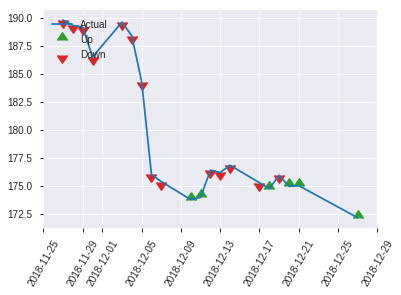


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5379765732540748
RMSE: 0.7334688631796682
LogLoss: 18.06511966755772
Mean Per-Class Error: 0.4670343932511356
AUC: 0.5288773523685918
pr_auc: 0.6958286496116923
Gini: 0.05775470473718358
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.4791671748131254e-60: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    134  0        (0.0/134.0)
Total  0    249  0.4618   (115.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.47917e-60  0.699739   12
max f2                       1.47917e-60  0.853503   12
max f0point5                 1.47917e-60  0.59292    12
max accuracy                 1.47917e-60  0.538153   12
max precision                0.0145588    1          0
max recall                   1.47917e-60  1          12
max specificity              0.0145588    1          0
max absolute_mcc             1.88824e-42  0.159959   10
max min_per_class_accuracy   1.88824e-42  0.0746269  10
max mean_per_class_accuracy  1.88824e-42  0.532966   10

Gains/Lift Table: Avg response rate: 53.82 %, avg score:  0.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.00136824         1.85821   1.85821            1                0.00733263   1                           0.00733263          0.0223881       0.0223881                  85.8209   85.8209
    2        0.0200803                   1.86557e-09        0.929104  1.48657            0.5              1.99358e-05  0.8                         0.00440755          0.00746269      0.0298507                  -7.08955  48.6567
    3        0.0321285                   1.12816e-16        1.85821   1.62593            1                9.36989e-11  0.875                       0.00275472          0.0223881       0.0522388                  85.8209   62.5933
    4        0.0401606                   5.33028e-36        1.85821   1.67239            1                1.99159e-24  0.9                         0.00220378          0.0149254       0.0671642                  85.8209   67.2388
    5        0.0522088                   2.10338e-58        0.619403  1.42939            0.333333         6.311e-43    0.769231                    0.00169521          0.00746269      0.0746269                  -38.0597  42.9392
    6        1                           0                  0.976347  1                  0.525424         1.39801e-66  0.538153                    8.8505e-05          0.925373        1                          -2.36529  0

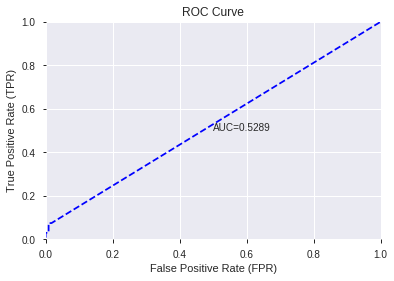

This function is available for GLM models only


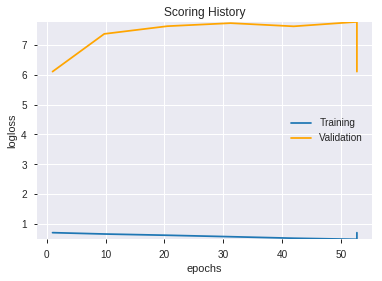

--2019-08-28 12:34:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_122654_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_122654_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['aroondown_14',
 'month',
 'CDLONNECK',
 'CDLUNIQUE3RIVER',
 'CDLPIERCING',
 'day',
 'BETA_24',
 'CDLHIKKAKEMOD',
 'SIN',
 'SAREXT',
 'DX_8',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLRICKSHAWMAN',
 'CDLSTALLEDPATTERN',
 'COSH',
 'aroondown_8',
 'ADXR_12',
 'STOCHRSI_fastk',
 'EXP',
 'days_in_month',
 'BOP',
 'aroonup_12',
 'aroondown_12',
 'weekday_name',
 'CDLMORNINGDOJISTAR',
 'STOCHRSI_fastd',
 'weekday',
 'dayofyear',
 'DX_12',
 'CDLSTICKSANDWICH',
 'CDLDRAGONFLYDOJI',
 'aroonup_8',
 'aroonup_30',
 'aroonup_14',
 'BETA_12',
 'HT_DCPERIOD',
 'dayofweek',
 'HT_TRENDMODE',
 'ADX_24',
 'weekofyear',
 'SINH',
 'quarter',
 'BETA_8',
 'aroondown_30',
 'week',
 'COS',
 'AROONOSC_30',
 'STOCHF_fastk',
 'CDL2CROWS']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_123417_model_1  0.525503  18.160138                   0.5  0.733565  0.538118

variable  relative_importance  scaled_importance  percentage
0                 COSH             0.007770           1.000000    0.050379
1                  EXP             0.007767           0.999599    0.050359
2                 SINH             0.007764           0.999262    0.050342
3   CDLMORNINGDOJISTAR             0.007250           0.933140    0.047011
4            CDLONNECK             0.006131           0.789100    0.039754
5              BETA_12             0.006070           0.781224    0.039357
6     CDLSTICKSANDWICH             0.006001           0.772373    0.038911
7        days_in_month             0.005764           0.741889    0.037376
8               BETA_8             0.005381           0.692554    0.034890
9     CDLDRAGONFLYDOJI             0.004439           0.571330    0.028783
10   CDLSTALLEDPATTERN             0.003973           0.511381    0.025763
11         aroondown_8             0.003962           0.509969    0.025692
12         CDLPIERCING             0.003934           0.506277    0.025506
13           CDL2CROWS             0.003897           0.501533    0.025267
14             BETA_24             0.003822           0.491943    0.024784
15          aroonup_12             0.003705           0.476887    0.024025
16        aroondown_30             0.003648           0.469492    0.023653
17               DX_12             0.003552           0.457190    0.023033
18              ADX_24             0.003355           0.431822    0.021755
19        weekday_name             0.003316           0.426748    0.021499
20             ADXR_12             0.003273           0.421251    0.021222
21                DX_8             0.003064           0.394399    0.019869
22         AROONOSC_30             0.003045           0.391950    0.019746
23           dayofweek             0.002988           0.384596    0.019376
24             weekday             0.002984           0.383995    0.019345
25           aroonup_8             0.002945           0.379008    0.019094
26                 COS             0.002885           0.371289    0.018705
27          aroonup_14             0.002854           0.367332    0.018506
28      STOCHRSI_fastd             0.002657           0.341929    0.017226
29                 SIN             0.002655           0.341673    0.017213
30      STOCHRSI_fastk             0.002222           0.286002    0.014408
31        aroondown_12             0.002186           0.281327    0.014173
32        aroondown_14             0.001855           0.238690    0.012025
33   CDLLONGLEGGEDDOJI             0.001797           0.231336    0.011654
34          aroonup_30             0.001716           0.220921    0.011130
35       CDLHIKKAKEMOD             0.001608           0.207012    0.010429
36             CDLDOJI             0.001478           0.190214    0.009583
37             quarter             0.001392           0.179161    0.009026
38        STOCHF_fastk             0.001345           0.173092    0.008720
39               month             0.001315           0.169191    0.008524
40                 BOP             0.001211           0.155822    0.007850
41           dayofyear             0.001186           0.152688    0.007692
42      CDLRICKSHAWMAN             0.001124           0.144721    0.007291
43         HT_DCPERIOD             0.000927           0.119358    0.006013
44                 day             0.000730           0.093931    0.004732
45              SAREXT             0.000575           0.074014    0.003729
46        HT_TRENDMODE             0.000259           0.033395    0.001682
47     CDLUNIQUE3RIVER             0.000197           0.025292    0.001274
48          weekofyear             0.000126           0.016277    0.000820
49                week             0.000124           0.015986    0.000805

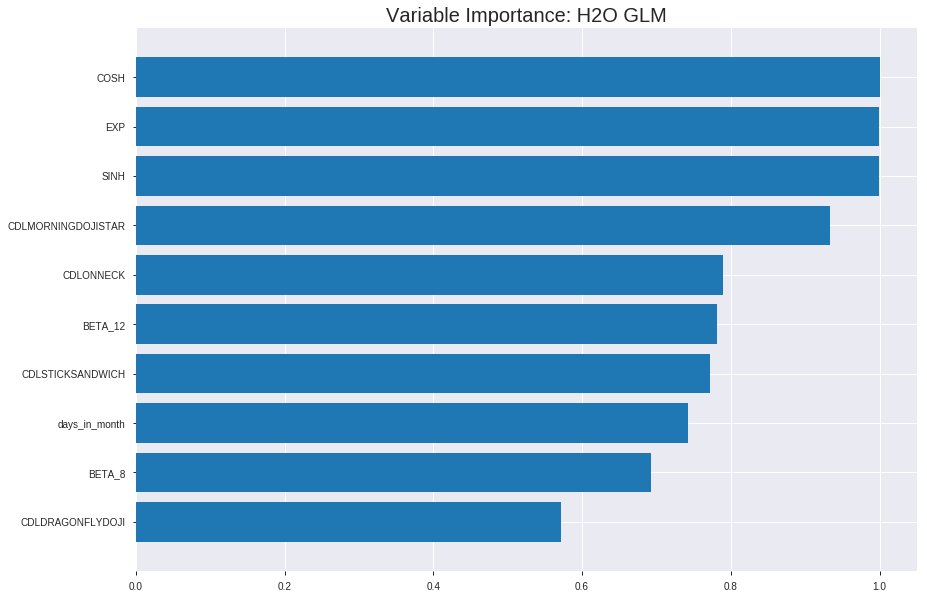

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_123417_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.248473012692644
RMSE: 0.4984706738541837
LogLoss: 0.6900821468819709
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2409.7685981527216
Residual deviance: 2402.866035443023
AIC: 2504.866035443023
AUC: 0.5472319574676312
pr_auc: 0.5688146945473908
Gini: 0.0944639149352624
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.503769808887687: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      24   806   0.9711   (806.0/830.0)
1      1    910   0.0011   (1.0/911.0)
Total  25   1716  0.4635   (807.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50377      0.692805  375
max f2                       0.50377      0.848881  375
max f0point5                 0.513291     0.586988  337
max accuracy                 0.518718     0.545663  274
max precision                0.571272     1         0
max recall                   0.491617     1         388
max specificity              0.571272     1         0
max absolute_mcc             0.50377      0.116787  375
max min_per_class_accuracy   0.523602     0.535675  191
max mean_per_class_accuracy  0.523481     0.539698  193

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 52.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.541112           1.38023   1.38023            0.722222         0.54781   0.722222                    0.54781             0.01427         0.01427                    38.0229   38.0229
    2        0.0201034                   0.537144           1.12417   1.25586            0.588235         0.538166  0.657143                    0.543126            0.0109769       0.025247                   12.4169   25.5857
    3        0.0304423                   0.535783           1.4864    1.33415            0.777778         0.536439  0.698113                    0.540855            0.0153677       0.0406147                  48.6401   33.4155
    4        0.0402068                   0.534898           0.786918  1.20125            0.411765         0.535267  0.628571                    0.539498            0.00768386      0.0482986                  -21.3082  20.1255
    5        0.0505457                   0.534216           1.38023   1.23786            0.722222         0.534528  0.647727                    0.538481            0.01427         0.0625686                  38.0229   23.7863
    6        0.100517                    0.531762           1.12029   1.17941            0.586207         0.532852  0.617143                    0.535683            0.0559824       0.118551                   12.0292   17.9414
    7        0.150488                    0.529962           1.12029   1.15978            0.586207         0.530852  0.60687                     0.534078            0.0559824       0.174533                   12.0292   15.9782
    8        0.20046                     0.528515           0.988493  1.11708            0.517241         0.529311  0.584527                    0.53289             0.0493963       0.22393                    -1.15069  11.7082
    9        0.300402                    0.526575           0.955543  1.06334            0.5              0.527523  0.556405                    0.531104            0.0954995       0.319429                   -4.44566  6.33389
    10       0.400345                    0.524937           1.07636   1.06659            0.563218         0.525699  0.558106                    0.529755            0.107574        0.427003                   7.63592   6.65893
    11       0.500287                    0.523591           1.07636   1.06854            0.563218         0.524254  0.559127                    0.528656            0.107574        0.534577                   7.63592   6.8541
    12       0.60023                     0.522048           0.889644  1.03875            0.465517         0.52279   0.543541                    0.527679            0.0889133       0.623491                   -11.0356  3.87534
    13       0.700172                    0.520545           0.966527  1.02844            0.505747         0.521263  0.538146                    0.526763            0.0965971       0.720088                   -3.34734  2.84437
    14       0.800115                    0.518573           1.08734   1.0358             0.568966         0.519612  0.541996                    0.52587             0.108672        0.82876                    8.73424   3.58008
    15       0.900057                    0.516036           0.91161   1.02201            0.477011         0.517365  0.53478                     0.524926            0.0911087       0.919868                   -8.83897  2.20106
    16       1                           0.347135           0.801778  1                  0.41954          0.508284  0.523262                    0.523262          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.34661210180079927
RMSE: 0.5887377190233349
LogLoss: 6.204915992375046
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 689.5913742505304
Residual deviance: 100244.67470665771
AIC: 100346.67470665771
AUC: 0.5181580265262273
pr_auc: 0.546110622639702
Gini: 0.036316053052454667
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.2177161944551487e-53: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    239  1        (239.0/239.0)
1      0    259  0        (0.0/259.0)
Total  0    498  0.4799   (239.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.21772e-53  0.68428   357
max f2                       2.21772e-53  0.844198  357
max f0point5                 2.21772e-53  0.5753    357
max accuracy                 0.51984      0.526104  237
max precision                0.572923     1         0
max recall                   2.21772e-53  1         357
max specificity              0.572923     1         0
max absolute_mcc             0.539016     0.096741  4
max min_per_class_accuracy   0.518611     0.518828  248
max mean_per_class_accuracy  0.525162     0.53084   164

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 31.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.538602           1.92278   1.92278            1                0.548835     1                           0.548835            0.019305        0.019305                   92.278     92.278
    2        0.0200803                   0.53663            0.384556  1.15367            0.2              0.537845     0.6                         0.54334             0.003861        0.023166                   -61.5444   15.3668
    3        0.0301205                   0.535559           1.53822   1.28185            0.8              0.536221     0.666667                    0.540967            0.015444        0.03861                    53.8224    28.1853
    4        0.0401606                   0.534211           1.15367   1.24981            0.6              0.534745     0.65                        0.539412            0.011583        0.0501931                  15.3668    24.9807
    5        0.0502008                   0.533795           0.769112  1.15367            0.4              0.534025     0.6                         0.538334            0.00772201      0.0579151                  -23.0888   15.3668
    6        0.100402                    0.531775           1.15367   1.15367            0.6              0.532632     0.6                         0.535483            0.0579151       0.11583                    15.3668    15.3668
    7        0.150602                    0.530116           0.769112  1.02548            0.4              0.53099      0.533333                    0.533986            0.03861         0.15444                    -23.0888   2.54826
    8        0.200803                    0.528755           0.922934  0.999846           0.48             0.529499     0.52                        0.532864            0.046332        0.200772                   -7.70656   -0.015444
    9        0.301205                    0.525875           1.19212   1.06394            0.62             0.527241     0.553333                    0.53099             0.119691        0.320463                   19.2124    6.39382
    10       0.399598                    0.522969           1.02025   1.05318            0.530612         0.52454      0.547739                    0.529402            0.100386        0.420849                   2.02506    5.3181
    11       0.5                         0.518819           0.96139   1.03475            0.5              0.521108     0.538153                    0.527736            0.0965251       0.517375                   -3.861     3.4749
    12       0.600402                    0.330917           0.999846  1.02891            0.52             0.487163     0.535117                    0.520951            0.100386        0.617761                   -0.015444  2.89123
    13       0.698795                    1.06562e-17        0.824049  1.00007            0.428571         0.0664643    0.520115                    0.456957            0.0810811       0.698842                   -17.5951   0.0066569
    14       1                           0                  0.999846  1                  0.52             4.58575e-22  0.52008                     0.31932             0.301158        1                          -0.015444  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 12:34:17  0.000 sec   2            2.6       51            1.38016           201.295
    2019-08-28 12:34:18  0.035 sec   4            1.6       51            1.37851           204.707
    2019-08-28 12:34:18  0.069 sec   6            1         51            1.37651           208.144
    2019-08-28 12:34:18  0.106 sec   8            0.63      51            1.37424           211.006
    2019-08-28 12:34:18  0.145 sec   10           0.39      51            1.37189           214.013

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5381526104417671)

('F1', 0.6997389033942559)

('auc', 0.5255029201817002)

('logloss', 18.16013824191227)

('mean_per_class_error', 0.4744970798182998)

('rmse', 0.733565174309404)

('mse', 0.5381178649595864)

glm prediction progress: |████████████████████████████████████████████████| 100%


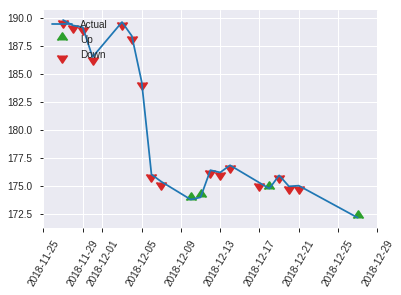


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5381178649595864
RMSE: 0.733565174309404
LogLoss: 18.16013824191227
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 343.95763235704146
Residual deviance: 175891.0355532173
AIC: 175993.0355532173
AUC: 0.5255029201817002
pr_auc: 0.7187577245727759
Gini: 0.05100584036340039
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.2057860615768994e-51: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    134  0        (0.0/134.0)
Total  0    249  0.4618   (115.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.20579e-51  0.699739   9
max f2                       1.20579e-51  0.853503   9
max f0point5                 1.20579e-51  0.59292    9
max accuracy                 1.20579e-51  0.538153   9
max precision                0.00336806   1          0
max recall                   1.20579e-51  1          9
max specificity              0.00336806   1          0
max absolute_mcc             6.69213e-34  0.136237   8
max min_per_class_accuracy   6.69213e-34  0.0597015  8
max mean_per_class_accuracy  6.69213e-34  0.525503   8

Gains/Lift Table: Avg response rate: 53.82 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.000138576        1.85821   1.85821            1                0.00144369   1                           0.00144369          0.0223881       0.0223881                  85.8209   85.8209
    2        0.0200803                   2.71404e-12        0.929104  1.48657            0.5              3.51576e-07  0.8                         0.000866353         0.00746269      0.0298507                  -7.08955  48.6567
    3        0.0321285                   3.3433e-23         1.85821   1.62593            1                1.13526e-14  0.875                       0.00054147          0.0223881       0.0522388                  85.8209   62.5933
    4        0.0401606                   2.31511e-50        1.85821   1.67239            1                3.34607e-34  0.9                         0.000433176         0.0149254       0.0671642                  85.8209   67.2388
    5        0.0522088                   1.32457e-82        0.619403  1.42939            0.333333         1.69627e-60  0.769231                    0.000333213         0.00746269      0.0746269                  -38.0597  42.9392
    6        1                           0                  0.976347  1                  0.525424         2.34266e-93  0.538153                    1.73966e-05         0.925373        1                          -2.36529  0

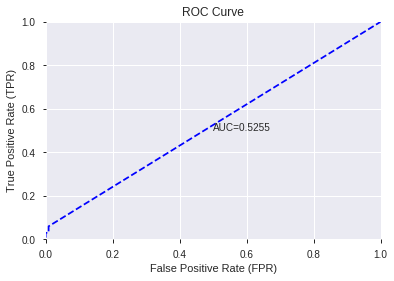

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


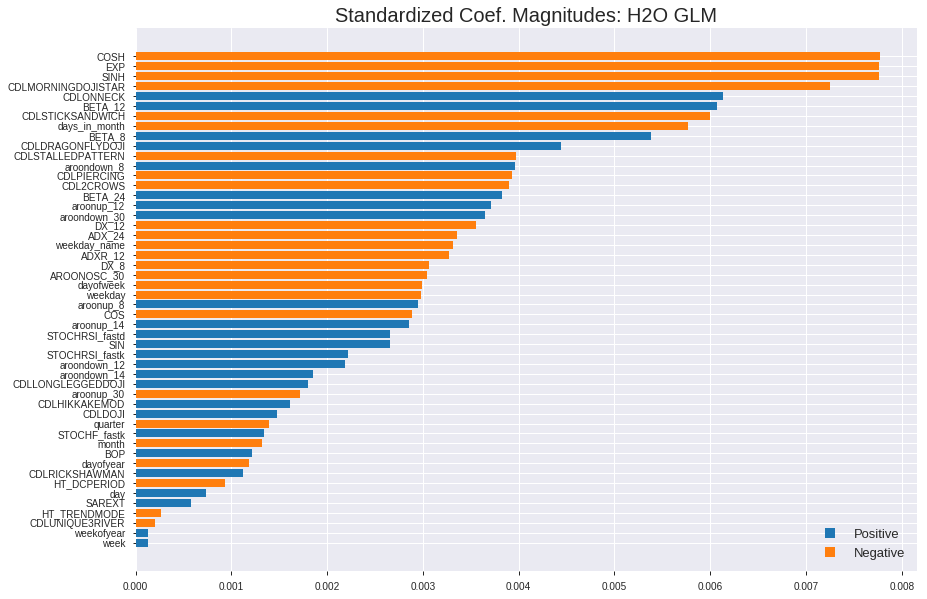

'log_likelihood'
--2019-08-28 12:34:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.0.88
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.0.88|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_123417_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_123417_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['COSH',
 'EXP',
 'SINH',
 'CDLMORNINGDOJISTAR',
 'CDLONNECK',
 'BETA_12',
 'CDLSTICKSANDWICH',
 'days_in_month',
 'BETA_8',
 'CDLDRAGONFLYDOJI',
 'CDLSTALLEDPATTERN',
 'aroondown_8',
 'CDLPIERCING',
 'CDL2CROWS',
 'BETA_24',
 'aroonup_12',
 'aroondown_30',
 'DX_12',
 'ADX_24',
 'weekday_name',
 'ADXR_12',
 'DX_8',
 'AROONOSC_30',
 'dayofweek',
 'weekday',
 'aroonup_8',
 'COS',
 'aroonup_14',
 'STOCHRSI_fastd',
 'SIN',
 'STOCHRSI_fastk',
 'aroondown_12',
 'aroondown_14',
 'CDLLONGLEGGEDDOJI',
 'aroonup_30',
 'CDLHIKKAKEMOD',
 'CDLDOJI',
 'quarter',
 'STOCHF_fastk',
 'month',
 'BOP',
 'dayofyear',
 'CDLRICKSHAWMAN',
 'HT_DCPERIOD',
 'day',
 'SAREXT',
 'HT_TRENDMODE',
 'CDLUNIQUE3RIVER',
 'weekofyear',
 'week']

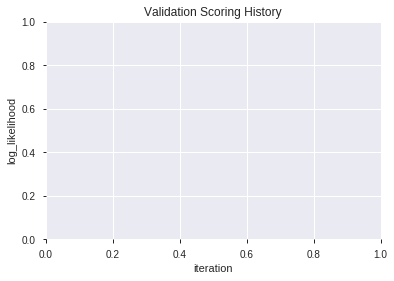

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_123434_model_1  0.578196  0.777163              0.476411  0.537963  0.289404
1  XGBoost_grid_1_AutoML_20190828_123434_model_6  0.567489  0.746292              0.500000  0.524361  0.274954
2  XGBoost_grid_1_AutoML_20190828_123434_model_2  0.548929  0.696104              0.445360  0.501486  0.251488
3  XGBoost_grid_1_AutoML_20190828_123434_model_4  0.547891  0.687105              0.495652  0.497014  0.247023
4               XGBoost_3_AutoML_20190828_123434  0.529072  0.756783              0.500000  0.529351  0.280213
5               XGBoost_2_AutoML_20190828_123434  0.519014  0.697184              0.477028  0.501946  0.251950
6  XGBoost_grid_1_AutoML_20190828_123434_model_7  0.515185  0.736723              0.500000  0.519959  0.270358
7  XGBoost_grid_1_AutoML_20190828_123434_model_5  0.510707  0.819527              0.477644  0.553443  0.306300
8               XGBoost_1_AutoML_20190828_123434  0.496431  0.734385              0.495652  0.519304  0.269676
9  XGBoost_grid_1_AutoML_20190828_123434_model_3  0.481895  0.758725              0.495652  0.530064  0.280968

variable  relative_importance  scaled_importance  percentage
0              BOP           246.741486           1.000000    0.085963
1      HT_DCPERIOD           219.968811           0.891495    0.076636
2   STOCHRSI_fastd           194.965897           0.790163    0.067925
3           ADX_24           185.086182           0.750122    0.064483
4     STOCHF_fastk           161.560791           0.654778    0.056287
5          ADXR_12           159.376953           0.645927    0.055526
6             COSH           156.859467           0.635724    0.054649
7             DX_8           149.526367           0.606004    0.052094
8              day           142.894897           0.579128    0.049784
9            DX_12           124.763451           0.505644    0.043467
10             SIN           121.778610           0.493547    0.042427
11         BETA_24           118.463966           0.480114    0.041272
12             COS            97.064308           0.393385    0.033817
13            week            90.942421           0.368574    0.031684
14       aroonup_8            88.492340           0.358644    0.030830
15         BETA_12            75.461792           0.305833    0.026290
16          SAREXT            71.142021           0.288326    0.024785
17          BETA_8            69.825920           0.282992    0.024327
18       dayofyear            57.168434           0.231694    0.019917
19     AROONOSC_30            45.963039           0.186280    0.016013
20  STOCHRSI_fastk            39.082092           0.158393    0.013616
21    aroondown_30            33.685223           0.136520    0.011736
22       dayofweek            29.807747           0.120806    0.010385
23    aroondown_14            26.105724           0.105802    0.009095
24     aroondown_8            24.910410           0.100958    0.008679
25      aroonup_30            20.710657           0.083937    0.007215
26   days_in_month            20.142773           0.081635    0.007018
27      aroonup_12            19.821033           0.080331    0.006906
28      weekofyear            17.726692           0.071843    0.006176
29      aroonup_14            16.850771           0.068293    0.005871
30             EXP            15.453434           0.062630    0.005384
31    weekday_name            15.316090           0.062073    0.005336
32    aroondown_12             8.748708           0.035457    0.003048
33           month             3.910926           0.015850    0.001363

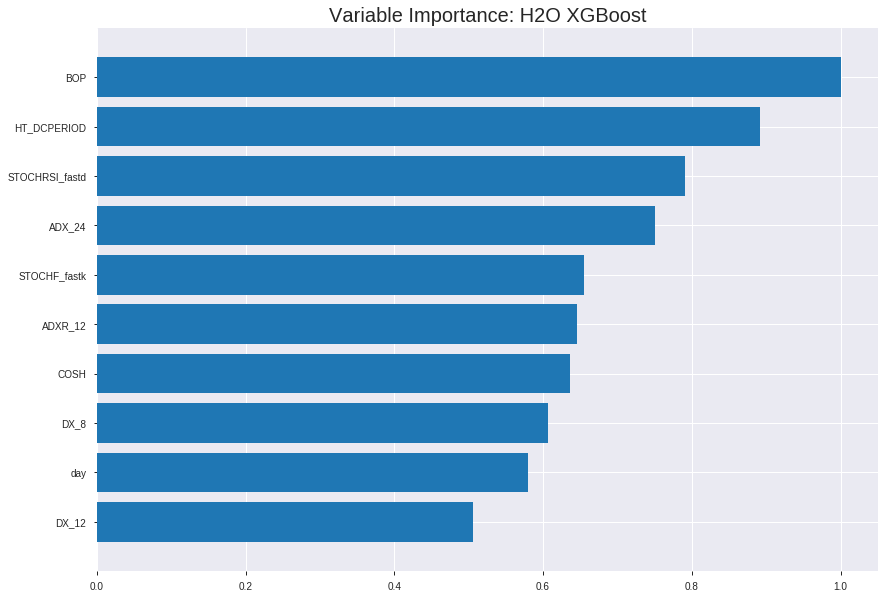

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_123434_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21021469481851202
RMSE: 0.45849176090581173
LogLoss: 0.6118194039370428
Mean Per-Class Error: 0.2335967360110034
AUC: 0.8507115178606853
pr_auc: 0.8598719407670058
Gini: 0.7014230357213707
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.499814011156559: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      526  304   0.3663   (304.0/830.0)
1      118  793   0.1295   (118.0/911.0)
Total  644  1097  0.2424   (422.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499814     0.789841  227
max f2                       0.465556     0.872477  276
max f0point5                 0.549821     0.805694  160
max accuracy                 0.526513     0.763929  191
max precision                0.79142      1         0
max recall                   0.300862     1         388
max specificity              0.79142      1         0
max absolute_mcc             0.539224     0.538797  175
max min_per_class_accuracy   0.522487     0.756312  197
max mean_per_class_accuracy  0.539224     0.766403  175

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 52.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0103389                   0.719465           1.91109   1.91109            1                0.749182  1                           0.749182            0.0197585       0.0197585                  91.1087     91.1087
    2        0.0201034                   0.689924           1.91109   1.91109            1                0.705485  1                           0.727958            0.0186608       0.0384193                  91.1087     91.1087
    3        0.0304423                   0.668678           1.91109   1.91109            1                0.680112  1                           0.711708            0.0197585       0.0581778                  91.1087     91.1087
    4        0.0402068                   0.655862           1.79867   1.88379            0.941176         0.66286   0.985714                    0.699845            0.0175631       0.0757409                  79.867      88.3785
    5        0.0505457                   0.646722           1.91109   1.88937            1                0.651177  0.988636                    0.68989             0.0197585       0.0954995                  91.1087     88.937
    6        0.100517                    0.61742            1.71339   1.80188            0.896552         0.630025  0.942857                    0.660129            0.0856202       0.18112                    71.3388     80.1882
    7        0.150488                    0.597237           1.71339   1.7725             0.896552         0.606369  0.927481                    0.642277            0.0856202       0.26674                    71.3388     77.2496
    8        0.20046                     0.581948           1.71339   1.75776            0.896552         0.590204  0.919771                    0.629296            0.0856202       0.35236                    71.3388     75.7762
    9        0.300402                    0.561149           1.65847   1.72473            0.867816         0.570674  0.902486                    0.609793            0.165752        0.518112                   65.8472     72.4728
    10       0.400345                    0.541917           1.32897   1.62593            0.695402         0.550704  0.850789                    0.595042            0.132821        0.650933                   32.8974     62.5932
    11       0.500287                    0.523658           0.999476  1.50078            0.522989         0.533393  0.785304                    0.582726            0.0998902       0.750823                   -0.0523613  50.0785
    12       0.60023                     0.505953           0.889644  1.39903            0.465517         0.51488   0.732057                    0.571429            0.0889133       0.839737                   -11.0356    39.9025
    13       0.700172                    0.485319           0.768828  1.30907            0.402299         0.495439  0.684988                    0.560582            0.0768386       0.916575                   -23.1172    30.9071
    14       0.800115                    0.460442           0.450314  1.2018             0.235632         0.472523  0.628859                    0.549583            0.0450055       0.961581                   -54.9686    20.1803
    15       0.900057                    0.423202           0.263598  1.09762            0.137931         0.443668  0.574346                    0.537822            0.0263447       0.987925                   -73.6402    9.76248
    16       1                           0.243839           0.120816  1                  0.0632184        0.373169  0.523262    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2721521384109559
RMSE: 0.521682028069739
LogLoss: 0.741046528195695
Mean Per-Class Error: 0.48386132695756123
AUC: 0.49198720537632673
pr_auc: 0.5142647787036283
Gini: -0.01602558924734654
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23387932777404785: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    236  0.9874   (236.0/239.0)
1      0    259  0        (0.0/259.0)
Total  3    495  0.4739   (236.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.233879     0.687003   396
max f2                       0.233879     0.845852   396
max f0point5                 0.233879     0.578383   396
max accuracy                 0.300273     0.526104   337
max precision                0.734651     1          0
max recall                   0.233879     1          396
max specificity              0.734651     1          0
max absolute_mcc             0.271524     0.0989778  375
max min_per_class_accuracy   0.450728     0.506276   201
max mean_per_class_accuracy  0.326022     0.516139   289

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 43.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.664541           1.15367   1.15367            0.6              0.701301  0.6                         0.701301            0.011583        0.011583                   15.3668    15.3668
    2        0.0200803                   0.635746           1.53822   1.34595            0.8              0.65332   0.7                         0.677311            0.015444        0.027027                   53.8224    34.5946
    3        0.0301205                   0.620693           0.769112  1.15367            0.4              0.628027  0.6                         0.660883            0.00772201      0.034749                   -23.0888   15.3668
    4        0.0401606                   0.61565            0.769112  1.05753            0.4              0.618524  0.55                        0.650293            0.00772201      0.042471                   -23.0888   5.7529
    5        0.0502008                   0.610197           0.384556  0.922934           0.2              0.613447  0.48                        0.642924            0.003861        0.046332                   -61.5444   -7.70656
    6        0.100402                    0.584741           0.999846  0.96139            0.52             0.599388  0.5                         0.621156            0.0501931       0.0965251                  -0.015444  -3.861
    7        0.150602                    0.564809           1.15367   1.02548            0.6              0.573997  0.533333                    0.605436            0.0579151       0.15444                    15.3668    2.54826
    8        0.200803                    0.554409           0.922934  0.999846           0.48             0.559832  0.52                        0.594035            0.046332        0.200772                   -7.70656   -0.015444
    9        0.301205                    0.528226           0.884479  0.96139            0.46             0.539651  0.5                         0.575907            0.0888031       0.289575                   -11.5521   -3.861
    10       0.399598                    0.496775           0.94177   0.956559           0.489796         0.512123  0.497487                    0.560202            0.0926641       0.382239                   -5.82302   -4.34411
    11       0.5                         0.452872           1.23058   1.01158            0.64             0.477192  0.526104                    0.543533            0.123552        0.505792                   23.0579    1.1583
    12       0.600402                    0.360617           0.922934  0.996759           0.48             0.404527  0.518395                    0.520288            0.0926641       0.598456                   -7.70656   -0.324118
    13       0.698795                    0.325921           1.17721   1.02217            0.612245         0.341998  0.531609                    0.495184            0.11583         0.714286                   17.7212    2.21675
    14       0.799197                    0.308048           0.769112  0.990377           0.4              0.317601  0.515075                    0.472874            0.0772201       0.791506                   -23.0888   -0.962341
    15       0.899598                    0.289062           1.0383    0.995725           0.54             0.299065  0.517857                    0.453476            0.104247        0.895753                   3.83012    -0.427468
    16       1                           0.231323           1.0383    1                  0.54             0.267002  0.52008               


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:34:42  0.025 sec   0                  0.5              0.693147            0.5             0                  1                0.476738                         0.5                0.693147              0.5               0                    1                  0.47992
    2019-08-28 12:34:42  0.161 sec   5                  0.494256         0.681695            0.656291        0.664116           1.69874          0.421022                         0.503122           0.699451              0.488433          0.507513             1.53822            0.47992
    2019-08-28 12:34:42  0.225 sec   10                 0.49143          0.67605             0.675755        0.685064           1.80492          0.422746                         0.508248           0.710164              0.482561          0.504019             1.15367            0.47992
    2019-08-28 12:34:42  0.279 sec   15                 0.48826          0.669725            0.709954        0.716321           1.91109          0.418725                         0.511698           0.717676              0.485251          0.50564              0.769112           0.47992
    2019-08-28 12:34:42  0.360 sec   20                 0.483245         0.659845            0.748549        0.751633           1.91109          0.325675                         0.514124           0.723159              0.491721          0.511879             0.769112           0.47992
    2019-08-28 12:34:42  0.443 sec   25                 0.4797           0.652864            0.761934        0.766917           1.91109          0.312464                         0.514363           0.72371               0.489467          0.512631             1.53822            0.47992
    2019-08-28 12:34:42  0.528 sec   30                 0.47643          0.646453            0.779302        0.786055           1.91109          0.292935                         0.517249           0.730362              0.484685          0.511822             1.53822            0.477912
    2019-08-28 12:34:42  0.620 sec   35                 0.471622         0.637102            0.797229        0.806152           1.91109          0.282596                         0.517815           0.731712              0.489645          0.514525             1.53822            0.475904
    2019-08-28 12:34:42  0.710 sec   40                 0.467157         0.628456            0.821654        0.829317           1.91109          0.272832                         0.519953           0.736848              0.493449          0.515852             1.53822            0.475904
    2019-08-28 12:34:42  0.822 sec   45                 0.462132         0.618802            0.837179        0.846309           1.91109          0.261344                         0.520219           0.737546              0.492755          0.515859             1.53822            0.475904
    2019-08-28 12:34:42  0.922 sec   50                 0.458492         0.611819            0.850712        0.859872           1.91109          0.242389                         0.521682           0.741047              0.491987          0.514265             1.15367            0.473896

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
BOP             246.74148559570312     1.0                   0.08596307530816026
HT_DCPERIOD     219.96881103515625     0.8914950418819514    0.07663565542214967
STOCHRSI_fastd  194.9658966064453      0.7901626114301086    0.067924808072059
ADX_24          185.086181640625       0.7501218580806347    0.0644827817764827
STOCHF_fastk    161.560791015625       0.6547775726711378    0.05628669378962339
---             ---                    ---                   ---
aroonup_14      16.850770950317383     0.06829322158628857   0.005870695350259
EXP             15.453433990478516     0.06263005976951785   0.005383872544521642
weekday_name    15.316089630126953     0.06207342714643068   0.00533602269242422
aroondown_12    8.74870777130127       0.03545697939760489   0.003047990990156196
month           3.91092586517334       0.015850297146956332  0.0013625402873005247


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5903614457831325)

('F1', 0.7043010752688172)

('auc', 0.5781959766385464)

('logloss', 0.7771627655996896)

('mean_per_class_error', 0.4146009085009734)

('rmse', 0.5379628981612636)

('mse', 0.28940407979806615)

xgboost prediction progress: |████████████████████████████████████████████| 100%


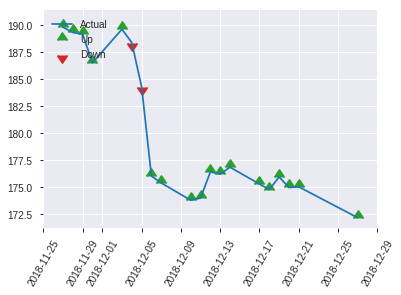


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.28940407979806615
RMSE: 0.5379628981612636
LogLoss: 0.7771627655996896
Mean Per-Class Error: 0.4146009085009734
AUC: 0.5781959766385464
pr_auc: 0.5961284973466406
Gini: 0.15639195327709277
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2659442722797394: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    107  0.9304   (107.0/115.0)
1      3    131  0.0224   (3.0/134.0)
Total  11   238  0.4418   (110.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.265944     0.704301  237
max f2                       0.235546     0.855683  246
max f0point5                 0.301254     0.62065   181
max accuracy                 0.301254     0.590361  181
max precision                0.495398     1         0
max recall                   0.235546     1         246
max specificity              0.495398     1         0
max absolute_mcc             0.329227     0.172898  102
max min_per_class_accuracy   0.319436     0.567164  124
max mean_per_class_accuracy  0.329227     0.585399  102

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 32.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.472732           1.85821   1.85821            1                0.486873  1                           0.486873            0.0223881       0.0223881                  85.8209   85.8209
    2        0.0200803                   0.432689           0.929104  1.48657            0.5              0.450257  0.8                         0.472227            0.00746269      0.0298507                  -7.08955  48.6567
    3        0.0321285                   0.419948           1.23881   1.39366            0.666667         0.427759  0.75                        0.455551            0.0149254       0.0447761                  23.8806   39.3657
    4        0.0401606                   0.412083           0         1.11493            0                0.414397  0.6                         0.447321            0               0.0447761                  -100      11.4925
    5        0.0522088                   0.40671            0.619403  1.00057            0.333333         0.40964   0.538462                    0.438625            0.00746269      0.0522388                  -38.0597  0.0574053
    6        0.100402                    0.384085           1.39366   1.18925            0.75             0.392515  0.64                        0.416492            0.0671642       0.119403                   39.3657   18.9254
    7        0.15261                     0.370708           0.714696  1.0269             0.384615         0.376712  0.552632                    0.402883            0.0373134       0.156716                   -28.5304  2.69049
    8        0.200803                    0.359541           0.929104  1.00343            0.5              0.367074  0.54                        0.394289            0.0447761       0.201493                   -7.08955  0.343284
    9        0.301205                    0.343368           1.41224   1.1397             0.76             0.35011   0.613333                    0.379563            0.141791        0.343284                   41.2239   13.9701
    10       0.401606                    0.330147           1.26358   1.17067            0.68             0.336213  0.63                        0.368725            0.126866        0.470149                   26.3582   17.0672
    11       0.502008                    0.319436           0.966269  1.12979            0.52             0.324953  0.608                       0.359971            0.0970149       0.567164                   -3.37313  12.9791
    12       0.598394                    0.3116             0.851679  1.08499            0.458333         0.315624  0.583893                    0.352828            0.0820896       0.649254                   -14.8321  8.49945
    13       0.698795                    0.303446           1.11493   1.08929            0.6              0.307545  0.586207                    0.346322            0.11194         0.761194                   11.4925   8.92949
    14       0.799197                    0.296048           0.668955  1.03649            0.36             0.300172  0.557789                    0.340524            0.0671642       0.828358                   -33.1045  3.64884
    15       0.899598                    0.284602           0.817612  1.01206            0.44             0.290008  0.544643                    0.334886            0.0820896       0.910448                   -18.2388  1.20602
    16       1                           0.225937           0.89194   1                  0.48             0.263527  0.538153                    0.327721      

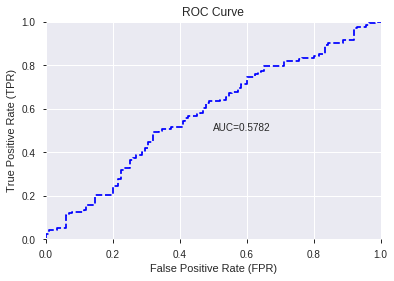

This function is available for GLM models only


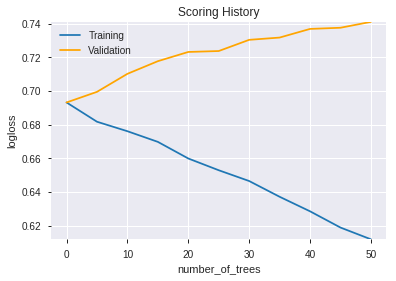

--2019-08-28 12:35:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.88
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.88|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_123434_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_123434_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'ADX_24',
 'STOCHF_fastk',
 'ADXR_12',
 'COSH',
 'DX_8',
 'day',
 'DX_12',
 'SIN',
 'BETA_24',
 'COS',
 'week',
 'aroonup_8',
 'BETA_12',
 'SAREXT',
 'BETA_8',
 'dayofyear',
 'AROONOSC_30',
 'STOCHRSI_fastk',
 'aroondown_30',
 'dayofweek',
 'aroondown_14',
 'aroondown_8',
 'aroonup_30',
 'days_in_month',
 'aroonup_12',
 'weekofyear',
 'aroonup_14',
 'EXP',
 'weekday_name',
 'aroondown_12',
 'month']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_123508_model_1  0.529202  18.135526                   0.5  0.733547  0.538091

variable  relative_importance  scaled_importance  percentage
0                  CDLMARUBOZU             0.009050           1.000000    0.014117
1                         COSH             0.007047           0.778596    0.010992
2                          EXP             0.007041           0.777967    0.010983
3                         SINH             0.007035           0.777348    0.010974
4           CDLMORNINGDOJISTAR             0.006506           0.718834    0.010148
...                        ...                  ...                ...         ...
1036  BBANDS_middleband_14_2_3             0.000000           0.000000    0.000000
1037  BBANDS_middleband_14_2_4             0.000000           0.000000    0.000000
1038  BBANDS_middleband_14_2_5             0.000000           0.000000    0.000000
1039                 MAVP_24_0             0.000000           0.000000    0.000000
1040                    WMA_30             0.000000           0.000000    0.000000

[1041 rows x 4 columns]

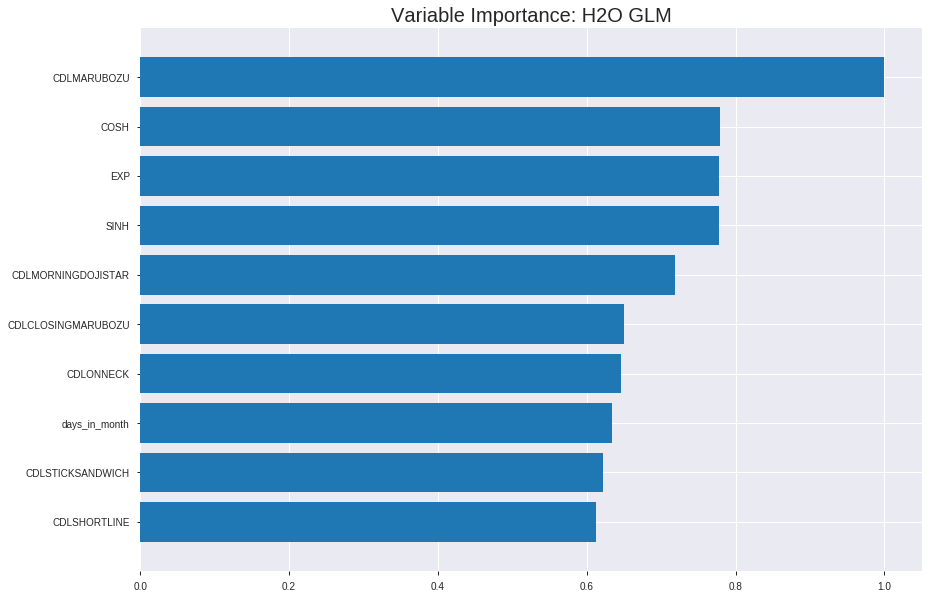

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_123508_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24674698208932067
RMSE: 0.49673633055104865
LogLoss: 0.6866172931488184
Null degrees of freedom: 1740
Residual degrees of freedom: 709
Null deviance: 2409.7685981527216
Residual deviance: 2390.8014147441854
AIC: 4454.801414744185
AUC: 0.5802375252932697
pr_auc: 0.5872685566398563
Gini: 0.16047505058653933
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48919726676388053: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      49   781   0.941    (781.0/830.0)
1      11   900   0.0121   (11.0/911.0)
Total  60   1681  0.4549   (792.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489197     0.694444  352
max f2                       0.477066     0.847948  375
max f0point5                 0.511893     0.598381  261
max accuracy                 0.516891     0.573234  235
max precision                0.575829     1         0
max recall                   0.447304     1         395
max specificity              0.575829     1         0
max absolute_mcc             0.516754     0.139094  236
max min_per_class_accuracy   0.524774     0.557629  186
max mean_per_class_accuracy  0.516891     0.565532  235

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 52.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.560151           1.59257   1.59257            0.833333         0.56545   0.833333                    0.56545             0.0164654       0.0164654                  59.2572   59.2572
    2        0.0201034                   0.555773           0.786918  1.20125            0.411765         0.557816  0.628571                    0.561742            0.00768386      0.0241493                  -21.3082  20.1255
    3        0.0304423                   0.553888           1.59257   1.33415            0.833333         0.554841  0.698113                    0.559398            0.0164654       0.0406147                  59.2572   33.4155
    4        0.0402068                   0.552482           1.23659   1.31046            0.647059         0.553222  0.685714                    0.557898            0.0120746       0.0526894                  23.6586   31.0459
    5        0.0505457                   0.551053           1.16789   1.2813             0.611111         0.551617  0.670455                    0.556614            0.0120746       0.064764                   16.7886   28.1297
    6        0.100517                    0.545738           1.14226   1.21218            0.597701         0.548004  0.634286                    0.552333            0.0570801       0.121844                   14.2259   21.2175
    7        0.150488                    0.542342           1.09833   1.17437            0.574713         0.54403   0.614504                    0.549576            0.0548847       0.176729                   9.83257   17.437
    8        0.20046                     0.538915           1.05439   1.14446            0.551724         0.540591  0.598854                    0.547336            0.0526894       0.229418                   5.43927   14.4462
    9        0.300402                    0.533406           1.04341   1.11084            0.545977         0.536003  0.581262                    0.543566            0.104281        0.333699                   4.34094   11.0842
    10       0.400345                    0.529145           1.07636   1.10223            0.563218         0.531129  0.576758                    0.540461            0.107574        0.441273                   7.63592   10.2234
    11       0.500287                    0.524786           1.15324   1.11242            0.603448         0.526781  0.58209                     0.537728            0.115258        0.556531                   15.3242   11.2424
    12       0.60023                     0.520112           0.966527  1.08813            0.505747         0.522558  0.569378                    0.535202            0.0965971       0.653128                   -3.34734  8.81307
    13       0.700172                    0.51515            1.04341   1.08175            0.545977         0.517705  0.566038                    0.532705            0.104281        0.757409                   4.34094   8.17472
    14       0.800115                    0.508719           0.878661  1.05638            0.45977          0.512057  0.552764                    0.530125            0.0878156       0.845225                   -12.1339  5.63796
    15       0.900057                    0.500256           0.922594  1.04152            0.482759         0.504917  0.54499                     0.527326            0.0922064       0.937431                   -7.74064  4.1524
    16       1                           0.329035           0.626046  1                  0.327586         0.486664  0.523262                    0.523262           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3461176002929265
RMSE: 0.5883176015494747
LogLoss: 6.172769393017873
Null degrees of freedom: 497
Residual degrees of freedom: -534
Null deviance: 689.5913742505304
Residual deviance: 99710.34533317781
AIC: 101774.34533317781
AUC: 0.5173664399605822
pr_auc: 0.5315367504644222
Gini: 0.03473287992116436
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.1182192067277904e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    239  1        (239.0/239.0)
1      0    259  0        (0.0/259.0)
Total  0    498  0.4799   (239.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.11822e-48  0.68428    358
max f2                       1.11822e-48  0.844198   358
max f0point5                 1.11822e-48  0.5753     358
max accuracy                 0.501507     0.532129   237
max precision                0.567692     1          0
max recall                   1.11822e-48  1          358
max specificity              0.567692     1          0
max absolute_mcc             0.558482     0.0747837  2
max min_per_class_accuracy   0.497579     0.528958   248
max mean_per_class_accuracy  0.501507     0.533069   237

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 31.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.553562           1.15367   1.15367            0.6              0.560883     0.6                         0.560883            0.011583        0.011583                   15.3668    15.3668
    2        0.0200803                   0.548804           0.769112  0.96139            0.4              0.550698     0.5                         0.555791            0.00772201      0.019305                   -23.0888   -3.861
    3        0.0301205                   0.547138           0.769112  0.897297           0.4              0.547811     0.466667                    0.553131            0.00772201      0.027027                   -23.0888   -10.2703
    4        0.0401606                   0.545568           1.15367   0.96139            0.6              0.546371     0.5                         0.551441            0.011583        0.03861                    15.3668    -3.861
    5        0.0502008                   0.544533           0.769112  0.922934           0.4              0.545001     0.48                        0.550153            0.00772201      0.046332                   -23.0888   -7.70656
    6        0.100402                    0.538069           1.23058   1.07676            0.64             0.541287     0.56                        0.54572             0.0617761       0.108108                   23.0579    7.67568
    7        0.150602                    0.533846           0.769112  0.974208           0.4              0.536014     0.506667                    0.542485            0.03861         0.146718                   -23.0888   -2.57915
    8        0.200803                    0.530086           1.07676   0.999846           0.56             0.532173     0.52                        0.539907            0.0540541       0.200772                   7.67568    -0.015444
    9        0.301205                    0.523638           1.15367   1.05112            0.6              0.526558     0.546667                    0.535457            0.11583         0.316602                   15.3668    5.11197
    10       0.399598                    0.512896           1.09873   1.06284            0.571429         0.518509     0.552764                    0.531284            0.108108        0.42471                    9.87314    6.28432
    11       0.5                         0.497578           1.0383    1.05792            0.54             0.506        0.550201                    0.526207            0.104247        0.528958                   3.83012    5.79151
    12       0.600402                    0.331722           0.884479  1.02891            0.46             0.464114     0.535117                    0.515823            0.0888031       0.617761                   -11.5521   2.89123
    13       0.698795                    3.14694e-16        0.824049  1.00007            0.428571         0.0702989    0.520115                    0.453092            0.0810811       0.698842                   -17.5951   0.0066569
    14       1                           0                  0.999846  1                  0.52             2.99605e-20  0.52008                     0.316618            0.301158        1                          -0.015444  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 12:35:13  0.000 sec   2            2.7       1032          1.37323           200.222
    2019-08-28 12:35:15  2.319 sec   4            2         1039          1.37049           202.691
    2019-08-28 12:35:17  4.689 sec   6            1.4       1042          1.36726           204.83
    2019-08-28 12:35:20  7.052 sec   8            1.1       1042          1.36351           207.099
    2019-08-28 12:35:22  9.414 sec   10           0.77      1042          1.35929           209.067

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5381526104417671)

('F1', 0.6997389033942559)

('auc', 0.5292018170019468)

('logloss', 18.135526003244653)

('mean_per_class_error', 0.47076573653471765)

('rmse', 0.7335470133915327)

('mse', 0.5380912208556374)

glm prediction progress: |████████████████████████████████████████████████| 100%


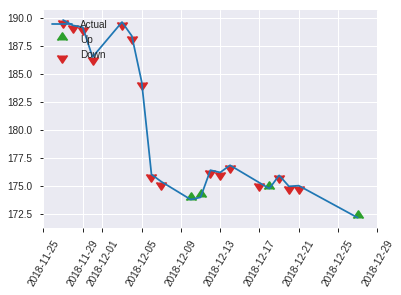


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5380912208556374
RMSE: 0.7335470133915327
LogLoss: 18.135526003244653
Null degrees of freedom: 248
Residual degrees of freedom: -783
Null deviance: 343.95763235704146
Residual deviance: 175607.8565502868
AIC: 177671.8565502868
AUC: 0.5292018170019468
pr_auc: 0.725290322626683
Gini: 0.05840363400389359
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.775133442644604e-57: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    134  0        (0.0/134.0)
Total  0    249  0.4618   (115.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       6.77513e-57  0.699739   10
max f2                       6.77513e-57  0.853503   10
max f0point5                 6.77513e-57  0.59292    10
max accuracy                 6.77513e-57  0.538153   10
max precision                0.00572869   1          0
max recall                   6.77513e-57  1          10
max specificity              0.00572869   1          0
max absolute_mcc             9.1143e-45   0.148465   9
max min_per_class_accuracy   9.1143e-45   0.0671642  9
max mean_per_class_accuracy  9.1143e-45   0.529234   9

Gains/Lift Table: Avg response rate: 53.82 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.000274239        1.85821   1.85821            1                0.00255265   1                           0.00255265          0.0223881       0.0223881                  85.8209   85.8209
    2        0.0200803                   2.40766e-11        0.929104  1.48657            0.5              1.29307e-06  0.8                         0.00153211          0.00746269      0.0298507                  -7.08955  48.6567
    3        0.0321285                   3.70425e-21        1.85821   1.62593            1                2.09473e-13  0.875                       0.000957567         0.0223881       0.0522388                  85.8209   62.5933
    4        0.0401606                   7.29144e-46        1.85821   1.67239            1                4.16113e-31  0.9                         0.000766054         0.0149254       0.0671642                  85.8209   67.2388
    5        0.0522088                   5.01584e-75        0.619403  1.42939            0.333333         5.39752e-55  0.769231                    0.000589272         0.00746269      0.0746269                  -38.0597  42.9392
    6        1                           0                  0.976347  1                  0.525424         6.02479e-85  0.538153                    3.07652e-05         0.925373        1                          -2.36529  0

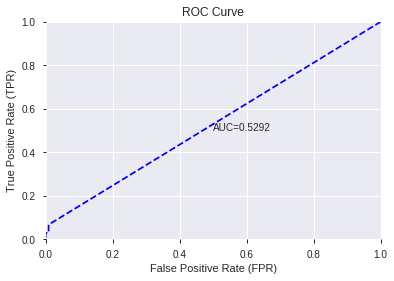

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


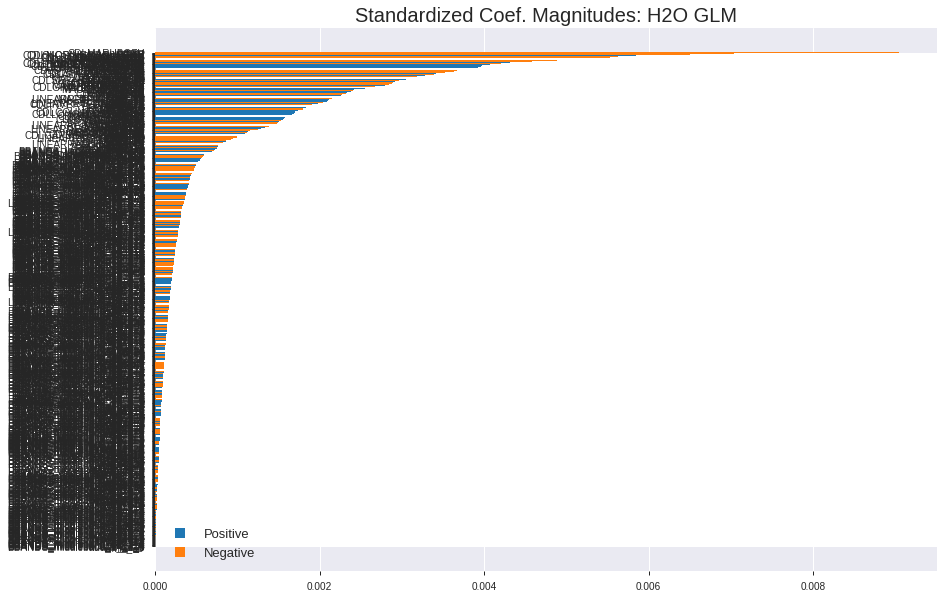

'log_likelihood'
--2019-08-28 12:35:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_123508_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_123508_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

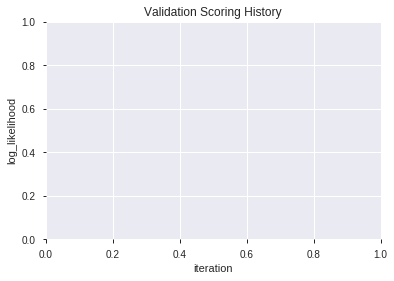

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_123601_model_5  0.571252  0.816786              0.418073  0.552286  0.305020
1  XGBoost_grid_1_AutoML_20190828_123601_model_2  0.568689  0.687882              0.486340  0.497379  0.247386
2               XGBoost_3_AutoML_20190828_123601  0.568527  0.730113              0.491304  0.517614  0.267924
3  XGBoost_grid_1_AutoML_20190828_123601_model_1  0.554640  0.768822              0.472680  0.534514  0.285705
4  XGBoost_grid_1_AutoML_20190828_123601_model_4  0.550681  0.687556              0.477644  0.497207  0.247215
5               XGBoost_2_AutoML_20190828_123601  0.543543  0.698958              0.455289  0.502887  0.252896
6  XGBoost_grid_1_AutoML_20190828_123601_model_6  0.525049  0.732368              0.490688  0.518202  0.268533
7               XGBoost_1_AutoML_20190828_123601  0.508955  0.722992              0.495036  0.514050  0.264247
8  XGBoost_grid_1_AutoML_20190828_123601_model_7  0.501103  0.743544              0.500000  0.523024  0.273554
9  XGBoost_grid_1_AutoML_20190828_123601_model_3  0.497145  0.784957              0.495652  0.540810  0.292476

variable  relative_importance  scaled_importance  percentage
0                        BOP           504.478455           1.000000    0.021950
1                     Volume           437.443634           0.867121    0.019033
2                        day           381.598419           0.756422    0.016603
3                       Open           326.200073           0.646609    0.014193
4       HT_PHASOR_quadrature           256.181091           0.507814    0.011146
..                       ...                  ...                ...         ...
619  BBANDS_upperband_14_1_3             1.381325           0.002738    0.000060
620                  KAMA_12             1.344693           0.002666    0.000059
621  BBANDS_upperband_24_0_2             1.238458           0.002455    0.000054
622  BBANDS_upperband_12_5_2             1.003033           0.001988    0.000044
623  BBANDS_upperband_24_1_2             0.921384           0.001826    0.000040

[624 rows x 4 columns]

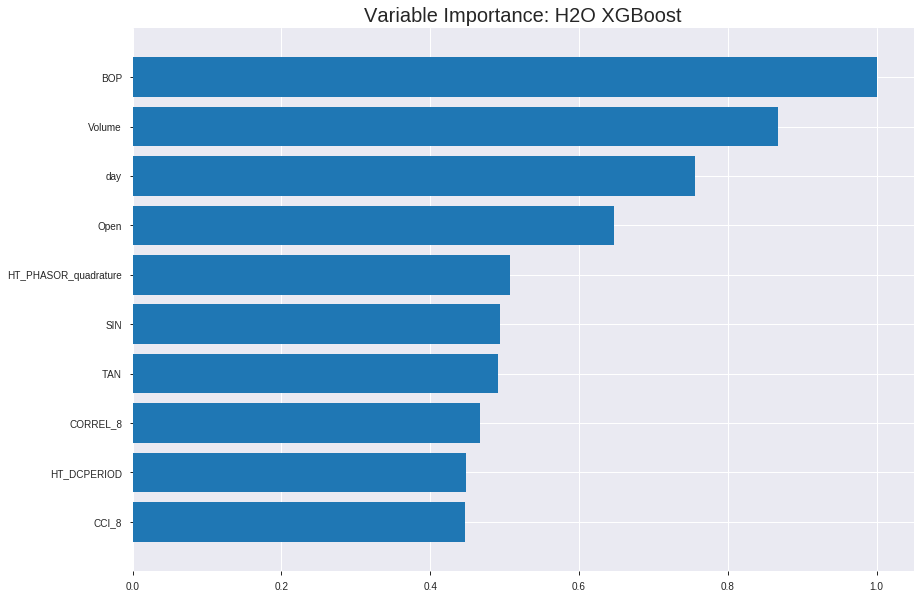

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_123601_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04541195004892003
RMSE: 0.21310079786082461
LogLoss: 0.22970652164988528
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9989023051591658
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4859931468963623: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      830  0    0        (0.0/830.0)
1      0    911  0        (0.0/911.0)
Total  830  911  0        (0.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.485993     1        199
max f2                       0.485993     1        199
max f0point5                 0.485993     1        199
max accuracy                 0.485993     1        199
max precision                0.927771     1        0
max recall                   0.485993     1        199
max specificity              0.927771     1        0
max absolute_mcc             0.485993     1        199
max min_per_class_accuracy   0.485993     1        199
max mean_per_class_accuracy  0.485993     1        199

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 51.98 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0103389                   0.908604           1.91109  1.91109            1                0.916946  1                           0.916946            0.0197585       0.0197585                  91.1087  91.1087
    2        0.0201034                   0.900447           1.91109  1.91109            1                0.905235  1                           0.911258            0.0186608       0.0384193                  91.1087  91.1087
    3        0.0304423                   0.890055           1.91109  1.91109            1                0.896108  1                           0.906112            0.0197585       0.0581778                  91.1087  91.1087
    4        0.0402068                   0.883657           1.91109  1.91109            1                0.886538  1                           0.901359            0.0186608       0.0768386                  91.1087  91.1087
    5        0.0505457                   0.880011           1.91109  1.91109            1                0.881467  1                           0.89729             0.0197585       0.0965971                  91.1087  91.1087
    6        0.100517                    0.860114           1.91109  1.91109            1                0.870116  1                           0.88378             0.0954995       0.192097                   91.1087  91.1087
    7        0.150488                    0.846012           1.91109  1.91109            1                0.853073  1                           0.873584            0.0954995       0.287596                   91.1087  91.1087
    8        0.20046                     0.830044           1.91109  1.91109            1                0.838043  1                           0.864724            0.0954995       0.383095                   91.1087  91.1087
    9        0.300402                    0.800795           1.91109  1.91109            1                0.815283  1                           0.848275            0.190999        0.574094                   91.1087  91.1087
    10       0.400345                    0.762154           1.91109  1.91109            1                0.782361  1                           0.83182             0.190999        0.765093                   91.1087  91.1087
    11       0.500287                    0.680394           1.91109  1.91109            1                0.727671  1                           0.811014            0.190999        0.956092                   91.1087  91.1087
    12       0.60023                     0.280679           0.43933  1.66603            0.229885         0.396664  0.87177                     0.742022            0.0439078       1                          -56.067  66.6029
    13       0.700172                    0.2227             0        1.42822            0                0.2479    0.747334                    0.671491            0               1                          -100     42.822
    14       0.800115                    0.185676           0        1.24982            0                0.203742  0.653984                    0.613064            0               1                          -100     24.9821
    15       0.900057                    0.147268           0        1.11104            0                0.169039  0.581366                    0.56376             0               1                          -100     11.104
    16       1                           0.0711003          0        1                  0                0.124381  0.523262                    0.519847            0               1                 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.27504148861579775
RMSE: 0.5244439804362309
LogLoss: 0.7547856701208974
Mean Per-Class Error: 0.459330220836497
AUC: 0.5249672864735626
pr_auc: 0.5494192406576359
Gini: 0.04993457294712522
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10226830840110779: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    239  1        (239.0/239.0)
1      0    259  0        (0.0/259.0)
Total  0    498  0.4799   (239.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.102268     0.68428    399
max f2                       0.102268     0.844198   399
max f0point5                 0.158547     0.575442   389
max accuracy                 0.419592     0.536145   210
max precision                0.697636     0.684211   35
max recall                   0.102268     1          399
max specificity              0.863116     0.995816   0
max absolute_mcc             0.57668      0.0952922  100
max min_per_class_accuracy   0.420557     0.532819   208
max mean_per_class_accuracy  0.57668      0.54067    100

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 44.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.805188           0.769112  0.769112           0.4              0.841508  0.4                         0.841508            0.00772201      0.00772201                 -23.0888   -23.0888
    2        0.0200803                   0.788503           1.53822   1.15367            0.8              0.797309  0.6                         0.819409            0.015444        0.023166                   53.8224    15.3668
    3        0.0301205                   0.75955            1.15367   1.15367            0.6              0.776007  0.6                         0.804941            0.011583        0.034749                   15.3668    15.3668
    4        0.0401606                   0.740545           1.15367   1.15367            0.6              0.75517   0.6                         0.792498            0.011583        0.046332                   15.3668    15.3668
    5        0.0502008                   0.725097           1.53822   1.23058            0.8              0.730224  0.64                        0.780044            0.015444        0.0617761                  53.8224    23.0579
    6        0.100402                    0.66193            0.999846  1.11521            0.52             0.696382  0.58                        0.738213            0.0501931       0.111969                   -0.015444  11.5212
    7        0.150602                    0.630132           0.999846  1.07676            0.52             0.642921  0.56                        0.706449            0.0501931       0.162162                   -0.015444  7.67568
    8        0.200803                    0.598624           1.30749   1.13444            0.68             0.615534  0.59                        0.68372             0.0656371       0.227799                   30.749     13.444
    9        0.301205                    0.537644           1.07676   1.11521            0.56             0.56566   0.58                        0.644367            0.108108        0.335907                   7.67568    11.5212
    10       0.399598                    0.482137           0.902529  1.06284            0.469388         0.510591  0.552764                    0.611427            0.0888031       0.42471                    -9.74706   6.28432
    11       0.5                         0.420365           1.07676   1.06564            0.56             0.448727  0.554217                    0.578756            0.108108        0.532819                   7.67568    6.56371
    12       0.600402                    0.375448           0.96139   1.0482             0.5              0.397617  0.545151                    0.548466            0.0965251       0.629344                   -3.861     4.82044
    13       0.698795                    0.330819           0.706327  1.00007            0.367347         0.353425  0.520115                    0.521003            0.0694981       0.698842                   -29.3673   0.0066569
    14       0.799197                    0.288296           0.846023  0.980714           0.44             0.310357  0.51005                     0.49454             0.0849421       0.783784                   -15.3977   -1.92856
    15       0.899598                    0.247222           0.922934  0.974266           0.48             0.268109  0.506696                    0.469269            0.0926641       0.876448                   -7.70656   -2.57343
    16       1                           0.102268           1.23058   1                  0.64             0.193664  0.52008                 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:36:40  19.267 sec  0                  0.5              0.693147            0.5             0                  1                0.476738                         0.5                0.693147              0.5               0                    1                  0.47992
    2019-08-28 12:36:42  21.101 sec  5                  0.452598         0.602155            0.956027        0.955211           1.91109          0.108558                         0.499707           0.692611              0.547439          0.563535             1.53822            0.477912
    2019-08-28 12:36:43  21.885 sec  10                 0.41103          0.527836            0.989737        0.989318           1.91109          0.0413555                        0.501123           0.695544              0.534757          0.567077             1.53822            0.475904
    2019-08-28 12:36:44  22.650 sec  15                 0.384301         0.482329            0.995152        0.994363           1.91109          0.031591                         0.503378           0.700666              0.548594          0.563907             1.15367            0.47992
    2019-08-28 12:36:44  23.443 sec  20                 0.353018         0.431306            0.998563        0.997719           1.91109          0.0160827                        0.509335           0.714114              0.537301          0.570065             1.53822            0.477912
    2019-08-28 12:36:45  24.271 sec  25                 0.320189         0.380062            0.999602        0.998537           1.91109          0.00689259                       0.51154            0.719516              0.530702          0.567075             1.53822            0.47992
    2019-08-28 12:36:46  25.128 sec  30                 0.293399         0.340388            0.999926        0.998836           1.91109          0.00287191                       0.514321           0.726563              0.532172          0.5642               1.15367            0.47992
    2019-08-28 12:36:47  25.941 sec  35                 0.272996         0.310979            0.999972        0.998877           1.91109          0.000574383                      0.517402           0.735382              0.533497          0.564099             0.769112           0.475904
    2019-08-28 12:36:48  26.789 sec  40                 0.250591         0.279442            0.999991        0.998894           1.91109          0.00114877                       0.517414           0.736682              0.541041          0.572297             1.15367            0.477912
    2019-08-28 12:36:49  27.664 sec  45                 0.23064          0.252567            0.999997        0.9989             1.91109          0.000574383                      0.520664           0.745182              0.533465          0.56482              0.769112           0.47992
    2019-08-28 12:36:49  28.589 sec  50                 0.213101         0.229707            1               0.998902           1.91109          0                                0.524444           0.754786              0.524967          0.549419             0.769112           0.47992

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      504.47845458984375     1.0                    0.021949943430288194
Volume                   437.4436340332031      0.8671205480695068     0.01903324697736617
day                      381.5984191894531      0.7564216384616548     0.016603412173679232
Open                     326.2000732421875      0.6466085325832162     0.014193020711743255
HT_PHASOR_quadrature     256.18109130859375     0.5078137410583307     0.011146482889353377
---                      ---                    ---                    ---
BBANDS_upperband_14_1_3  1.3813245296478271     0.002738123931914765   6.010166541064737e-05
KAMA_12                  1.3446928262710571     0.0026655109133735615  5.850781376136549e-05
BBANDS_upperband_24_0_2  1.238458275794983      0.002454927984589326   5.388553038716711e-05
BBANDS_upperband_12_5_2  1.003032922744751      0.001988257206267108   4.3642133202425876e-05
BBANDS_upperband_24_1_2  0.9213842153549194     0.001826409447166644   4.008958404585177e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.606425702811245)

('F1', 0.711764705882353)

('auc', 0.5712524334847502)

('logloss', 0.816785881409991)

('mean_per_class_error', 0.4162232316677482)

('rmse', 0.5522860832149799)

('mse', 0.3050199177129437)

xgboost prediction progress: |████████████████████████████████████████████| 100%


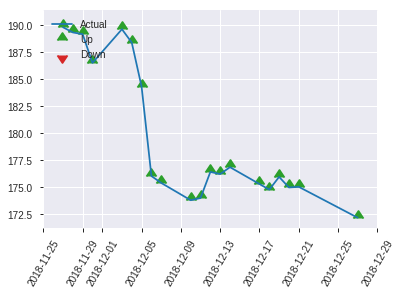


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.3050199177129437
RMSE: 0.5522860832149799
LogLoss: 0.816785881409991
Mean Per-Class Error: 0.4162232316677482
AUC: 0.5712524334847502
pr_auc: 0.5633274228698074
Gini: 0.14250486696950038
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2220080941915512: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      30   85   0.7391   (85.0/115.0)
1      13   121  0.097    (13.0/134.0)
Total  43   206  0.3936   (98.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.222008     0.711765  205
max f2                       0.151797     0.855683  246
max f0point5                 0.230038     0.631692  199
max accuracy                 0.230038     0.606426  199
max precision                0.556044     1         0
max recall                   0.151797     1         246
max specificity              0.556044     1         0
max absolute_mcc             0.222008     0.216119  205
max min_per_class_accuracy   0.285741     0.556522  125
max mean_per_class_accuracy  0.230038     0.583777  199

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 29.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0120482                   0.521801           0.619403  0.619403           0.333333         0.535583  0.333333                    0.535583            0.00746269      0.00746269                 -38.0597   -38.0597
    2        0.0200803                   0.514106           0.929104  0.743284           0.5              0.517301  0.4                         0.52827             0.00746269      0.0149254                  -7.08955   -25.6716
    3        0.0321285                   0.485317           1.85821   1.16138            1                0.496872  0.625                       0.516496            0.0223881       0.0373134                  85.8209    16.1381
    4        0.0401606                   0.47909            0         0.929104           0                0.481236  0.5                         0.509444            0               0.0373134                  -100       -7.08955
    5        0.0522088                   0.468787           0.619403  0.857635           0.333333         0.476202  0.461538                    0.501773            0.00746269      0.0447761                  -38.0597   -14.2365
    6        0.100402                    0.413722           1.23881   1.0406             0.666667         0.442907  0.56                        0.473517            0.0597015       0.104478                   23.8806    4.0597
    7        0.15261                     0.383219           1.00057   1.0269             0.538462         0.39422   0.552632                    0.446389            0.0522388       0.156716                   0.0574053  2.69049
    8        0.200803                    0.364122           1.08396   1.0406             0.583333         0.372776  0.56                        0.428722            0.0522388       0.208955                   8.39552    4.0597
    9        0.301205                    0.334144           1.11493   1.06537            0.6              0.347926  0.573333                    0.40179             0.11194         0.320896                   11.4925    6.53731
    10       0.401606                    0.30342            1.11493   1.07776            0.6              0.316576  0.58                        0.380486            0.11194         0.432836                   11.4925    7.77612
    11       0.502008                    0.287787           1.18925   1.10006            0.64             0.295399  0.592                       0.363469            0.119403        0.552239                   18.9254    10.006
    12       0.598394                    0.265263           1.00653   1.08499            0.541667         0.275927  0.583893                    0.349368            0.0970149       0.649254                   0.652985   8.49945
    13       0.698795                    0.247255           1.0406    1.07862            0.56             0.256731  0.58046                     0.336058            0.104478        0.753731                   4.0597     7.86155
    14       0.799197                    0.230045           1.18925   1.09251            0.64             0.238253  0.58794                     0.323771            0.119403        0.873134                   18.9254    9.25148
    15       0.899598                    0.196102           0.668955  1.04524            0.36             0.214843  0.5625                      0.311614            0.0671642       0.940299                   -33.1045   4.52425
    16       1                           0.135199           0.594627  1                  0.32             0.173576  0.538153                   

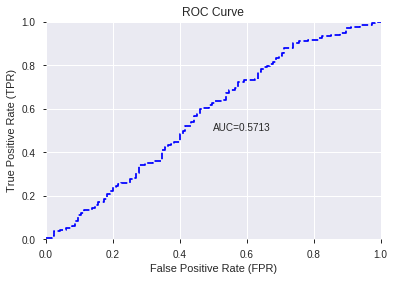

This function is available for GLM models only


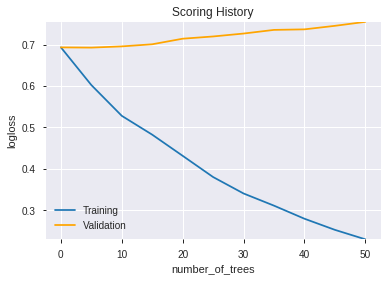

--2019-08-28 12:37:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_123601_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_123601_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_123715_model_5  0.525503  18.158481                   0.5  0.733572  0.538128
1  DeepLearning_grid_1_AutoML_20190828_123715_model_6  0.525503  18.200122                   0.5  0.733583  0.538144
2               DeepLearning_1_AutoML_20190828_123715  0.510642  18.474532                   0.5  0.733589  0.538153
3  DeepLearning_grid_1_AutoML_20190828_123715_model_1  0.503731  18.587133                   0.5  0.733589  0.538153
4  DeepLearning_grid_1_AutoML_20190828_123715_model_8  0.500000   0.691422                   0.5  0.499137  0.249137
5  DeepLearning_grid_1_AutoML_20190828_123715_model_2  0.500000  18.587133                   0.5  0.733589  0.538153
6  DeepLearning_grid_1_AutoML_20190828_123715_model_9  0.500000   0.690242                   0.5  0.498546  0.248549
7  DeepLearning_grid_1_AutoML_20190828_123715_model_3  0.500000  18.587133                   0.5  0.733589  0.538153
8  DeepLearning_grid_1_AutoML_20190828_123715_model_4  0.500000  18.587133                   0.5  0.733589  0.538153
9  DeepLearning_grid_1_AutoML_20190828_123715_model_7  0.488806  15.928088                   0.5  0.679594  0.461847

variable  relative_importance  scaled_importance  percentage
0         HT_TRENDMODE             1.000000           1.000000    0.022300
1            CDLONNECK             0.995016           0.995016    0.022189
2   CDLMORNINGDOJISTAR             0.989493           0.989493    0.022066
3                  day             0.976829           0.976829    0.021783
4                  BOP             0.968110           0.968110    0.021589
5      CDLUNIQUE3RIVER             0.961337           0.961337    0.021438
6         aroondown_12             0.958076           0.958076    0.021365
7            CDL2CROWS             0.947049           0.947049    0.021119
8    CDLLONGLEGGEDDOJI             0.939169           0.939169    0.020943
9                 DX_8             0.934728           0.934728    0.020844
10      CDLRICKSHAWMAN             0.929426           0.929426    0.020726
11    CDLSTICKSANDWICH             0.925725           0.925725    0.020644
12       days_in_month             0.924408           0.924408    0.020614
13             BETA_24             0.919084           0.919084    0.020496
14        aroondown_14             0.917686           0.917686    0.020464
15   CDLSTALLEDPATTERN             0.917595           0.917595    0.020462
16         aroondown_8             0.913585           0.913585    0.020373
17               month             0.913386           0.913386    0.020368
18        weekday_name             0.908496           0.908496    0.020259
19      STOCHRSI_fastk             0.908082           0.908082    0.020250
20             BETA_12             0.907963           0.907963    0.020248
21           aroonup_8             0.904272           0.904272    0.020165
22              SAREXT             0.903641           0.903641    0.020151
23        aroondown_30             0.902573           0.902573    0.020127
24             CDLDOJI             0.902142           0.902142    0.020118
25             ADXR_12             0.901703           0.901703    0.020108
26       CDLHIKKAKEMOD             0.896486           0.896486    0.019992
27                 SIN             0.893196           0.893196    0.019918
28          weekofyear             0.890324           0.890324    0.019854
29           dayofyear             0.886208           0.886208    0.019762
30               DX_12             0.881160           0.881160    0.019650
31              ADX_24             0.878361           0.878361    0.019587
32              BETA_8             0.873910           0.873910    0.019488
33        STOCHF_fastk             0.867071           0.867071    0.019336
34           dayofweek             0.866999           0.866999    0.019334
35         AROONOSC_30             0.865718           0.865718    0.019305
36         CDLPIERCING             0.855748           0.855748    0.019083
37          aroonup_30             0.854423           0.854423    0.019054
38          aroonup_12             0.849870           0.849870    0.018952
39      STOCHRSI_fastd             0.847435           0.847435    0.018898
40             quarter             0.846841           0.846841    0.018885
41    CDLDRAGONFLYDOJI             0.842142           0.842142    0.018780
42                week             0.840644           0.840644    0.018746
43                 COS             0.840394           0.840394    0.018741
44                 EXP             0.836464           0.836464    0.018653
45         HT_DCPERIOD             0.836267           0.836267    0.018649
46                COSH             0.836096           0.836096    0.018645
47                SINH             0.833587           0.833587    0.018589
48          aroonup_14             0.830200           0.830200    0.018513
49             weekday             0.824070           0.824070    0.018377

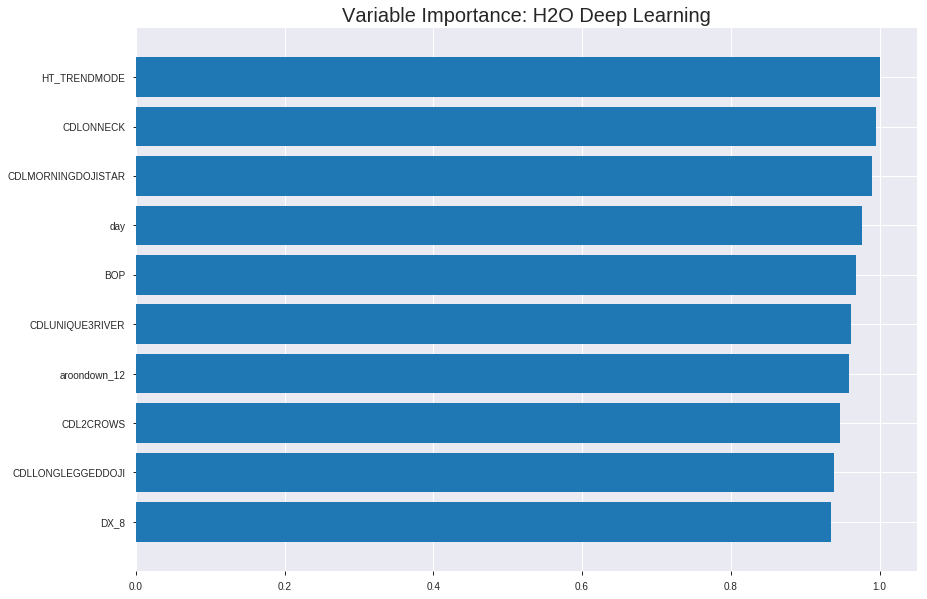

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_123715_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2807654313770558
RMSE: 0.5298730332608518
LogLoss: 0.7691741012939725
Mean Per-Class Error: 0.4732228585031675
AUC: 0.5255128086440162
pr_auc: 0.542877716878605
Gini: 0.05102561728803234
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05837276628923241: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    827   0.9964   (827.0/830.0)
1      0    911   0        (0.0/911.0)
Total  3    1738  0.475    (827.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0583728    0.687807   396
max f2                       0.0583728    0.84634    396
max f0point5                 0.22013      0.583415   336
max accuracy                 0.291165     0.539345   299
max precision                0.920961     1          0
max recall                   0.0583728    1          396
max specificity              0.920961     1          0
max absolute_mcc             0.22013      0.0683802  336
max min_per_class_accuracy   0.443056     0.506037   207
max mean_per_class_accuracy  0.321754     0.526777   279

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 45.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.848123           1.16789   1.16789            0.611111         0.868184  0.611111                    0.868184            0.0120746       0.0120746                  16.7886   16.7886
    2        0.0201034                   0.825599           0.899335  1.03745            0.470588         0.832966  0.542857                    0.851078            0.00878156      0.0208562                  -10.0665  3.74471
    3        0.0304423                   0.81346            1.38023   1.15386            0.722222         0.820008  0.603774                    0.840526            0.01427         0.0351262                  38.0229   15.3864
    4        0.0402068                   0.799228           1.12417   1.14665            0.588235         0.805707  0.6                         0.83207             0.0109769       0.0461032                  12.4169   14.6652
    5        0.0505457                   0.784451           0.955543  1.10756            0.5              0.791438  0.579545                    0.823759            0.00987925      0.0559824                  -4.44566  10.7562
    6        0.100517                    0.718296           0.988493  1.04837            0.517241         0.754118  0.548571                    0.789137            0.0493963       0.105379                   -1.15069  4.83676
    7        0.150488                    0.665115           1.03243   1.04307            0.54023          0.69449   0.545802                    0.757708            0.0515917       0.15697                    3.24262   4.3074
    8        0.20046                     0.622515           1.07636   1.05137            0.563218         0.642039  0.550143                    0.728874            0.053787        0.210757                   7.63592   5.13715
    9        0.300402                    0.552087           1.04341   1.04872            0.545977         0.586726  0.548757                    0.681582            0.104281        0.315038                   4.34094   4.87225
    10       0.400345                    0.494923           1.01046   1.03917            0.528736         0.523233  0.543759                    0.642051            0.100988        0.416026                   1.04596   3.91705
    11       0.500287                    0.442144           0.91161   1.01369            0.477011         0.469287  0.530425                    0.607538            0.0911087       0.507135                   -8.83897  1.36878
    12       0.60023                     0.391381           1.10931   1.02961            0.58046          0.415864  0.538756                    0.575623            0.110867        0.618002                   10.9309   2.96094
    13       0.700172                    0.340317           1.04341   1.03158            0.545977         0.364355  0.539787                    0.545467            0.104281        0.722283                   4.34094   3.15792
    14       0.800115                    0.278609           0.988493  1.0262             0.517241         0.308756  0.536971                    0.515899            0.0987925       0.821076                   -1.15069  2.61973
    15       0.900057                    0.21464            0.97751   1.02079            0.511494         0.248578  0.534142                    0.486216            0.0976948       0.918771                   -2.24901  2.07911
    16       1                           0.0432532          0.812761  1                  0.425287         0.152649  0.523262                    0.452878          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.35593288962669556
RMSE: 0.5966011143357809
LogLoss: 6.2392934438827705
Mean Per-Class Error: 0.4400252015314777
AUC: 0.5384484903313356
pr_auc: 0.585168459950051
Gini: 0.07689698066267114
Confusion Matrix (Act/Pred) for max f1 @ threshold = 7.569139238348767e-52: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    239  1        (239.0/239.0)
1      0    259  0        (0.0/259.0)
Total  0    498  0.4799   (239.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       7.56914e-52  0.68428   358
max f2                       7.56914e-52  0.844198  358
max f0point5                 7.56914e-52  0.5753    358
max accuracy                 0.5209       0.550201  128
max precision                0.739144     0.9       9
max recall                   7.56914e-52  1         358
max specificity              0.865626     0.995816  0
max absolute_mcc             0.650643     0.146128  54
max min_per_class_accuracy   0.242216     0.514644  249
max mean_per_class_accuracy  0.5209       0.559975  128

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 28.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.78933            1.53822   1.53822            0.8              0.845297     0.8                         0.845297            0.015444        0.015444                   53.8224    53.8224
    2        0.0200803                   0.734736           1.92278   1.7305             1                0.760941     0.9                         0.803119            0.019305        0.034749                   92.278     73.0502
    3        0.0301205                   0.725356           1.53822   1.66641            0.8              0.731216     0.866667                    0.779151            0.015444        0.0501931                  53.8224    66.6409
    4        0.0401606                   0.715561           1.53822   1.63436            0.8              0.720079     0.85                        0.764383            0.015444        0.0656371                  53.8224    63.4363
    5        0.0502008                   0.709243           1.15367   1.53822            0.6              0.712452     0.8                         0.753997            0.011583        0.0772201                  15.3668    53.8224
    6        0.100402                    0.658078           1.23058   1.3844             0.64             0.682148     0.72                        0.718073            0.0617761       0.138996                   23.0579    38.4402
    7        0.150602                    0.606123           0.846023  1.20494            0.44             0.630851     0.626667                    0.688999            0.042471        0.181467                   -15.3977   20.4942
    8        0.200803                    0.569586           1.23058   1.21135            0.64             0.585648     0.63                        0.663161            0.0617761       0.243243                   23.0579    21.1351
    9        0.301205                    0.484923           1.0383    1.15367            0.54             0.527065     0.6                         0.617796            0.104247        0.34749                    3.83012    15.3668
    10       0.399598                    0.377958           0.667087  1.03386            0.346939         0.43052      0.537688                    0.571683            0.0656371       0.413127                   -33.2913   3.38565
    11       0.5                         0.243185           0.999846  1.02703            0.52             0.315355     0.534137                    0.520211            0.100386        0.513514                   -0.015444  2.7027
    12       0.600402                    0.119794           1.0383    1.02891            0.54             0.189981     0.535117                    0.464989            0.104247        0.617761                   3.83012    2.89123
    13       0.698795                    1.43763e-17        0.824049  1.00007            0.428571         0.0302474    0.520115                    0.403775            0.0810811       0.698842                   -17.5951   0.0066569
    14       1                           0                  0.999846  1                  0.52             1.48341e-21  0.52008                     0.282156            0.301158        1                          -0.015444  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:40:15  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:40:16  1 min  9.718 sec  1152 obs/sec      1         1             1741       0.529873         0.769174            -0.125498      0.525513        0.542878           1.16789          0.475014                         0.596601           6.23929               -0.426032        0.538448          0.585168             1.53822            0.47992
    2019-08-28 12:40:23  1 min 16.273 sec  2322 obs/sec      10        10            17410      0.485087         0.660897            0.05672        0.613297        0.65233            1.91109          0.444572                         0.606823           7.45067               -0.475317        0.510783          0.519712             0.769112           0.47992
    2019-08-28 12:40:29  1 min 22.464 sec  2663 obs/sec      20        20            34820      0.470282         0.628679            0.113422       0.689413        0.715255           1.91109          0.38139                          0.610117           7.63533               -0.491379        0.516413          0.531168             1.15367            0.47992
    2019-08-28 12:40:36  1 min 29.052 sec  2828 obs/sec      31        31            53971      0.44614          0.576822            0.202109       0.759416        0.772702           1.91109          0.316485                         0.617972           7.77175               -0.530026        0.509556          0.524962             0.769112           0.47992
    2019-08-28 12:40:42  1 min 35.300 sec  2955 obs/sec      42        42            73122      0.421244         0.525106            0.288674       0.826236        0.833932           1.91109          0.28834                          0.614459           7.75681               -0.512681        0.523126          0.544755             1.15367            0.47992
    2019-08-28 12:40:48  1 min 41.583 sec  3029 obs/sec      53        53            92273      0.393972         0.470001            0.377797       0.879384        0.888418           1.91109          0.219414                         0.620269           7.81258               -0.541419        0.51979           0.534078             1.15367            0.47992
    2019-08-28 12:40:49  1 min 42.166 sec  3026 obs/sec      53        53            92273      0.529873         0.769174            -0.125498      0.525513        0.542878           1.16789          0.475014                         0.596601           6.23929               -0.426032        0.538448          0.585168             1.53822            0.47992

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
HT_TRENDMODE        1.0                    1.0                  0.022299928822712395
CDLONNECK           0.9950162172317505     0.9950162172317505   0.02218879082171257
CDLMORNINGDOJISTAR  0.9894928932189941     0.9894928932189941   0.022065621089363323
day                 0.9768288731575012     0.9768288731575012   0.02178321434338263
BOP                 0.9681101441383362     0.9681101441383362   0.021588787306830733
---                 ---                    ---                  ---
HT_DCPERIOD         0.8362674713134766     0.8362674713134766   0.018648705087040206
COSH                0.8360959887504578     0.8360959887504578   0.01864488103809055
SINH                0.8335871696472168     0.8335871696472168   0.018588934550659214
aroonup_14          0.8302001953125        0.8302001953125      0.01851340526407068
weekday             0.8240698575973511     0.8240698575973511   0.018376699169363665


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5381526104417671)

('F1', 0.6997389033942559)

('auc', 0.5255029201817002)

('logloss', 18.158481311695265)

('mean_per_class_error', 0.4744970798182998)

('rmse', 0.7335723264814917)

('mse', 0.5381283581794684)

deeplearning prediction progress: |███████████████████████████████████████| 100%


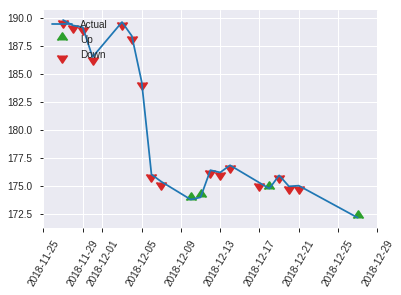


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5381283581794684
RMSE: 0.7335723264814917
LogLoss: 18.158481311695265
Mean Per-Class Error: 0.4744970798182998
AUC: 0.5255029201817002
pr_auc: 0.7187577245727759
Gini: 0.05100584036340039
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.514095764627619e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    134  0        (0.0/134.0)
Total  0    249  0.4618   (115.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       4.5141e-50   0.699739   9
max f2                       4.5141e-50   0.853503   9
max f0point5                 4.5141e-50   0.59292    9
max accuracy                 4.5141e-50   0.538153   9
max precision                0.00217211   1          0
max recall                   4.5141e-50   1          9
max specificity              0.00217211   1          0
max absolute_mcc             4.70211e-33  0.136237   8
max min_per_class_accuracy   4.70211e-33  0.0597015  8
max mean_per_class_accuracy  4.70211e-33  0.525503   8

Gains/Lift Table: Avg response rate: 53.82 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.000175362        1.85821   1.85821            1                0.001007     1                           0.001007            0.0223881       0.0223881                  85.8209   85.8209
    2        0.0200803                   1.04169e-12        0.929104  1.48657            0.5              4.71028e-07  0.8                         0.000604391         0.00746269      0.0298507                  -7.08955  48.6567
    3        0.0321285                   1.65229e-22        1.85821   1.62593            1                2.13595e-14  0.875                       0.000377744         0.0223881       0.0522388                  85.8209   62.5933
    4        0.0401606                   8.66706e-49        1.85821   1.67239            1                2.35106e-33  0.9                         0.000302195         0.0149254       0.0671642                  85.8209   67.2388
    5        0.0522088                   6.11657e-80        0.619403  1.42939            0.333333         1.37804e-58  0.769231                    0.000232458         0.00746269      0.0746269                  -38.0597  42.9392
    6        1                           0                  0.976347  1                  0.525424         2.73104e-90  0.538153                    1.21364e-05         0.925373        1                          -2.36529  0

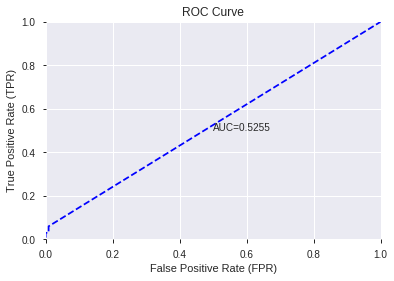

This function is available for GLM models only


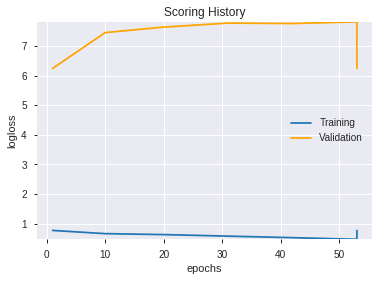

--2019-08-28 12:44:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.68
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.68|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_123715_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_123715_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_TRENDMODE',
 'CDLONNECK',
 'CDLMORNINGDOJISTAR',
 'day',
 'BOP',
 'CDLUNIQUE3RIVER',
 'aroondown_12',
 'CDL2CROWS',
 'CDLLONGLEGGEDDOJI',
 'DX_8',
 'CDLRICKSHAWMAN',
 'CDLSTICKSANDWICH',
 'days_in_month',
 'BETA_24',
 'aroondown_14',
 'CDLSTALLEDPATTERN',
 'aroondown_8',
 'month',
 'weekday_name',
 'STOCHRSI_fastk',
 'BETA_12',
 'aroonup_8',
 'SAREXT',
 'aroondown_30',
 'CDLDOJI',
 'ADXR_12',
 'CDLHIKKAKEMOD',
 'SIN',
 'weekofyear',
 'dayofyear',
 'DX_12',
 'ADX_24',
 'BETA_8',
 'STOCHF_fastk',
 'dayofweek',
 'AROONOSC_30',
 'CDLPIERCING',
 'aroonup_30',
 'aroonup_12',
 'STOCHRSI_fastd',
 'quarter',
 'CDLDRAGONFLYDOJI',
 'week',
 'COS',
 'EXP',
 'HT_DCPERIOD',
 'COSH',
 'SINH',
 'aroonup_14',
 'weekday']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_124458_model_1  0.525503  18.160138                   0.5  0.733565  0.538118

variable  relative_importance  scaled_importance  percentage
0                 COSH             0.007770           1.000000    0.050379
1                  EXP             0.007767           0.999599    0.050359
2                 SINH             0.007764           0.999262    0.050342
3   CDLMORNINGDOJISTAR             0.007250           0.933140    0.047011
4            CDLONNECK             0.006131           0.789100    0.039754
5              BETA_12             0.006070           0.781224    0.039357
6     CDLSTICKSANDWICH             0.006001           0.772373    0.038911
7        days_in_month             0.005764           0.741889    0.037376
8               BETA_8             0.005381           0.692554    0.034890
9     CDLDRAGONFLYDOJI             0.004439           0.571330    0.028783
10   CDLSTALLEDPATTERN             0.003973           0.511381    0.025763
11         aroondown_8             0.003962           0.509969    0.025692
12         CDLPIERCING             0.003934           0.506277    0.025506
13           CDL2CROWS             0.003897           0.501533    0.025267
14             BETA_24             0.003822           0.491943    0.024784
15          aroonup_12             0.003705           0.476887    0.024025
16        aroondown_30             0.003648           0.469492    0.023653
17               DX_12             0.003552           0.457190    0.023033
18              ADX_24             0.003355           0.431822    0.021755
19        weekday_name             0.003316           0.426748    0.021499
20             ADXR_12             0.003273           0.421251    0.021222
21                DX_8             0.003064           0.394399    0.019869
22         AROONOSC_30             0.003045           0.391950    0.019746
23           dayofweek             0.002988           0.384596    0.019376
24             weekday             0.002984           0.383995    0.019345
25           aroonup_8             0.002945           0.379008    0.019094
26                 COS             0.002885           0.371289    0.018705
27          aroonup_14             0.002854           0.367332    0.018506
28      STOCHRSI_fastd             0.002657           0.341929    0.017226
29                 SIN             0.002655           0.341673    0.017213
30      STOCHRSI_fastk             0.002222           0.286002    0.014408
31        aroondown_12             0.002186           0.281327    0.014173
32        aroondown_14             0.001855           0.238690    0.012025
33   CDLLONGLEGGEDDOJI             0.001797           0.231336    0.011654
34          aroonup_30             0.001716           0.220921    0.011130
35       CDLHIKKAKEMOD             0.001608           0.207012    0.010429
36             CDLDOJI             0.001478           0.190214    0.009583
37             quarter             0.001392           0.179161    0.009026
38        STOCHF_fastk             0.001345           0.173092    0.008720
39               month             0.001315           0.169191    0.008524
40                 BOP             0.001211           0.155822    0.007850
41           dayofyear             0.001186           0.152688    0.007692
42      CDLRICKSHAWMAN             0.001124           0.144721    0.007291
43         HT_DCPERIOD             0.000927           0.119358    0.006013
44                 day             0.000730           0.093931    0.004732
45              SAREXT             0.000575           0.074014    0.003729
46        HT_TRENDMODE             0.000259           0.033395    0.001682
47     CDLUNIQUE3RIVER             0.000197           0.025292    0.001274
48          weekofyear             0.000126           0.016277    0.000820
49                week             0.000124           0.015986    0.000805

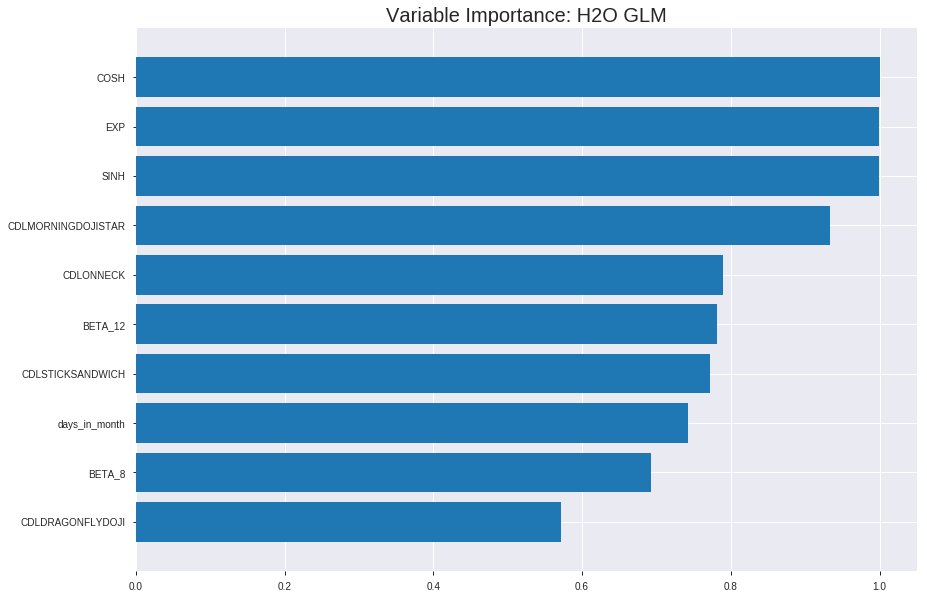

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_124458_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.248473012692644
RMSE: 0.4984706738541837
LogLoss: 0.6900821468819709
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2409.7685981527216
Residual deviance: 2402.866035443023
AIC: 2504.866035443023
AUC: 0.5472319574676312
pr_auc: 0.5688146945473908
Gini: 0.0944639149352624
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.503769808887687: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      24   806   0.9711   (806.0/830.0)
1      1    910   0.0011   (1.0/911.0)
Total  25   1716  0.4635   (807.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.50377      0.692805  375
max f2                       0.50377      0.848881  375
max f0point5                 0.513291     0.586988  337
max accuracy                 0.518718     0.545663  274
max precision                0.571272     1         0
max recall                   0.491617     1         388
max specificity              0.571272     1         0
max absolute_mcc             0.50377      0.116787  375
max min_per_class_accuracy   0.523602     0.535675  191
max mean_per_class_accuracy  0.523481     0.539698  193

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 52.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.541112           1.38023   1.38023            0.722222         0.54781   0.722222                    0.54781             0.01427         0.01427                    38.0229   38.0229
    2        0.0201034                   0.537144           1.12417   1.25586            0.588235         0.538166  0.657143                    0.543126            0.0109769       0.025247                   12.4169   25.5857
    3        0.0304423                   0.535783           1.4864    1.33415            0.777778         0.536439  0.698113                    0.540855            0.0153677       0.0406147                  48.6401   33.4155
    4        0.0402068                   0.534898           0.786918  1.20125            0.411765         0.535267  0.628571                    0.539498            0.00768386      0.0482986                  -21.3082  20.1255
    5        0.0505457                   0.534216           1.38023   1.23786            0.722222         0.534528  0.647727                    0.538481            0.01427         0.0625686                  38.0229   23.7863
    6        0.100517                    0.531762           1.12029   1.17941            0.586207         0.532852  0.617143                    0.535683            0.0559824       0.118551                   12.0292   17.9414
    7        0.150488                    0.529962           1.12029   1.15978            0.586207         0.530852  0.60687                     0.534078            0.0559824       0.174533                   12.0292   15.9782
    8        0.20046                     0.528515           0.988493  1.11708            0.517241         0.529311  0.584527                    0.53289             0.0493963       0.22393                    -1.15069  11.7082
    9        0.300402                    0.526575           0.955543  1.06334            0.5              0.527523  0.556405                    0.531104            0.0954995       0.319429                   -4.44566  6.33389
    10       0.400345                    0.524937           1.07636   1.06659            0.563218         0.525699  0.558106                    0.529755            0.107574        0.427003                   7.63592   6.65893
    11       0.500287                    0.523591           1.07636   1.06854            0.563218         0.524254  0.559127                    0.528656            0.107574        0.534577                   7.63592   6.8541
    12       0.60023                     0.522048           0.889644  1.03875            0.465517         0.52279   0.543541                    0.527679            0.0889133       0.623491                   -11.0356  3.87534
    13       0.700172                    0.520545           0.966527  1.02844            0.505747         0.521263  0.538146                    0.526763            0.0965971       0.720088                   -3.34734  2.84437
    14       0.800115                    0.518573           1.08734   1.0358             0.568966         0.519612  0.541996                    0.52587             0.108672        0.82876                    8.73424   3.58008
    15       0.900057                    0.516036           0.91161   1.02201            0.477011         0.517365  0.53478                     0.524926            0.0911087       0.919868                   -8.83897  2.20106
    16       1                           0.347135           0.801778  1                  0.41954          0.508284  0.523262                    0.523262          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.34661210180079927
RMSE: 0.5887377190233349
LogLoss: 6.204915992375046
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 689.5913742505304
Residual deviance: 100244.67470665771
AIC: 100346.67470665771
AUC: 0.5181580265262273
pr_auc: 0.546110622639702
Gini: 0.036316053052454667
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.2177161944551487e-53: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    239  1        (239.0/239.0)
1      0    259  0        (0.0/259.0)
Total  0    498  0.4799   (239.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.21772e-53  0.68428   357
max f2                       2.21772e-53  0.844198  357
max f0point5                 2.21772e-53  0.5753    357
max accuracy                 0.51984      0.526104  237
max precision                0.572923     1         0
max recall                   2.21772e-53  1         357
max specificity              0.572923     1         0
max absolute_mcc             0.539016     0.096741  4
max min_per_class_accuracy   0.518611     0.518828  248
max mean_per_class_accuracy  0.525162     0.53084   164

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 31.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.538602           1.92278   1.92278            1                0.548835     1                           0.548835            0.019305        0.019305                   92.278     92.278
    2        0.0200803                   0.53663            0.384556  1.15367            0.2              0.537845     0.6                         0.54334             0.003861        0.023166                   -61.5444   15.3668
    3        0.0301205                   0.535559           1.53822   1.28185            0.8              0.536221     0.666667                    0.540967            0.015444        0.03861                    53.8224    28.1853
    4        0.0401606                   0.534211           1.15367   1.24981            0.6              0.534745     0.65                        0.539412            0.011583        0.0501931                  15.3668    24.9807
    5        0.0502008                   0.533795           0.769112  1.15367            0.4              0.534025     0.6                         0.538334            0.00772201      0.0579151                  -23.0888   15.3668
    6        0.100402                    0.531775           1.15367   1.15367            0.6              0.532632     0.6                         0.535483            0.0579151       0.11583                    15.3668    15.3668
    7        0.150602                    0.530116           0.769112  1.02548            0.4              0.53099      0.533333                    0.533986            0.03861         0.15444                    -23.0888   2.54826
    8        0.200803                    0.528755           0.922934  0.999846           0.48             0.529499     0.52                        0.532864            0.046332        0.200772                   -7.70656   -0.015444
    9        0.301205                    0.525875           1.19212   1.06394            0.62             0.527241     0.553333                    0.53099             0.119691        0.320463                   19.2124    6.39382
    10       0.399598                    0.522969           1.02025   1.05318            0.530612         0.52454      0.547739                    0.529402            0.100386        0.420849                   2.02506    5.3181
    11       0.5                         0.518819           0.96139   1.03475            0.5              0.521108     0.538153                    0.527736            0.0965251       0.517375                   -3.861     3.4749
    12       0.600402                    0.330917           0.999846  1.02891            0.52             0.487163     0.535117                    0.520951            0.100386        0.617761                   -0.015444  2.89123
    13       0.698795                    1.06562e-17        0.824049  1.00007            0.428571         0.0664643    0.520115                    0.456957            0.0810811       0.698842                   -17.5951   0.0066569
    14       1                           0                  0.999846  1                  0.52             4.58575e-22  0.52008                     0.31932             0.301158        1                          -0.015444  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 12:44:58  0.000 sec   2            2.6       51            1.38016           201.295
    2019-08-28 12:44:58  0.020 sec   4            1.6       51            1.37851           204.707
    2019-08-28 12:44:58  0.047 sec   6            1         51            1.37651           208.144
    2019-08-28 12:44:58  0.075 sec   8            0.63      51            1.37424           211.006
    2019-08-28 12:44:58  0.103 sec   10           0.39      51            1.37189           214.013

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5381526104417671)

('F1', 0.6997389033942559)

('auc', 0.5255029201817002)

('logloss', 18.16013824191227)

('mean_per_class_error', 0.4744970798182998)

('rmse', 0.733565174309404)

('mse', 0.5381178649595864)

glm prediction progress: |████████████████████████████████████████████████| 100%


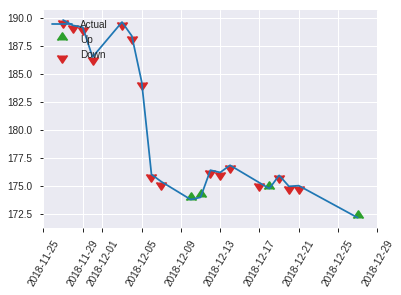


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5381178649595864
RMSE: 0.733565174309404
LogLoss: 18.16013824191227
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 343.95763235704146
Residual deviance: 175891.0355532173
AIC: 175993.0355532173
AUC: 0.5255029201817002
pr_auc: 0.7187577245727759
Gini: 0.05100584036340039
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.2057860615768994e-51: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    134  0        (0.0/134.0)
Total  0    249  0.4618   (115.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.20579e-51  0.699739   9
max f2                       1.20579e-51  0.853503   9
max f0point5                 1.20579e-51  0.59292    9
max accuracy                 1.20579e-51  0.538153   9
max precision                0.00336806   1          0
max recall                   1.20579e-51  1          9
max specificity              0.00336806   1          0
max absolute_mcc             6.69213e-34  0.136237   8
max min_per_class_accuracy   6.69213e-34  0.0597015  8
max mean_per_class_accuracy  6.69213e-34  0.525503   8

Gains/Lift Table: Avg response rate: 53.82 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.000138576        1.85821   1.85821            1                0.00144369   1                           0.00144369          0.0223881       0.0223881                  85.8209   85.8209
    2        0.0200803                   2.71404e-12        0.929104  1.48657            0.5              3.51576e-07  0.8                         0.000866353         0.00746269      0.0298507                  -7.08955  48.6567
    3        0.0321285                   3.3433e-23         1.85821   1.62593            1                1.13526e-14  0.875                       0.00054147          0.0223881       0.0522388                  85.8209   62.5933
    4        0.0401606                   2.31511e-50        1.85821   1.67239            1                3.34607e-34  0.9                         0.000433176         0.0149254       0.0671642                  85.8209   67.2388
    5        0.0522088                   1.32457e-82        0.619403  1.42939            0.333333         1.69627e-60  0.769231                    0.000333213         0.00746269      0.0746269                  -38.0597  42.9392
    6        1                           0                  0.976347  1                  0.525424         2.34266e-93  0.538153                    1.73966e-05         0.925373        1                          -2.36529  0

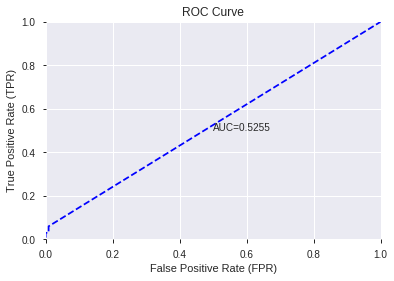

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


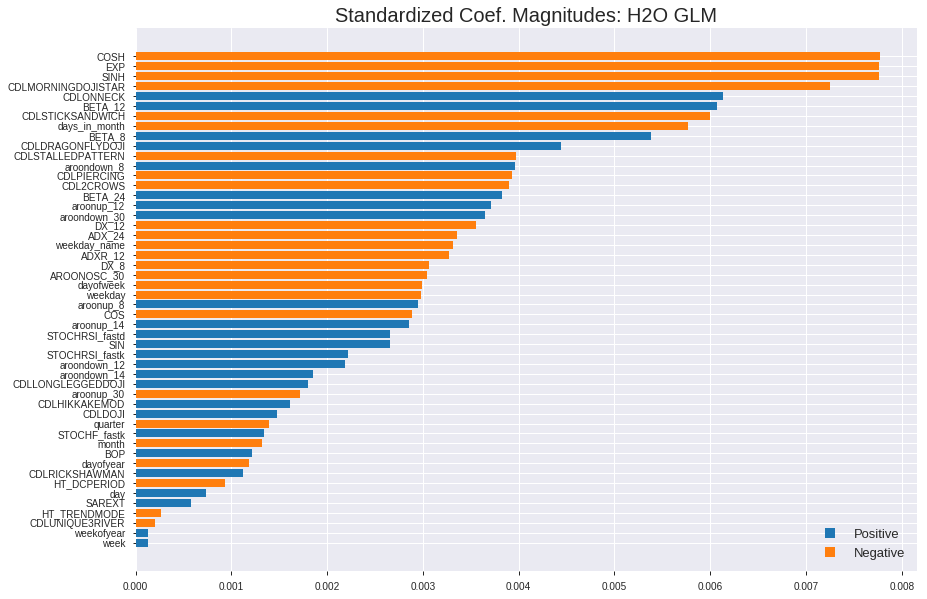

'log_likelihood'
--2019-08-28 12:45:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_124458_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_124458_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['COSH',
 'EXP',
 'SINH',
 'CDLMORNINGDOJISTAR',
 'CDLONNECK',
 'BETA_12',
 'CDLSTICKSANDWICH',
 'days_in_month',
 'BETA_8',
 'CDLDRAGONFLYDOJI',
 'CDLSTALLEDPATTERN',
 'aroondown_8',
 'CDLPIERCING',
 'CDL2CROWS',
 'BETA_24',
 'aroonup_12',
 'aroondown_30',
 'DX_12',
 'ADX_24',
 'weekday_name',
 'ADXR_12',
 'DX_8',
 'AROONOSC_30',
 'dayofweek',
 'weekday',
 'aroonup_8',
 'COS',
 'aroonup_14',
 'STOCHRSI_fastd',
 'SIN',
 'STOCHRSI_fastk',
 'aroondown_12',
 'aroondown_14',
 'CDLLONGLEGGEDDOJI',
 'aroonup_30',
 'CDLHIKKAKEMOD',
 'CDLDOJI',
 'quarter',
 'STOCHF_fastk',
 'month',
 'BOP',
 'dayofyear',
 'CDLRICKSHAWMAN',
 'HT_DCPERIOD',
 'day',
 'SAREXT',
 'HT_TRENDMODE',
 'CDLUNIQUE3RIVER',
 'weekofyear',
 'week']

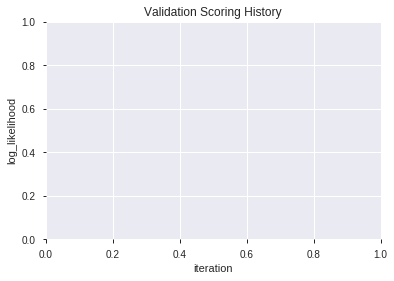

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_124514_model_1  0.578196  0.777163              0.476411  0.537963  0.289404
1  XGBoost_grid_1_AutoML_20190828_124514_model_6  0.567489  0.746292              0.500000  0.524361  0.274954
2  XGBoost_grid_1_AutoML_20190828_124514_model_2  0.548929  0.696104              0.445360  0.501486  0.251488
3  XGBoost_grid_1_AutoML_20190828_124514_model_4  0.547891  0.687105              0.495652  0.497014  0.247023
4               XGBoost_3_AutoML_20190828_124514  0.529072  0.756783              0.500000  0.529351  0.280213
5               XGBoost_2_AutoML_20190828_124514  0.519014  0.697184              0.477028  0.501946  0.251950
6  XGBoost_grid_1_AutoML_20190828_124514_model_7  0.515185  0.736723              0.500000  0.519959  0.270358
7  XGBoost_grid_1_AutoML_20190828_124514_model_5  0.510707  0.819527              0.477644  0.553443  0.306300
8               XGBoost_1_AutoML_20190828_124514  0.496431  0.734385              0.495652  0.519304  0.269676
9  XGBoost_grid_1_AutoML_20190828_124514_model_3  0.481895  0.758725              0.495652  0.530064  0.280968

variable  relative_importance  scaled_importance  percentage
0              BOP           246.741486           1.000000    0.085963
1      HT_DCPERIOD           219.968811           0.891495    0.076636
2   STOCHRSI_fastd           194.965897           0.790163    0.067925
3           ADX_24           185.086182           0.750122    0.064483
4     STOCHF_fastk           161.560791           0.654778    0.056287
5          ADXR_12           159.376953           0.645927    0.055526
6             COSH           156.859467           0.635724    0.054649
7             DX_8           149.526367           0.606004    0.052094
8              day           142.894897           0.579128    0.049784
9            DX_12           124.763451           0.505644    0.043467
10             SIN           121.778610           0.493547    0.042427
11         BETA_24           118.463966           0.480114    0.041272
12             COS            97.064308           0.393385    0.033817
13            week            90.942421           0.368574    0.031684
14       aroonup_8            88.492340           0.358644    0.030830
15         BETA_12            75.461792           0.305833    0.026290
16          SAREXT            71.142021           0.288326    0.024785
17          BETA_8            69.825920           0.282992    0.024327
18       dayofyear            57.168434           0.231694    0.019917
19     AROONOSC_30            45.963039           0.186280    0.016013
20  STOCHRSI_fastk            39.082092           0.158393    0.013616
21    aroondown_30            33.685223           0.136520    0.011736
22       dayofweek            29.807747           0.120806    0.010385
23    aroondown_14            26.105724           0.105802    0.009095
24     aroondown_8            24.910410           0.100958    0.008679
25      aroonup_30            20.710657           0.083937    0.007215
26   days_in_month            20.142773           0.081635    0.007018
27      aroonup_12            19.821033           0.080331    0.006906
28      weekofyear            17.726692           0.071843    0.006176
29      aroonup_14            16.850771           0.068293    0.005871
30             EXP            15.453434           0.062630    0.005384
31    weekday_name            15.316090           0.062073    0.005336
32    aroondown_12             8.748708           0.035457    0.003048
33           month             3.910926           0.015850    0.001363

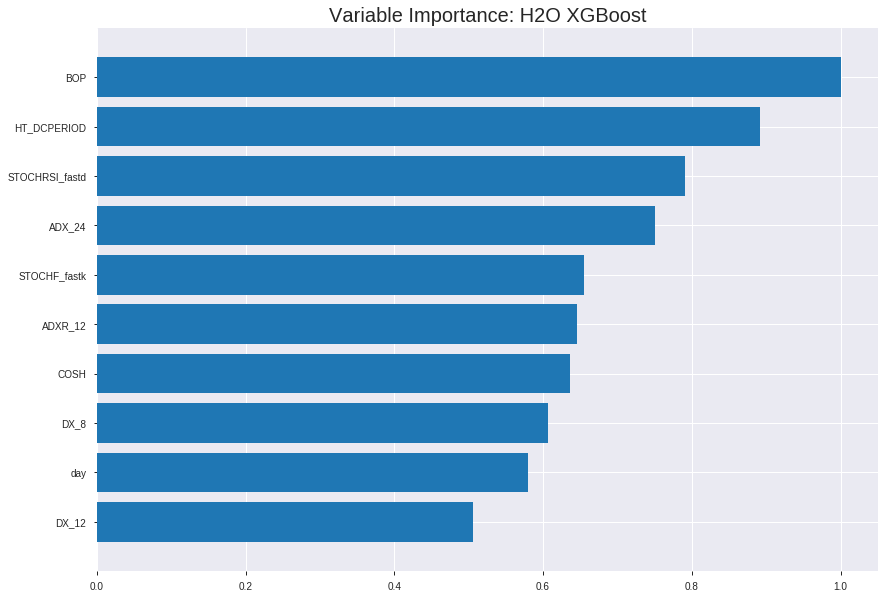

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_124514_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21021469481851202
RMSE: 0.45849176090581173
LogLoss: 0.6118194039370428
Mean Per-Class Error: 0.2335967360110034
AUC: 0.8507115178606853
pr_auc: 0.8598719407670058
Gini: 0.7014230357213707
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.499814011156559: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      526  304   0.3663   (304.0/830.0)
1      118  793   0.1295   (118.0/911.0)
Total  644  1097  0.2424   (422.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499814     0.789841  227
max f2                       0.465556     0.872477  276
max f0point5                 0.549821     0.805694  160
max accuracy                 0.526513     0.763929  191
max precision                0.79142      1         0
max recall                   0.300862     1         388
max specificity              0.79142      1         0
max absolute_mcc             0.539224     0.538797  175
max min_per_class_accuracy   0.522487     0.756312  197
max mean_per_class_accuracy  0.539224     0.766403  175

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 52.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0103389                   0.719465           1.91109   1.91109            1                0.749182  1                           0.749182            0.0197585       0.0197585                  91.1087     91.1087
    2        0.0201034                   0.689924           1.91109   1.91109            1                0.705485  1                           0.727958            0.0186608       0.0384193                  91.1087     91.1087
    3        0.0304423                   0.668678           1.91109   1.91109            1                0.680112  1                           0.711708            0.0197585       0.0581778                  91.1087     91.1087
    4        0.0402068                   0.655862           1.79867   1.88379            0.941176         0.66286   0.985714                    0.699845            0.0175631       0.0757409                  79.867      88.3785
    5        0.0505457                   0.646722           1.91109   1.88937            1                0.651177  0.988636                    0.68989             0.0197585       0.0954995                  91.1087     88.937
    6        0.100517                    0.61742            1.71339   1.80188            0.896552         0.630025  0.942857                    0.660129            0.0856202       0.18112                    71.3388     80.1882
    7        0.150488                    0.597237           1.71339   1.7725             0.896552         0.606369  0.927481                    0.642277            0.0856202       0.26674                    71.3388     77.2496
    8        0.20046                     0.581948           1.71339   1.75776            0.896552         0.590204  0.919771                    0.629296            0.0856202       0.35236                    71.3388     75.7762
    9        0.300402                    0.561149           1.65847   1.72473            0.867816         0.570674  0.902486                    0.609793            0.165752        0.518112                   65.8472     72.4728
    10       0.400345                    0.541917           1.32897   1.62593            0.695402         0.550704  0.850789                    0.595042            0.132821        0.650933                   32.8974     62.5932
    11       0.500287                    0.523658           0.999476  1.50078            0.522989         0.533393  0.785304                    0.582726            0.0998902       0.750823                   -0.0523613  50.0785
    12       0.60023                     0.505953           0.889644  1.39903            0.465517         0.51488   0.732057                    0.571429            0.0889133       0.839737                   -11.0356    39.9025
    13       0.700172                    0.485319           0.768828  1.30907            0.402299         0.495439  0.684988                    0.560582            0.0768386       0.916575                   -23.1172    30.9071
    14       0.800115                    0.460442           0.450314  1.2018             0.235632         0.472523  0.628859                    0.549583            0.0450055       0.961581                   -54.9686    20.1803
    15       0.900057                    0.423202           0.263598  1.09762            0.137931         0.443668  0.574346                    0.537822            0.0263447       0.987925                   -73.6402    9.76248
    16       1                           0.243839           0.120816  1                  0.0632184        0.373169  0.523262    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2721521384109559
RMSE: 0.521682028069739
LogLoss: 0.741046528195695
Mean Per-Class Error: 0.48386132695756123
AUC: 0.49198720537632673
pr_auc: 0.5142647787036283
Gini: -0.01602558924734654
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23387932777404785: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    236  0.9874   (236.0/239.0)
1      0    259  0        (0.0/259.0)
Total  3    495  0.4739   (236.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.233879     0.687003   396
max f2                       0.233879     0.845852   396
max f0point5                 0.233879     0.578383   396
max accuracy                 0.300273     0.526104   337
max precision                0.734651     1          0
max recall                   0.233879     1          396
max specificity              0.734651     1          0
max absolute_mcc             0.271524     0.0989778  375
max min_per_class_accuracy   0.450728     0.506276   201
max mean_per_class_accuracy  0.326022     0.516139   289

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 43.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.664541           1.15367   1.15367            0.6              0.701301  0.6                         0.701301            0.011583        0.011583                   15.3668    15.3668
    2        0.0200803                   0.635746           1.53822   1.34595            0.8              0.65332   0.7                         0.677311            0.015444        0.027027                   53.8224    34.5946
    3        0.0301205                   0.620693           0.769112  1.15367            0.4              0.628027  0.6                         0.660883            0.00772201      0.034749                   -23.0888   15.3668
    4        0.0401606                   0.61565            0.769112  1.05753            0.4              0.618524  0.55                        0.650293            0.00772201      0.042471                   -23.0888   5.7529
    5        0.0502008                   0.610197           0.384556  0.922934           0.2              0.613447  0.48                        0.642924            0.003861        0.046332                   -61.5444   -7.70656
    6        0.100402                    0.584741           0.999846  0.96139            0.52             0.599388  0.5                         0.621156            0.0501931       0.0965251                  -0.015444  -3.861
    7        0.150602                    0.564809           1.15367   1.02548            0.6              0.573997  0.533333                    0.605436            0.0579151       0.15444                    15.3668    2.54826
    8        0.200803                    0.554409           0.922934  0.999846           0.48             0.559832  0.52                        0.594035            0.046332        0.200772                   -7.70656   -0.015444
    9        0.301205                    0.528226           0.884479  0.96139            0.46             0.539651  0.5                         0.575907            0.0888031       0.289575                   -11.5521   -3.861
    10       0.399598                    0.496775           0.94177   0.956559           0.489796         0.512123  0.497487                    0.560202            0.0926641       0.382239                   -5.82302   -4.34411
    11       0.5                         0.452872           1.23058   1.01158            0.64             0.477192  0.526104                    0.543533            0.123552        0.505792                   23.0579    1.1583
    12       0.600402                    0.360617           0.922934  0.996759           0.48             0.404527  0.518395                    0.520288            0.0926641       0.598456                   -7.70656   -0.324118
    13       0.698795                    0.325921           1.17721   1.02217            0.612245         0.341998  0.531609                    0.495184            0.11583         0.714286                   17.7212    2.21675
    14       0.799197                    0.308048           0.769112  0.990377           0.4              0.317601  0.515075                    0.472874            0.0772201       0.791506                   -23.0888   -0.962341
    15       0.899598                    0.289062           1.0383    0.995725           0.54             0.299065  0.517857                    0.453476            0.104247        0.895753                   3.83012    -0.427468
    16       1                           0.231323           1.0383    1                  0.54             0.267002  0.52008               


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:45:18  0.018 sec   0                  0.5              0.693147            0.5             0                  1                0.476738                         0.5                0.693147              0.5               0                    1                  0.47992
    2019-08-28 12:45:18  0.139 sec   5                  0.494256         0.681695            0.656291        0.664116           1.69874          0.421022                         0.503122           0.699451              0.488433          0.507513             1.53822            0.47992
    2019-08-28 12:45:18  0.193 sec   10                 0.49143          0.67605             0.675755        0.685064           1.80492          0.422746                         0.508248           0.710164              0.482561          0.504019             1.15367            0.47992
    2019-08-28 12:45:19  0.255 sec   15                 0.48826          0.669725            0.709954        0.716321           1.91109          0.418725                         0.511698           0.717676              0.485251          0.50564              0.769112           0.47992
    2019-08-28 12:45:19  0.331 sec   20                 0.483245         0.659845            0.748549        0.751633           1.91109          0.325675                         0.514124           0.723159              0.491721          0.511879             0.769112           0.47992
    2019-08-28 12:45:19  0.410 sec   25                 0.4797           0.652864            0.761934        0.766917           1.91109          0.312464                         0.514363           0.72371               0.489467          0.512631             1.53822            0.47992
    2019-08-28 12:45:19  0.487 sec   30                 0.47643          0.646453            0.779302        0.786055           1.91109          0.292935                         0.517249           0.730362              0.484685          0.511822             1.53822            0.477912
    2019-08-28 12:45:19  0.576 sec   35                 0.471622         0.637102            0.797229        0.806152           1.91109          0.282596                         0.517815           0.731712              0.489645          0.514525             1.53822            0.475904
    2019-08-28 12:45:19  0.645 sec   40                 0.467157         0.628456            0.821654        0.829317           1.91109          0.272832                         0.519953           0.736848              0.493449          0.515852             1.53822            0.475904
    2019-08-28 12:45:19  0.718 sec   45                 0.462132         0.618802            0.837179        0.846309           1.91109          0.261344                         0.520219           0.737546              0.492755          0.515859             1.53822            0.475904
    2019-08-28 12:45:19  0.789 sec   50                 0.458492         0.611819            0.850712        0.859872           1.91109          0.242389                         0.521682           0.741047              0.491987          0.514265             1.15367            0.473896

Variable Importances: 


variable        relative_importance    scaled_importance     percentage
--------------  ---------------------  --------------------  ---------------------
BOP             246.74148559570312     1.0                   0.08596307530816026
HT_DCPERIOD     219.96881103515625     0.8914950418819514    0.07663565542214967
STOCHRSI_fastd  194.9658966064453      0.7901626114301086    0.067924808072059
ADX_24          185.086181640625       0.7501218580806347    0.0644827817764827
STOCHF_fastk    161.560791015625       0.6547775726711378    0.05628669378962339
---             ---                    ---                   ---
aroonup_14      16.850770950317383     0.06829322158628857   0.005870695350259
EXP             15.453433990478516     0.06263005976951785   0.005383872544521642
weekday_name    15.316089630126953     0.06207342714643068   0.00533602269242422
aroondown_12    8.74870777130127       0.03545697939760489   0.003047990990156196
month           3.91092586517334       0.015850297146956332  0.0013625402873005247


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5903614457831325)

('F1', 0.7043010752688172)

('auc', 0.5781959766385464)

('logloss', 0.7771627655996896)

('mean_per_class_error', 0.4146009085009734)

('rmse', 0.5379628981612636)

('mse', 0.28940407979806615)

xgboost prediction progress: |████████████████████████████████████████████| 100%


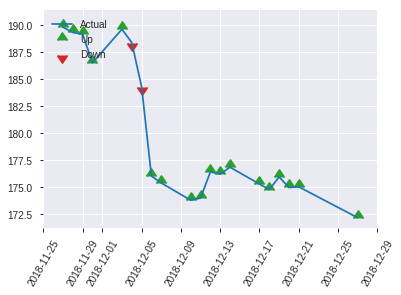


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.28940407979806615
RMSE: 0.5379628981612636
LogLoss: 0.7771627655996896
Mean Per-Class Error: 0.4146009085009734
AUC: 0.5781959766385464
pr_auc: 0.5961284973466406
Gini: 0.15639195327709277
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2659442722797394: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    107  0.9304   (107.0/115.0)
1      3    131  0.0224   (3.0/134.0)
Total  11   238  0.4418   (110.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.265944     0.704301  237
max f2                       0.235546     0.855683  246
max f0point5                 0.301254     0.62065   181
max accuracy                 0.301254     0.590361  181
max precision                0.495398     1         0
max recall                   0.235546     1         246
max specificity              0.495398     1         0
max absolute_mcc             0.329227     0.172898  102
max min_per_class_accuracy   0.319436     0.567164  124
max mean_per_class_accuracy  0.329227     0.585399  102

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 32.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.472732           1.85821   1.85821            1                0.486873  1                           0.486873            0.0223881       0.0223881                  85.8209   85.8209
    2        0.0200803                   0.432689           0.929104  1.48657            0.5              0.450257  0.8                         0.472227            0.00746269      0.0298507                  -7.08955  48.6567
    3        0.0321285                   0.419948           1.23881   1.39366            0.666667         0.427759  0.75                        0.455551            0.0149254       0.0447761                  23.8806   39.3657
    4        0.0401606                   0.412083           0         1.11493            0                0.414397  0.6                         0.447321            0               0.0447761                  -100      11.4925
    5        0.0522088                   0.40671            0.619403  1.00057            0.333333         0.40964   0.538462                    0.438625            0.00746269      0.0522388                  -38.0597  0.0574053
    6        0.100402                    0.384085           1.39366   1.18925            0.75             0.392515  0.64                        0.416492            0.0671642       0.119403                   39.3657   18.9254
    7        0.15261                     0.370708           0.714696  1.0269             0.384615         0.376712  0.552632                    0.402883            0.0373134       0.156716                   -28.5304  2.69049
    8        0.200803                    0.359541           0.929104  1.00343            0.5              0.367074  0.54                        0.394289            0.0447761       0.201493                   -7.08955  0.343284
    9        0.301205                    0.343368           1.41224   1.1397             0.76             0.35011   0.613333                    0.379563            0.141791        0.343284                   41.2239   13.9701
    10       0.401606                    0.330147           1.26358   1.17067            0.68             0.336213  0.63                        0.368725            0.126866        0.470149                   26.3582   17.0672
    11       0.502008                    0.319436           0.966269  1.12979            0.52             0.324953  0.608                       0.359971            0.0970149       0.567164                   -3.37313  12.9791
    12       0.598394                    0.3116             0.851679  1.08499            0.458333         0.315624  0.583893                    0.352828            0.0820896       0.649254                   -14.8321  8.49945
    13       0.698795                    0.303446           1.11493   1.08929            0.6              0.307545  0.586207                    0.346322            0.11194         0.761194                   11.4925   8.92949
    14       0.799197                    0.296048           0.668955  1.03649            0.36             0.300172  0.557789                    0.340524            0.0671642       0.828358                   -33.1045  3.64884
    15       0.899598                    0.284602           0.817612  1.01206            0.44             0.290008  0.544643                    0.334886            0.0820896       0.910448                   -18.2388  1.20602
    16       1                           0.225937           0.89194   1                  0.48             0.263527  0.538153                    0.327721      

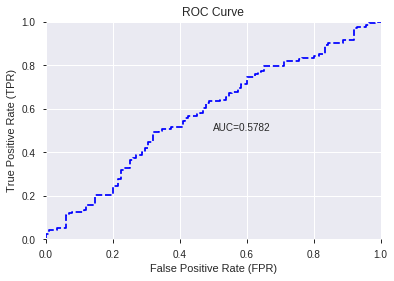

This function is available for GLM models only


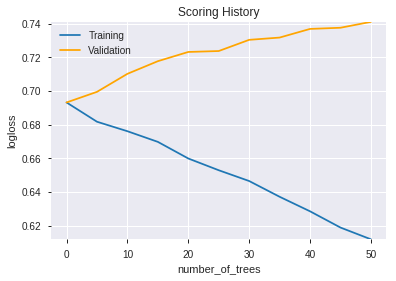

--2019-08-28 12:45:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_124514_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_124514_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'ADX_24',
 'STOCHF_fastk',
 'ADXR_12',
 'COSH',
 'DX_8',
 'day',
 'DX_12',
 'SIN',
 'BETA_24',
 'COS',
 'week',
 'aroonup_8',
 'BETA_12',
 'SAREXT',
 'BETA_8',
 'dayofyear',
 'AROONOSC_30',
 'STOCHRSI_fastk',
 'aroondown_30',
 'dayofweek',
 'aroondown_14',
 'aroondown_8',
 'aroonup_30',
 'days_in_month',
 'aroonup_12',
 'weekofyear',
 'aroonup_14',
 'EXP',
 'weekday_name',
 'aroondown_12',
 'month']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_124544_model_2  0.521804  18.314691                   0.5  0.733589  0.538152
1  DeepLearning_grid_1_AutoML_20190828_124544_model_3  0.511194  18.587133                   0.5  0.733589  0.538153
2  DeepLearning_grid_1_AutoML_20190828_124544_model_4  0.511194  18.587133                   0.5  0.733589  0.538153
3  DeepLearning_grid_1_AutoML_20190828_124544_model_6  0.510707   0.689894                   0.5  0.498374  0.248376
4  DeepLearning_grid_1_AutoML_20190828_124544_model_9  0.500000   0.690819                   0.5  0.498835  0.248837
5  DeepLearning_grid_1_AutoML_20190828_124544_model_5  0.500000   0.692065                   0.5  0.499458  0.249459
6  DeepLearning_grid_1_AutoML_20190828_124544_model_8  0.500000   0.691177                   0.5  0.499014  0.249015
7               DeepLearning_1_AutoML_20190828_124544  0.500000  15.951644                   0.5  0.679594  0.461847
8  DeepLearning_grid_1_AutoML_20190828_124544_model_1  0.485594  16.367855                   0.5  0.688402  0.473897
9  DeepLearning_grid_1_AutoML_20190828_124544_model_7  0.485594  15.911803                   0.5  0.688596  0.474164

variable  relative_importance  scaled_importance  percentage
0                      weekday             1.000000           1.000000    0.001772
1                          COS             0.993499           0.993499    0.001761
2                    dayofweek             0.956061           0.956061    0.001695
3                         COSH             0.922839           0.922839    0.001636
4                 weekday_name             0.916035           0.916035    0.001624
...                        ...                  ...                ...         ...
1036   BBANDS_upperband_14_1_2             0.457555           0.457555    0.000811
1037    BBANDS_upperband_8_1_2             0.457473           0.457473    0.000811
1038   BBANDS_middleband_8_1_4             0.456711           0.456711    0.000810
1039  BBANDS_middleband_14_5_4             0.453726           0.453726    0.000804
1040  BBANDS_middleband_20_3_5             0.448411           0.448411    0.000795

[1041 rows x 4 columns]

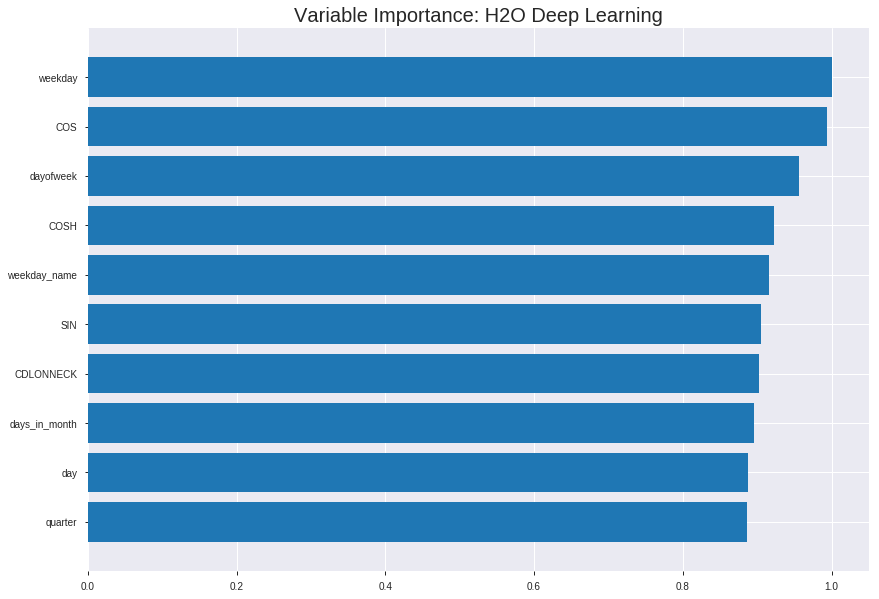

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_124544_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.27667368316596197
RMSE: 0.5259977976816652
LogLoss: 0.7609151717620688
Mean Per-Class Error: 0.4651052067766125
AUC: 0.5370478621401081
pr_auc: 0.5490720909799646
Gini: 0.07409572428021627
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09868852347951476: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    821   0.9892   (821.0/830.0)
1      0    911   0        (0.0/911.0)
Total  9    1732  0.4716   (821.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0986885    0.689368  391
max f2                       0.0986885    0.847284  391
max f0point5                 0.183017     0.582268  363
max accuracy                 0.482934     0.53992   245
max precision                0.945199     1         0
max recall                   0.0986885    1         391
max specificity              0.945199     1         0
max absolute_mcc             0.0986885    0.075521  391
max min_per_class_accuracy   0.642703     0.522503  158
max mean_per_class_accuracy  0.694211     0.534895  119

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 58.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0103389                   0.904373           0.849372  0.849372           0.444444         0.92578   0.444444                    0.92578             0.00878156      0.00878156                 -15.0628    -15.0628
    2        0.0201034                   0.875361           1.349     1.09205            0.705882         0.886829  0.571429                    0.906861            0.0131723       0.0219539                  34.9002     9.20496
    3        0.0304423                   0.847796           1.06171   1.08175            0.555556         0.858673  0.566038                    0.890495            0.0109769       0.0329308                  6.17148     8.17472
    4        0.0402068                   0.827932           0.899335  1.03745            0.470588         0.837742  0.542857                    0.877684            0.00878156      0.0417124                  -10.0665    3.74471
    5        0.0505457                   0.810832           1.16789   1.06413            0.611111         0.820347  0.556818                    0.865956            0.0120746       0.053787                   16.7886     6.41278
    6        0.100517                    0.778448           1.05439   1.05929            0.551724         0.792942  0.554286                    0.829657            0.0526894       0.106476                   5.43927     5.92881
    7        0.150488                    0.756154           1.09833   1.07225            0.574713         0.767469  0.561069                    0.809007            0.0548847       0.161361                   9.83257     7.22509
    8        0.20046                     0.734254           1.09833   1.07875            0.574713         0.744049  0.56447                     0.792814            0.0548847       0.216246                   9.83257     7.8751
    9        0.300402                    0.701119           1.13128   1.09623            0.591954         0.717491  0.573614                    0.767754            0.113063        0.329308                   13.1275     9.62257
    10       0.400345                    0.672612           0.999476  1.07207            0.522989         0.686958  0.560976                    0.747584            0.0998902       0.429199                   -0.0523613  7.2073
    11       0.500287                    0.642291           0.933577  1.04441            0.488506         0.658872  0.546498                    0.729862            0.0933041       0.522503                   -6.64232    4.44056
    12       0.60023                     0.594095           0.955543  1.02961            0.5              0.621545  0.538756                    0.711826            0.0954995       0.618002                   -4.44566    2.96094
    13       0.700172                    0.521418           0.999476  1.02531            0.522989         0.561379  0.536505                    0.690352            0.0998902       0.717892                   -0.0523613  2.53082
    14       0.800115                    0.416084           0.988493  1.02071            0.517241         0.47251   0.534099                    0.663141            0.0987925       0.816685                   -1.15069    2.07096
    15       0.900057                    0.282957           0.966527  1.01469            0.505747         0.356162  0.530951                    0.629054            0.0965971       0.913282                   -3.34734    1.46931
    16       1                           0.0114671          0.867677  1                  0.454023         0.194688  0.523262    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3885289106066712
RMSE: 0.6233208729111125
LogLoss: 6.6827018025929315
Mean Per-Class Error: 0.46660797079207117
AUC: 0.5107025734640798
pr_auc: 0.5207405292488781
Gini: 0.021405146928159535
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.67431229760255e-65: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    239  1        (239.0/239.0)
1      0    259  0        (0.0/259.0)
Total  0    498  0.4799   (239.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       4.67431e-65  0.68428    353
max f2                       4.67431e-65  0.844198   353
max f0point5                 4.67431e-65  0.5753     353
max accuracy                 0.242725     0.532129   233
max precision                0.92768      1          0
max recall                   4.67431e-65  1          353
max specificity              0.92768      1          0
max absolute_mcc             0.796682     0.0691609  43
max min_per_class_accuracy   0.196319     0.518828   249
max mean_per_class_accuracy  0.242725     0.533392   233

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 28.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.902825           1.15367   1.15367            0.6              0.910421     0.6                         0.910421            0.011583        0.011583                   15.3668    15.3668
    2        0.0200803                   0.879208           1.15367   1.15367            0.6              0.89431      0.6                         0.902366            0.011583        0.023166                   15.3668    15.3668
    3        0.0301205                   0.861512           0.384556  0.897297           0.2              0.872744     0.466667                    0.892492            0.003861        0.027027                   -61.5444   -10.2703
    4        0.0401606                   0.855449           1.15367   0.96139            0.6              0.859119     0.5                         0.884149            0.011583        0.03861                    15.3668    -3.861
    5        0.0502008                   0.842718           1.53822   1.07676            0.8              0.849069     0.56                        0.877133            0.015444        0.0540541                  53.8224    7.67568
    6        0.100402                    0.765076           0.692201  0.884479           0.36             0.807972     0.46                        0.842552            0.034749        0.0888031                  -30.7799   -11.5521
    7        0.150602                    0.662689           0.999846  0.922934           0.52             0.709118     0.48                        0.798074            0.0501931       0.138996                   -0.015444  -7.70656
    8        0.200803                    0.597041           1.23058   0.999846           0.64             0.619258     0.52                        0.75337             0.0617761       0.200772                   23.0579    -0.015444
    9        0.301205                    0.467668           1.11521   1.0383             0.58             0.529106     0.54                        0.678616            0.111969        0.312741                   11.5212    3.83012
    10       0.399598                    0.344533           1.09873   1.05318            0.571429         0.412395     0.547739                    0.613064            0.108108        0.420849                   9.87314    5.3181
    11       0.5                         0.196907           0.96139   1.03475            0.5              0.27268      0.538153                    0.544714            0.0965251       0.517375                   -3.861     3.4749
    12       0.600402                    0.0226229          0.922934  1.01605            0.48             0.115232     0.528428                    0.472894            0.0926641       0.610039                   -7.70656   1.60509
    13       0.698795                    8.17529e-34        0.902529  1.00007            0.469388         0.00209137   0.520115                    0.406603            0.0888031       0.698842                   -9.74706   0.0066569
    14       1                           0                  0.999846  1                  0.52             5.97601e-41  0.52008                     0.284132            0.301158        1                          -0.015444  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 12:47:28  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 12:47:30  1 min 43.086 sec  357 obs/sec       0.411832  1             717        0.697082         11.1983             -0.947907      0.505201        0.307599           0.989268         0.476738                         0.717919           14.9215               -1.06496         0.529693          0.563406             1.15367            0.47992
    2019-08-28 12:47:41  1 min 53.787 sec  382 obs/sec       2.57668   6             4486       0.58613          1.20413             -0.377175      0.544864        0.538865           1.16789          0.468122                         0.682935           8.33771               -0.868612        0.503853          0.51985              1.15367            0.47992
    2019-08-28 12:47:51  2 min  3.962 sec  387 obs/sec       4.64905   11            8094       0.507645         0.71576             -0.0330503     0.570782        0.578332           1.27406          0.459506                         0.629188           7.11918               -0.586069        0.515775          0.53414              1.15367            0.47992
    2019-08-28 12:48:01  2 min 13.836 sec  396 obs/sec       6.78403   16            11811      0.585401         1.01664             -0.37375       0.513504        0.53435            1.16789          0.469845                         0.676383           7.48301               -0.83293         0.526332          0.550152             1.53822            0.47992
    2019-08-28 12:48:11  2 min 24.662 sec  408 obs/sec       9.28489   22            16165      0.525998         0.760915            -0.109095      0.537048        0.549072           0.849372         0.471568                         0.623321           6.6827                -0.556626        0.510703          0.520741             1.15367            0.47992
    2019-08-28 12:48:22  2 min 35.301 sec  417 obs/sec       11.8283   28            20593      0.523023         0.752243            -0.0965844     0.530501        0.561058           1.69874          0.469845                         0.632349           7.05742               -0.602047        0.521987          0.535562             1.15367            0.47992
    2019-08-28 12:48:32  2 min 45.359 sec  426 obs/sec       14.2998   34            24896      0.519019         0.747107            -0.0798611     0.535895        0.544459           1.06171          0.470419                         0.635724           6.78101               -0.619192        0.485566          0.498126             0.769112           0.47992
    2019-08-28 12:48:42  2 min 55.219 sec  434 obs/sec       16.7858   40            29224      0.517825         0.744817            -0.0748977     0.554546        0.554511           1.16789          0.458932                         0.634321           6.99202               -0.612054        0.501115          0.50919              0.769112           0.47992
    2019-08-28 12:48:53  3 min 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
weekday                   1.0                    1.0                  0.0017724831304667663
COS                       0.9934989213943481     0.9934989213943481   0.00176096007830841
dayofweek                 0.9560612440109253     0.9560612440109253   0.0016946024267024359
COSH                      0.9228394031524658     0.9228394031524658   0.0016357172742177649
weekday_name              0.9160345196723938     0.9160345196723938   0.0016236557330445453
---                       ---                    ---                  ---
BBANDS_upperband_14_1_2   0.45755520462989807    0.45755520462989807  0.0008110088814637636
BBANDS_upperband_8_1_2    0.4574725329875946     0.4574725329875946   0.0008108623473724127
BBANDS_middleband_8_1_4   0.456711083650589      0.456711083650589    0.0008095126912678652
BBANDS_middleband_14_5_4  0.4537259042263031     0.4537259042263031   0.0008042215110969019
BBANDS_middleband_20_3_5  0.44841089844703674    0.44841089844703674  0.0007948007530148189


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5381526104417671)

('F1', 0.6997389033942559)

('auc', 0.5218040233614536)

('logloss', 18.314690728016956)

('mean_per_class_error', 0.47822842310188185)

('rmse', 0.7335887783203626)

('mse', 0.5381524956775622)

deeplearning prediction progress: |███████████████████████████████████████| 100%


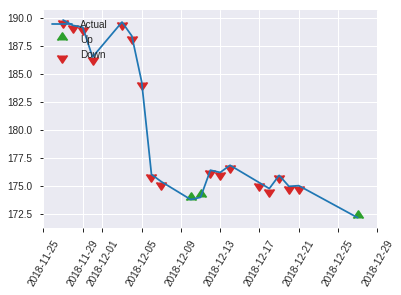


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5381524956775622
RMSE: 0.7335887783203626
LogLoss: 18.314690728016956
Mean Per-Class Error: 0.47822842310188185
AUC: 0.5218040233614536
pr_auc: 0.7109191563696149
Gini: 0.04360804672290719
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.0091019393403805e-66: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    134  0        (0.0/134.0)
Total  0    249  0.4618   (115.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.0091e-66   0.699739   8
max f2                       1.0091e-66   0.853503   8
max f0point5                 1.0091e-66   0.59292    8
max accuracy                 1.0091e-66   0.538153   8
max precision                1.36344e-05  1          0
max recall                   1.0091e-66   1          8
max specificity              1.36344e-05  1          0
max absolute_mcc             1.79773e-43  0.123103   7
max min_per_class_accuracy   1.79773e-43  0.0522388  7
max mean_per_class_accuracy  1.79773e-43  0.521772   7

Gains/Lift Table: Avg response rate: 53.82 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   2.57173e-08        1.85821   1.85821            1                4.76275e-06   1                           4.76275e-06         0.0223881       0.0223881                  85.8209   85.8209
    2        0.0200803                   5.93852e-22        0.929104  1.48657            0.5              3.55227e-13   0.8                         2.85765e-06         0.00746269      0.0298507                  -7.08955  48.6567
    3        0.0321285                   1.00673e-43        1.85821   1.62593            1                3.53378e-27   0.875                       1.78603e-06         0.0223881       0.0522388                  85.8209   62.5933
    4        0.0401606                   7.02042e-95        1.85821   1.67239            1                1.21597e-64   0.9                         1.42882e-06         0.0149254       0.0671642                  85.8209   67.2388
    5        0.0522088                   7.61035e-157       0.619403  1.42939            0.333333         1.08241e-114  0.769231                    1.0991e-06          0.00746269      0.0746269                  -38.0597  42.9392
    6        1                           0                  0.976347  1                  0.525424         2.40926e-175  0.538153                    5.73825e-08         0.925373        1                          -2.36529  0

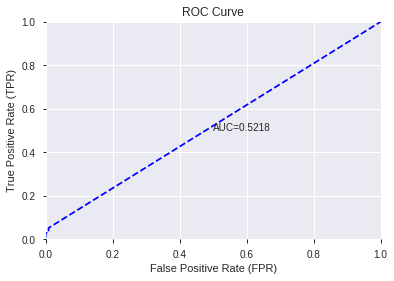

This function is available for GLM models only


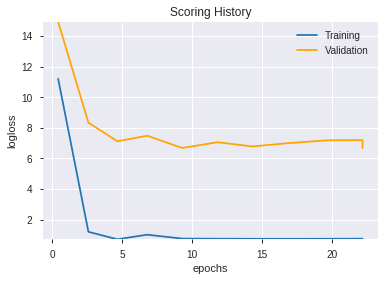

--2019-08-28 13:15:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_124544_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_124544_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['weekday',
 'COS',
 'dayofweek',
 'COSH',
 'weekday_name',
 'SIN',
 'CDLONNECK',
 'days_in_month',
 'day',
 'quarter',
 'CDLUNIQUE3RIVER',
 'aroondown_8',
 'HT_TRENDMODE',
 'BOP',
 'STOCHRSI_fastk',
 'EXP',
 'BETA_12',
 'CDLPIERCING',
 'CDLDOJI',
 'month',
 'aroondown_30',
 'aroondown_12',
 'CDL2CROWS',
 'CORREL_8',
 'CDLHIKKAKEMOD',
 'SINH',
 'weekofyear',
 'dayofyear',
 'CDLSTALLEDPATTERN',
 'HT_DCPERIOD',
 'BETA_30',
 'CDLSTICKSANDWICH',
 'BETA_8',
 'CDLLONGLEGGEDDOJI',
 'CDLINNECK',
 'week',
 'CDL3LINESTRIKE',
 'STOCHRSI_fastd',
 'CDLUPSIDEGAP2CROWS',
 'CORREL_20',
 'aroondown_14',
 'CDLTHRUSTING',
 'CDLEVENINGDOJISTAR',
 'aroonup_30',
 'CDLHIGHWAVE',
 'CDLSPINNINGTOP',
 'CORREL_30',
 'CDLSHOOTINGSTAR',
 'HT_PHASOR_quadrature',
 'STOCHF_fastk',
 'BETA_20',
 'STDDEV_8',
 'BETA_14',
 'BETA_24',
 'CORREL_12',
 'DX_24',
 'ADXR_12',
 'SAREXT',
 'aroondown_24',
 'AROONOSC_30',
 'CDLMORNINGDOJISTAR',
 'aroonup_24',
 'DX_8',
 'CDLRICKSHAWMAN',
 'CDLEVENINGSTAR',
 'aroonup_8',
 'MFI_12',
 

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_131537_model_1  0.529202  18.135526                   0.5  0.733547  0.538091

variable  relative_importance  scaled_importance  percentage
0                  CDLMARUBOZU             0.009050           1.000000    0.014117
1                         COSH             0.007047           0.778596    0.010992
2                          EXP             0.007041           0.777967    0.010983
3                         SINH             0.007035           0.777348    0.010974
4           CDLMORNINGDOJISTAR             0.006506           0.718834    0.010148
...                        ...                  ...                ...         ...
1036  BBANDS_middleband_14_2_3             0.000000           0.000000    0.000000
1037  BBANDS_middleband_14_2_4             0.000000           0.000000    0.000000
1038  BBANDS_middleband_14_2_5             0.000000           0.000000    0.000000
1039                 MAVP_24_0             0.000000           0.000000    0.000000
1040                    WMA_30             0.000000           0.000000    0.000000

[1041 rows x 4 columns]

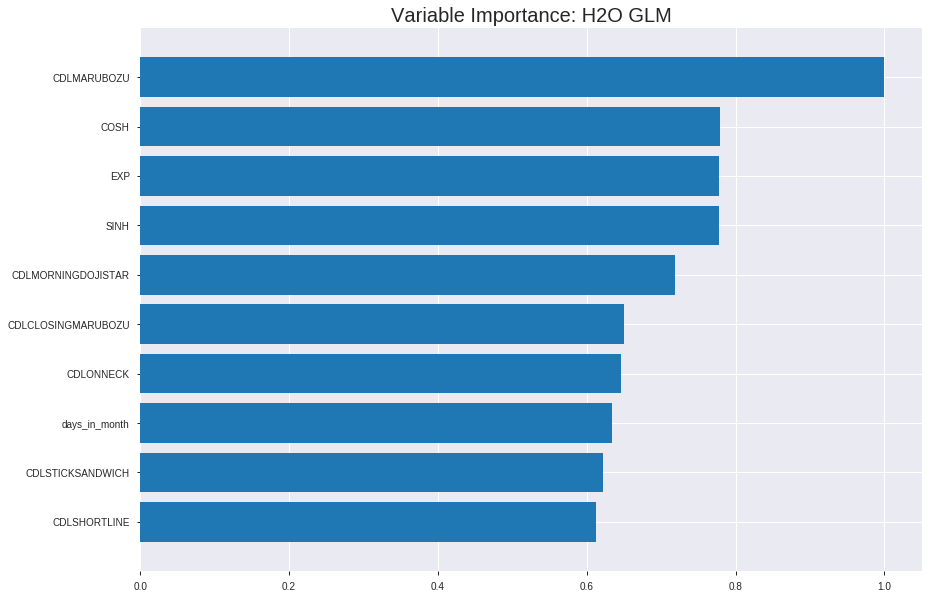

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_131537_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24674698208932067
RMSE: 0.49673633055104865
LogLoss: 0.6866172931488184
Null degrees of freedom: 1740
Residual degrees of freedom: 709
Null deviance: 2409.7685981527216
Residual deviance: 2390.8014147441854
AIC: 4454.801414744185
AUC: 0.5802375252932697
pr_auc: 0.5872685566398563
Gini: 0.16047505058653933
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48919726676388053: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      49   781   0.941    (781.0/830.0)
1      11   900   0.0121   (11.0/911.0)
Total  60   1681  0.4549   (792.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489197     0.694444  352
max f2                       0.477066     0.847948  375
max f0point5                 0.511893     0.598381  261
max accuracy                 0.516891     0.573234  235
max precision                0.575829     1         0
max recall                   0.447304     1         395
max specificity              0.575829     1         0
max absolute_mcc             0.516754     0.139094  236
max min_per_class_accuracy   0.524774     0.557629  186
max mean_per_class_accuracy  0.516891     0.565532  235

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 52.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.560151           1.59257   1.59257            0.833333         0.56545   0.833333                    0.56545             0.0164654       0.0164654                  59.2572   59.2572
    2        0.0201034                   0.555773           0.786918  1.20125            0.411765         0.557816  0.628571                    0.561742            0.00768386      0.0241493                  -21.3082  20.1255
    3        0.0304423                   0.553888           1.59257   1.33415            0.833333         0.554841  0.698113                    0.559398            0.0164654       0.0406147                  59.2572   33.4155
    4        0.0402068                   0.552482           1.23659   1.31046            0.647059         0.553222  0.685714                    0.557898            0.0120746       0.0526894                  23.6586   31.0459
    5        0.0505457                   0.551053           1.16789   1.2813             0.611111         0.551617  0.670455                    0.556614            0.0120746       0.064764                   16.7886   28.1297
    6        0.100517                    0.545738           1.14226   1.21218            0.597701         0.548004  0.634286                    0.552333            0.0570801       0.121844                   14.2259   21.2175
    7        0.150488                    0.542342           1.09833   1.17437            0.574713         0.54403   0.614504                    0.549576            0.0548847       0.176729                   9.83257   17.437
    8        0.20046                     0.538915           1.05439   1.14446            0.551724         0.540591  0.598854                    0.547336            0.0526894       0.229418                   5.43927   14.4462
    9        0.300402                    0.533406           1.04341   1.11084            0.545977         0.536003  0.581262                    0.543566            0.104281        0.333699                   4.34094   11.0842
    10       0.400345                    0.529145           1.07636   1.10223            0.563218         0.531129  0.576758                    0.540461            0.107574        0.441273                   7.63592   10.2234
    11       0.500287                    0.524786           1.15324   1.11242            0.603448         0.526781  0.58209                     0.537728            0.115258        0.556531                   15.3242   11.2424
    12       0.60023                     0.520112           0.966527  1.08813            0.505747         0.522558  0.569378                    0.535202            0.0965971       0.653128                   -3.34734  8.81307
    13       0.700172                    0.51515            1.04341   1.08175            0.545977         0.517705  0.566038                    0.532705            0.104281        0.757409                   4.34094   8.17472
    14       0.800115                    0.508719           0.878661  1.05638            0.45977          0.512057  0.552764                    0.530125            0.0878156       0.845225                   -12.1339  5.63796
    15       0.900057                    0.500256           0.922594  1.04152            0.482759         0.504917  0.54499                     0.527326            0.0922064       0.937431                   -7.74064  4.1524
    16       1                           0.329035           0.626046  1                  0.327586         0.486664  0.523262                    0.523262           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3461176002929265
RMSE: 0.5883176015494747
LogLoss: 6.172769393017873
Null degrees of freedom: 497
Residual degrees of freedom: -534
Null deviance: 689.5913742505304
Residual deviance: 99710.34533317781
AIC: 101774.34533317781
AUC: 0.5173664399605822
pr_auc: 0.5315367504644222
Gini: 0.03473287992116436
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.1182192067277904e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    239  1        (239.0/239.0)
1      0    259  0        (0.0/259.0)
Total  0    498  0.4799   (239.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.11822e-48  0.68428    358
max f2                       1.11822e-48  0.844198   358
max f0point5                 1.11822e-48  0.5753     358
max accuracy                 0.501507     0.532129   237
max precision                0.567692     1          0
max recall                   1.11822e-48  1          358
max specificity              0.567692     1          0
max absolute_mcc             0.558482     0.0747837  2
max min_per_class_accuracy   0.497579     0.528958   248
max mean_per_class_accuracy  0.501507     0.533069   237

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 31.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.553562           1.15367   1.15367            0.6              0.560883     0.6                         0.560883            0.011583        0.011583                   15.3668    15.3668
    2        0.0200803                   0.548804           0.769112  0.96139            0.4              0.550698     0.5                         0.555791            0.00772201      0.019305                   -23.0888   -3.861
    3        0.0301205                   0.547138           0.769112  0.897297           0.4              0.547811     0.466667                    0.553131            0.00772201      0.027027                   -23.0888   -10.2703
    4        0.0401606                   0.545568           1.15367   0.96139            0.6              0.546371     0.5                         0.551441            0.011583        0.03861                    15.3668    -3.861
    5        0.0502008                   0.544533           0.769112  0.922934           0.4              0.545001     0.48                        0.550153            0.00772201      0.046332                   -23.0888   -7.70656
    6        0.100402                    0.538069           1.23058   1.07676            0.64             0.541287     0.56                        0.54572             0.0617761       0.108108                   23.0579    7.67568
    7        0.150602                    0.533846           0.769112  0.974208           0.4              0.536014     0.506667                    0.542485            0.03861         0.146718                   -23.0888   -2.57915
    8        0.200803                    0.530086           1.07676   0.999846           0.56             0.532173     0.52                        0.539907            0.0540541       0.200772                   7.67568    -0.015444
    9        0.301205                    0.523638           1.15367   1.05112            0.6              0.526558     0.546667                    0.535457            0.11583         0.316602                   15.3668    5.11197
    10       0.399598                    0.512896           1.09873   1.06284            0.571429         0.518509     0.552764                    0.531284            0.108108        0.42471                    9.87314    6.28432
    11       0.5                         0.497578           1.0383    1.05792            0.54             0.506        0.550201                    0.526207            0.104247        0.528958                   3.83012    5.79151
    12       0.600402                    0.331722           0.884479  1.02891            0.46             0.464114     0.535117                    0.515823            0.0888031       0.617761                   -11.5521   2.89123
    13       0.698795                    3.14694e-16        0.824049  1.00007            0.428571         0.0702989    0.520115                    0.453092            0.0810811       0.698842                   -17.5951   0.0066569
    14       1                           0                  0.999846  1                  0.52             2.99605e-20  0.52008                     0.316618            0.301158        1                          -0.015444  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 13:15:41  0.000 sec   2            2.7       1032          1.37323           200.222
    2019-08-28 13:15:43  2.386 sec   4            2         1039          1.37049           202.691
    2019-08-28 13:15:45  4.754 sec   6            1.4       1042          1.36726           204.83
    2019-08-28 13:15:48  7.185 sec   8            1.1       1042          1.36351           207.099
    2019-08-28 13:15:50  9.479 sec   10           0.77      1042          1.35929           209.067

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5381526104417671)

('F1', 0.6997389033942559)

('auc', 0.5292018170019468)

('logloss', 18.135526003244653)

('mean_per_class_error', 0.47076573653471765)

('rmse', 0.7335470133915327)

('mse', 0.5380912208556374)

glm prediction progress: |████████████████████████████████████████████████| 100%


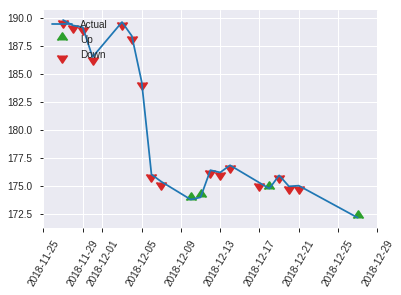


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5380912208556374
RMSE: 0.7335470133915327
LogLoss: 18.135526003244653
Null degrees of freedom: 248
Residual degrees of freedom: -783
Null deviance: 343.95763235704146
Residual deviance: 175607.8565502868
AIC: 177671.8565502868
AUC: 0.5292018170019468
pr_auc: 0.725290322626683
Gini: 0.05840363400389359
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.775133442644604e-57: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    134  0        (0.0/134.0)
Total  0    249  0.4618   (115.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       6.77513e-57  0.699739   10
max f2                       6.77513e-57  0.853503   10
max f0point5                 6.77513e-57  0.59292    10
max accuracy                 6.77513e-57  0.538153   10
max precision                0.00572869   1          0
max recall                   6.77513e-57  1          10
max specificity              0.00572869   1          0
max absolute_mcc             9.1143e-45   0.148465   9
max min_per_class_accuracy   9.1143e-45   0.0671642  9
max mean_per_class_accuracy  9.1143e-45   0.529234   9

Gains/Lift Table: Avg response rate: 53.82 %, avg score:  0.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.000274239        1.85821   1.85821            1                0.00255265   1                           0.00255265          0.0223881       0.0223881                  85.8209   85.8209
    2        0.0200803                   2.40766e-11        0.929104  1.48657            0.5              1.29307e-06  0.8                         0.00153211          0.00746269      0.0298507                  -7.08955  48.6567
    3        0.0321285                   3.70425e-21        1.85821   1.62593            1                2.09473e-13  0.875                       0.000957567         0.0223881       0.0522388                  85.8209   62.5933
    4        0.0401606                   7.29144e-46        1.85821   1.67239            1                4.16113e-31  0.9                         0.000766054         0.0149254       0.0671642                  85.8209   67.2388
    5        0.0522088                   5.01584e-75        0.619403  1.42939            0.333333         5.39752e-55  0.769231                    0.000589272         0.00746269      0.0746269                  -38.0597  42.9392
    6        1                           0                  0.976347  1                  0.525424         6.02479e-85  0.538153                    3.07652e-05         0.925373        1                          -2.36529  0

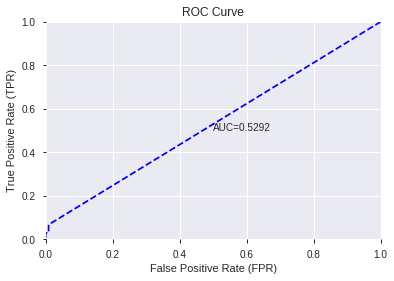

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


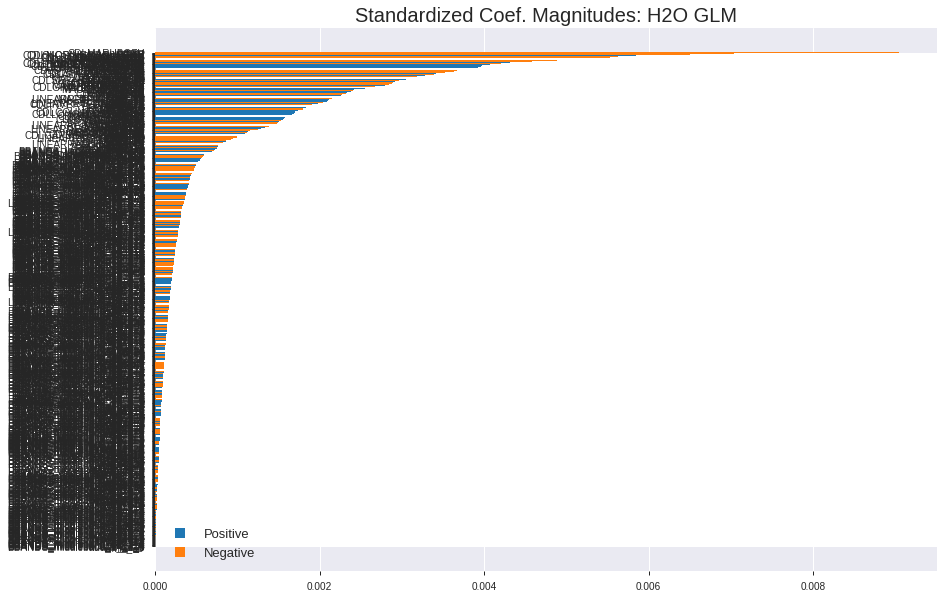

'log_likelihood'
--2019-08-28 13:16:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_131537_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_131537_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLMARUBOZU',
 'COSH',
 'EXP',
 'SINH',
 'CDLMORNINGDOJISTAR',
 'CDLCLOSINGMARUBOZU',
 'CDLONNECK',
 'days_in_month',
 'CDLSTICKSANDWICH',
 'CDLSHORTLINE',
 'CDLLADDERBOTTOM',
 'CDL3OUTSIDE',
 'BETA_12',
 'CDLHOMINGPIGEON',
 'CDLMORNINGSTAR',
 'CORREL_8',
 'is_quarter_end',
 'Volume',
 'BETA_8',
 'CORREL_30',
 'CDLTHRUSTING',
 'CDLUPSIDEGAP2CROWS',
 'CDLDARKCLOUDCOVER',
 'MACDFIX_signal_24',
 'CDLEVENINGSTAR',
 'CDL3LINESTRIKE',
 'CDLTAKURI',
 'aroondown_8',
 'CDLEVENINGDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLINNECK',
 'CCI_20',
 'MACDFIX_signal_20',
 'DX_24',
 'CDL2CROWS',
 'CDLSTALLEDPATTERN',
 'DX_30',
 'is_quarter_start',
 'CDLPIERCING',
 'TAN',
 'PLUS_DI_30',
 'MFI_30',
 'CDLSHOOTINGSTAR',
 'CDLADVANCEBLOCK',
 'aroonup_12',
 'is_month_end',
 'DX_20',
 'OBV',
 'VAR_8',
 'WILLR_20',
 'PLUS_DM_30',
 'BETA_24',
 'weekday_name',
 'MACDFIX_signal_14',
 'BETA_30',
 'CCI_24',
 'CDLHIKKAKE',
 'CDLSEPARATINGLINES',
 'PLUS_DM_24',
 'PLUS_DI_24',
 'BETA_14',
 'MACDFIX_hist_20',
 'CDLHIGHWAVE',

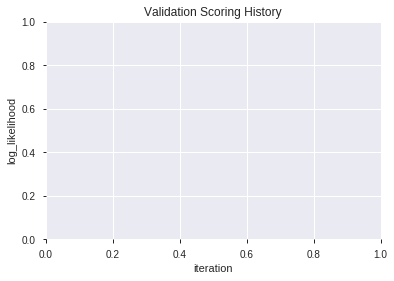

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_131628_model_5  0.571252  0.816786              0.418073  0.552286  0.305020
1  XGBoost_grid_1_AutoML_20190828_131628_model_2  0.568689  0.687882              0.486340  0.497379  0.247386
2               XGBoost_3_AutoML_20190828_131628  0.568527  0.730113              0.491304  0.517614  0.267924
3  XGBoost_grid_1_AutoML_20190828_131628_model_1  0.554640  0.768822              0.472680  0.534514  0.285705
4  XGBoost_grid_1_AutoML_20190828_131628_model_4  0.550681  0.687556              0.477644  0.497207  0.247215
5               XGBoost_2_AutoML_20190828_131628  0.543543  0.698958              0.455289  0.502887  0.252896
6  XGBoost_grid_1_AutoML_20190828_131628_model_6  0.525049  0.732368              0.490688  0.518202  0.268533
7               XGBoost_1_AutoML_20190828_131628  0.508955  0.722992              0.495036  0.514050  0.264247
8  XGBoost_grid_1_AutoML_20190828_131628_model_7  0.501103  0.743544              0.500000  0.523024  0.273554
9  XGBoost_grid_1_AutoML_20190828_131628_model_3  0.497145  0.784957              0.495652  0.540810  0.292476

variable  relative_importance  scaled_importance  percentage
0                        BOP           504.478455           1.000000    0.021950
1                     Volume           437.443634           0.867121    0.019033
2                        day           381.598419           0.756422    0.016603
3                       Open           326.200073           0.646609    0.014193
4       HT_PHASOR_quadrature           256.181091           0.507814    0.011146
..                       ...                  ...                ...         ...
619  BBANDS_upperband_14_1_3             1.381325           0.002738    0.000060
620                  KAMA_12             1.344693           0.002666    0.000059
621  BBANDS_upperband_24_0_2             1.238458           0.002455    0.000054
622  BBANDS_upperband_12_5_2             1.003033           0.001988    0.000044
623  BBANDS_upperband_24_1_2             0.921384           0.001826    0.000040

[624 rows x 4 columns]

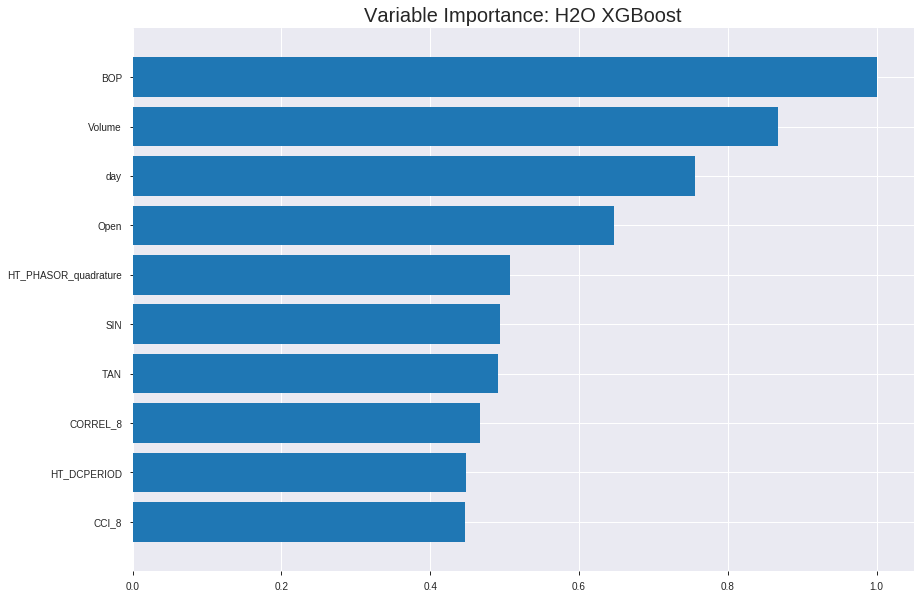

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_131628_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04554121068151311
RMSE: 0.21340386754113222
LogLoss: 0.23015171327199982
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9989023051591658
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4714375138282776: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      830  0    0        (0.0/830.0)
1      0    911  0        (0.0/911.0)
Total  830  911  0        (0.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.471438     1        203
max f2                       0.471438     1        203
max f0point5                 0.471438     1        203
max accuracy                 0.471438     1        203
max precision                0.934527     1        0
max recall                   0.471438     1        203
max specificity              0.934527     1        0
max absolute_mcc             0.471438     1        203
max min_per_class_accuracy   0.471438     1        203
max mean_per_class_accuracy  0.471438     1        203

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 52.06 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.0103389                   0.909425           1.91109  1.91109            1                0.916367  1                           0.916367            0.0197585       0.0197585                  91.1087  91.1087
    2        0.0201034                   0.899566           1.91109  1.91109            1                0.903646  1                           0.910188            0.0186608       0.0384193                  91.1087  91.1087
    3        0.0304423                   0.891015           1.91109  1.91109            1                0.895986  1                           0.905365            0.0197585       0.0581778                  91.1087  91.1087
    4        0.0402068                   0.884866           1.91109  1.91109            1                0.887324  1                           0.900983            0.0186608       0.0768386                  91.1087  91.1087
    5        0.0505457                   0.879942           1.91109  1.91109            1                0.88239   1                           0.89718             0.0197585       0.0965971                  91.1087  91.1087
    6        0.100517                    0.859878           1.91109  1.91109            1                0.870939  1                           0.884134            0.0954995       0.192097                   91.1087  91.1087
    7        0.150488                    0.845693           1.91109  1.91109            1                0.852098  1                           0.873496            0.0954995       0.287596                   91.1087  91.1087
    8        0.20046                     0.829382           1.91109  1.91109            1                0.838765  1                           0.864838            0.0954995       0.383095                   91.1087  91.1087
    9        0.300402                    0.801404           1.91109  1.91109            1                0.815127  1                           0.8483              0.190999        0.574094                   91.1087  91.1087
    10       0.400345                    0.763583           1.91109  1.91109            1                0.783584  1                           0.832144            0.190999        0.765093                   91.1087  91.1087
    11       0.500287                    0.682504           1.91109  1.91109            1                0.728143  1                           0.811368            0.190999        0.956092                   91.1087  91.1087
    12       0.60023                     0.282352           0.43933  1.66603            0.229885         0.397032  0.87177                     0.742378            0.0439078       1                          -56.067  66.6029
    13       0.700172                    0.226904           0        1.42822            0                0.24931   0.747334                    0.671997            0               1                          -100     42.822
    14       0.800115                    0.187796           0        1.24982            0                0.205912  0.653984                    0.613779            0               1                          -100     24.9821
    15       0.900057                    0.149776           0        1.11104            0                0.169473  0.581366                    0.564443            0               1                          -100     11.104
    16       1                           0.0747064          0        1                  0                0.125448  0.523262                    0.520569            0               1                 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.27434480855516347
RMSE: 0.5237793510202206
LogLoss: 0.7534396308509713
Mean Per-Class Error: 0.45112356827838007
AUC: 0.5272128075475356
pr_auc: 0.5537844810631297
Gini: 0.05442561509507127
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10737235844135284: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    239  1        (239.0/239.0)
1      0    259  0        (0.0/259.0)
Total  0    498  0.4799   (239.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.107372     0.68428   399
max f2                       0.107372     0.844198  399
max f0point5                 0.107372     0.5753    399
max accuracy                 0.396151     0.546185  227
max precision                0.71283      0.6875    30
max recall                   0.107372     1         399
max specificity              0.874651     0.995816  0
max absolute_mcc             0.565558     0.115192  102
max min_per_class_accuracy   0.419681     0.523013  209
max mean_per_class_accuracy  0.565558     0.548876  102

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 44.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.81056            0.769112  0.769112           0.4              0.848924  0.4                         0.848924            0.00772201      0.00772201                 -23.0888   -23.0888
    2        0.0200803                   0.796607           1.53822   1.15367            0.8              0.805766  0.6                         0.827345            0.015444        0.023166                   53.8224    15.3668
    3        0.0301205                   0.767874           1.15367   1.15367            0.6              0.78406   0.6                         0.812917            0.011583        0.034749                   15.3668    15.3668
    4        0.0401606                   0.738022           1.53822   1.24981            0.8              0.755207  0.65                        0.79849             0.015444        0.0501931                  53.8224    24.9807
    5        0.0502008                   0.73409            1.15367   1.23058            0.6              0.736005  0.64                        0.785993            0.011583        0.0617761                  15.3668    23.0579
    6        0.100402                    0.667871           0.999846  1.11521            0.52             0.698919  0.58                        0.742456            0.0501931       0.111969                   -0.015444  11.5212
    7        0.150602                    0.627941           1.15367   1.12803            0.6              0.647434  0.586667                    0.710782            0.0579151       0.169884                   15.3668    12.8031
    8        0.200803                    0.597036           1.23058   1.15367            0.64             0.615685  0.6                         0.687008            0.0617761       0.23166                    23.0579    15.3668
    9        0.301205                    0.528792           1.0383    1.11521            0.54             0.558497  0.58                        0.644171            0.104247        0.335907                   3.83012    11.5212
    10       0.399598                    0.482476           0.94177   1.07251            0.489796         0.507543  0.557789                    0.610529            0.0926641       0.428571                   -5.82302   7.25054
    11       0.5                         0.420836           0.922934  1.04247            0.48             0.447527  0.542169                    0.577797            0.0926641       0.521236                   -7.70656   4.2471
    12       0.600402                    0.371927           1.15367   1.06107            0.6              0.395957  0.551839                    0.547389            0.11583         0.637066                   15.3668    6.10658
    13       0.698795                    0.329375           0.627847  1.00007            0.326531         0.34991   0.520115                    0.519583            0.0617761       0.698842                   -37.2153   0.0066569
    14       0.799197                    0.289808           0.846023  0.980714           0.44             0.311279  0.51005                     0.493414            0.0849421       0.783784                   -15.3977   -1.92856
    15       0.899598                    0.241765           0.999846  0.98285            0.52             0.265886  0.511161                    0.468021            0.100386        0.88417                    -0.015444  -1.71504
    16       1                           0.107372           1.15367   1                  0.6              0.194123  0.52008                 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:17:06  19.675 sec  0                  0.5              0.693147            0.5             0                  1                0.476738                         0.5                0.693147              0.5               0                    1                  0.47992
    2019-08-28 13:17:08  21.331 sec  5                  0.452598         0.602155            0.956027        0.955211           1.91109          0.108558                         0.499707           0.692611              0.547439          0.563535             1.53822            0.477912
    2019-08-28 13:17:09  22.114 sec  10                 0.41103          0.527836            0.989737        0.989318           1.91109          0.0413555                        0.502134           0.697708              0.536671          0.567105             1.53822            0.475904
    2019-08-28 13:17:09  22.880 sec  15                 0.381179         0.477146            0.995916        0.995167           1.91109          0.0292935                        0.504516           0.703133              0.543868          0.571205             1.15367            0.477912
    2019-08-28 13:17:10  23.714 sec  20                 0.349603         0.425812            0.99865         0.997789           1.91109          0.0143596                        0.508383           0.711917              0.541881          0.573888             1.92278            0.473896
    2019-08-28 13:17:11  24.553 sec  25                 0.320007         0.379887            0.999588        0.997434           1.91109          0.00804136                       0.511081           0.718562              0.534612          0.567849             1.53822            0.47992
    2019-08-28 13:17:12  25.417 sec  30                 0.292534         0.339109            0.999941        0.99885            1.91109          0.00287191                       0.513093           0.723664              0.533869          0.567902             1.15367            0.475904
    2019-08-28 13:17:13  26.223 sec  35                 0.270661         0.307462            0.999971        0.998876           1.91109          0.00114877                       0.516342           0.732431              0.533812          0.572781             1.15367            0.477912
    2019-08-28 13:17:14  27.100 sec  40                 0.252602         0.282202            0.999992        0.998895           1.91109          0.000574383                      0.524389           0.751962              0.495493          0.501821             1.15367            0.47992
    2019-08-28 13:17:14  27.966 sec  45                 0.390523         0.475611            0.874392        0.920809           1.91109          0.243538                         0.497165           0.688009              0.558464          0.574424             1.15367            0.471888
    2019-08-28 13:17:15  28.897 sec  50                 0.213404         0.230152            1               0.998902           1.91109          0                                0.523779           0.75344               0.527213          0.553784             0.769112           0.47992

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      504.47845458984375     1.0                    0.021949943430288194
Volume                   437.4436340332031      0.8671205480695068     0.01903324697736617
day                      381.5984191894531      0.7564216384616548     0.016603412173679232
Open                     326.2000732421875      0.6466085325832162     0.014193020711743255
HT_PHASOR_quadrature     256.18109130859375     0.5078137410583307     0.011146482889353377
---                      ---                    ---                    ---
BBANDS_upperband_14_1_3  1.3813245296478271     0.002738123931914765   6.010166541064737e-05
KAMA_12                  1.3446928262710571     0.0026655109133735615  5.850781376136549e-05
BBANDS_upperband_24_0_2  1.238458275794983      0.002454927984589326   5.388553038716711e-05
BBANDS_upperband_12_5_2  1.003032922744751      0.001988257206267108   4.3642133202425876e-05
BBANDS_upperband_24_1_2  0.9213842153549194     0.001826409447166644   4.008958404585177e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.606425702811245)

('F1', 0.711764705882353)

('auc', 0.5712524334847502)

('logloss', 0.816785881409991)

('mean_per_class_error', 0.4162232316677482)

('rmse', 0.5522860832149799)

('mse', 0.3050199177129437)

xgboost prediction progress: |████████████████████████████████████████████| 100%


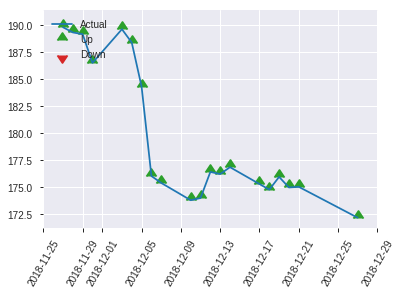


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.3050199177129437
RMSE: 0.5522860832149799
LogLoss: 0.816785881409991
Mean Per-Class Error: 0.4162232316677482
AUC: 0.5712524334847502
pr_auc: 0.5633274228698074
Gini: 0.14250486696950038
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2220080941915512: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      30   85   0.7391   (85.0/115.0)
1      13   121  0.097    (13.0/134.0)
Total  43   206  0.3936   (98.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.222008     0.711765  205
max f2                       0.151797     0.855683  246
max f0point5                 0.230038     0.631692  199
max accuracy                 0.230038     0.606426  199
max precision                0.556044     1         0
max recall                   0.151797     1         246
max specificity              0.556044     1         0
max absolute_mcc             0.222008     0.216119  205
max min_per_class_accuracy   0.285741     0.556522  125
max mean_per_class_accuracy  0.230038     0.583777  199

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 29.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0120482                   0.521801           0.619403  0.619403           0.333333         0.535583  0.333333                    0.535583            0.00746269      0.00746269                 -38.0597   -38.0597
    2        0.0200803                   0.514106           0.929104  0.743284           0.5              0.517301  0.4                         0.52827             0.00746269      0.0149254                  -7.08955   -25.6716
    3        0.0321285                   0.485317           1.85821   1.16138            1                0.496872  0.625                       0.516496            0.0223881       0.0373134                  85.8209    16.1381
    4        0.0401606                   0.47909            0         0.929104           0                0.481236  0.5                         0.509444            0               0.0373134                  -100       -7.08955
    5        0.0522088                   0.468787           0.619403  0.857635           0.333333         0.476202  0.461538                    0.501773            0.00746269      0.0447761                  -38.0597   -14.2365
    6        0.100402                    0.413722           1.23881   1.0406             0.666667         0.442907  0.56                        0.473517            0.0597015       0.104478                   23.8806    4.0597
    7        0.15261                     0.383219           1.00057   1.0269             0.538462         0.39422   0.552632                    0.446389            0.0522388       0.156716                   0.0574053  2.69049
    8        0.200803                    0.364122           1.08396   1.0406             0.583333         0.372776  0.56                        0.428722            0.0522388       0.208955                   8.39552    4.0597
    9        0.301205                    0.334144           1.11493   1.06537            0.6              0.347926  0.573333                    0.40179             0.11194         0.320896                   11.4925    6.53731
    10       0.401606                    0.30342            1.11493   1.07776            0.6              0.316576  0.58                        0.380486            0.11194         0.432836                   11.4925    7.77612
    11       0.502008                    0.287787           1.18925   1.10006            0.64             0.295399  0.592                       0.363469            0.119403        0.552239                   18.9254    10.006
    12       0.598394                    0.265263           1.00653   1.08499            0.541667         0.275927  0.583893                    0.349368            0.0970149       0.649254                   0.652985   8.49945
    13       0.698795                    0.247255           1.0406    1.07862            0.56             0.256731  0.58046                     0.336058            0.104478        0.753731                   4.0597     7.86155
    14       0.799197                    0.230045           1.18925   1.09251            0.64             0.238253  0.58794                     0.323771            0.119403        0.873134                   18.9254    9.25148
    15       0.899598                    0.196102           0.668955  1.04524            0.36             0.214843  0.5625                      0.311614            0.0671642       0.940299                   -33.1045   4.52425
    16       1                           0.135199           0.594627  1                  0.32             0.173576  0.538153                   

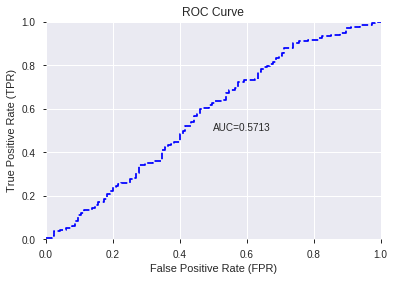

This function is available for GLM models only


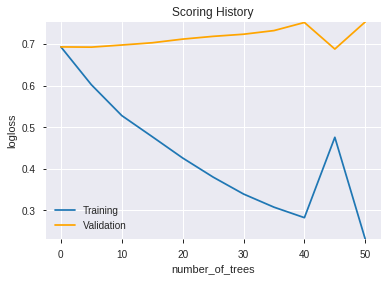

--2019-08-28 13:17:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.40.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.40.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_131628_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_131628_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'Volume',
 'day',
 'Open',
 'HT_PHASOR_quadrature',
 'SIN',
 'TAN',
 'CORREL_8',
 'HT_DCPERIOD',
 'CCI_8',
 'ADX_8',
 'dayofyear',
 'STOCH_slowk',
 'STOCHRSI_fastd',
 'High',
 'MFI_8',
 'SUB',
 'BETA_8',
 'CORREL_20',
 'COS',
 'DX_8',
 'CORREL_24',
 'STOCHF_fastk',
 'dayofweek',
 'DIV',
 'ADXR_8',
 'HT_PHASOR_inphase',
 'MOM_12',
 'BETA_14',
 'TRANGE',
 'ADX_24',
 'BETA_30',
 'CORREL_12',
 'CORREL_30',
 'MINUS_DI_8',
 'ULTOSC',
 'STOCH_slowd',
 'MACDEXT_hist',
 'OBV',
 'MOM_24',
 'DX_14',
 'ADXR_14',
 'CMO_8',
 'PLUS_DI_12',
 'MINUS_DI_12',
 'DX_30',
 'STDDEV_8',
 'CCI_12',
 'PLUS_DM_8',
 'STDDEV_30',
 'MOM_14',
 'BETA_20',
 'ROC_14',
 'CCI_20',
 'SAREXT',
 'ADXR_12',
 'MINUS_DI_14',
 'MFI_30',
 'MACDFIX_hist_12',
 'MACDFIX_hist_8',
 'WILLR_12',
 'ADX_20',
 'PLUS_DI_24',
 'CCI_14',
 'ADOSC',
 'BETA_24',
 'Close',
 'MFI_12',
 'MINUS_DM_30',
 'ATR_8',
 'CORREL_14',
 'MFI_14',
 'MFI_20',
 'MACDFIX_8',
 'LINEARREG_ANGLE_12',
 'DX_12',
 'MOM_20',
 'Low',
 'STDDEV_12',
 'PLUS_DI_30'

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

510

['BBANDS_lowerband_12_4_2',
 'BBANDS_upperband_12_4_3',
 'BBANDS_middleband_12_4_3',
 'BBANDS_lowerband_12_4_3',
 'BBANDS_upperband_12_4_4',
 'BBANDS_middleband_12_4_4',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_upperband_12_4_5',
 'BBANDS_middleband_12_4_5',
 'BBANDS_lowerband_12_4_5',
 'MA_12_5',
 'MAVP_12_5',
 'BBANDS_upperband_12_5_2',
 'BBANDS_middleband_12_5_2',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_upperband_12_5_3',
 'BBANDS_middleband_12_5_3',
 'BBANDS_lowerband_12_5_3',
 'BBANDS_upperband_12_5_4',
 'BBANDS_middleband_12_5_4',
 'BBANDS_lowerband_12_5_4',
 'BBANDS_upperband_12_5_5',
 'BBANDS_middleband_12_5_5',
 'BBANDS_lowerband_12_5_5',
 'MA_12_6',
 'MAVP_12_6',
 'BBANDS_upperband_12_6_2',
 'BBANDS_middleband_12_6_2',
 'BBANDS_lowerband_12_6_2',
 'BBANDS_upperband_12_6_3',
 'BBANDS_middleband_12_6_3',
 'BBANDS_lowerband_12_6_3',
 'BBANDS_upperband_12_6_4',
 'BBANDS_middleband_12_6_4',
 'BBANDS_lowerband_12_6_4',
 'BBANDS_upperband_12_6_5',
 'BBANDS_middleband_12_6_5',
 'BBANDS_lowe

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190828_131919_model_2  0.557430  0.767455              0.453439  0.522392  0.272894
1               DeepLearning_1_AutoML_20190828_131919  0.543868  0.875924              0.473297  0.562636  0.316560
2  DeepLearning_grid_1_AutoML_20190828_131919_model_6  0.541272  0.689901              0.440396  0.498375  0.248378
3  DeepLearning_grid_1_AutoML_20190828_131919_model_1  0.512167  3.287043              0.500000  0.666789  0.444608
4  DeepLearning_grid_1_AutoML_20190828_131919_model_4  0.510837  0.867479              0.462751  0.561535  0.315321
5  DeepLearning_grid_1_AutoML_20190828_131919_model_3  0.510383  0.761024              0.495652  0.526649  0.277360
6  DeepLearning_grid_1_AutoML_20190828_131919_model_5  0.500000  0.692493              0.500000  0.499673  0.249673
7  DeepLearning_grid_1_AutoML_20190828_131919_model_8  0.500000  0.690335              0.500000  0.498593  0.248595
8  DeepLearning_grid_1_AutoML_20190828_131919_model_9  0.473491  0.691629              0.500000  0.499240  0.249241
9  DeepLearning_grid_1_AutoML_20190828_131919_model_7  0.453342  0.695082              0.495652  0.500949  0.250950

variable  relative_importance  scaled_importance  percentage
0                         BOP             1.000000           1.000000    0.003184
1              STOCHRSI_fastk             0.989094           0.989094    0.003149
2                   CDLONNECK             0.978443           0.978443    0.003116
3                         OBV             0.971844           0.971844    0.003095
4                 aroondown_8             0.955762           0.955762    0.003043
..                        ...                  ...                ...         ...
505   BBANDS_upperband_20_0_3             0.516397           0.516397    0.001644
506                 MAVP_12_5             0.513226           0.513226    0.001634
507                   MA_14_5             0.511629           0.511629    0.001629
508  BBANDS_middleband_14_4_4             0.505165           0.505165    0.001609
509         CDLINVERTEDHAMMER             0.498079           0.498079    0.001586

[510 rows x 4 columns]

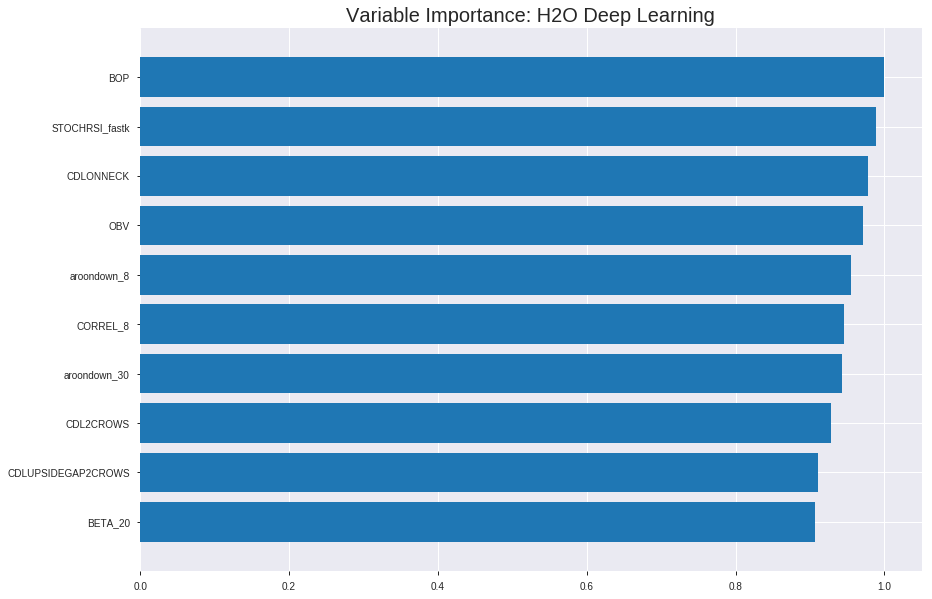

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190828_131919_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.28025602953602674
RMSE: 0.5293921321062741
LogLoss: 0.7755122002887008
Mean Per-Class Error: 0.4597423723433801
AUC: 0.5352644386547287
pr_auc: 0.5524985746766985
Gini: 0.07052887730945745
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22398428832194908: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      8    822   0.9904   (822.0/830.0)
1      2    909   0.0022   (2.0/911.0)
Total  10   1731  0.4733   (824.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.223984     0.688115   390
max f2                       0.10717      0.845868   399
max f0point5                 0.44175      0.588856   319
max accuracy                 0.5927       0.550258   242
max precision                0.958718     1          0
max recall                   0.10717      1          399
max specificity              0.958718     1          0
max absolute_mcc             0.407059     0.0983535  334
max min_per_class_accuracy   0.682609     0.520307   175
max mean_per_class_accuracy  0.5927       0.540258   242

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 65.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0103389                   0.925896           1.59257   1.59257            0.833333         0.936646  0.833333                    0.936646            0.0164654       0.0164654                  59.2572     59.2572
    2        0.0201034                   0.909417           0.899335  1.25586            0.470588         0.917761  0.657143                    0.927473            0.00878156      0.025247                   -10.0665    25.5857
    3        0.0304423                   0.895627           1.4864    1.33415            0.777778         0.90187   0.698113                    0.918778            0.0153677       0.0406147                  48.6401     33.4155
    4        0.0402068                   0.885136           0.786918  1.20125            0.411765         0.890136  0.628571                    0.911822            0.00768386      0.0482986                  -21.3082    20.1255
    5        0.0505457                   0.881008           0.849372  1.12928            0.444444         0.883136  0.590909                    0.905954            0.00878156      0.0570801                  -15.0628    12.9279
    6        0.100517                    0.840107           1.01046   1.07021            0.528736         0.860161  0.56                        0.883189            0.050494        0.107574                   1.04596     7.02086
    7        0.150488                    0.820856           0.966527  1.03578            0.505747         0.830169  0.541985                    0.865583            0.0482986       0.155873                   -3.34734    3.57798
    8        0.20046                     0.798464           1.07636   1.0459             0.563218         0.810614  0.547278                    0.85188             0.053787        0.20966                    7.63592     4.58956
    9        0.300402                    0.75586            1.03243   1.04141            0.54023          0.775984  0.544933                    0.82663             0.103183        0.312843                   3.24262     4.14144
    10       0.400345                    0.714927           1.04341   1.04191            0.545977         0.735837  0.545194                    0.803964            0.104281        0.417124                   4.34094     4.19124
    11       0.500287                    0.682165           1.02144   1.03782            0.534483         0.697727  0.543054                    0.782741            0.102086        0.51921                    2.14429     3.78232
    12       0.60023                     0.64199            0.999476  1.03144            0.522989         0.662477  0.539713                    0.762716            0.0998902       0.6191                     -0.0523613  3.14382
    13       0.700172                    0.600068           1.14226   1.04726            0.597701         0.620381  0.54799                     0.742399            0.11416         0.73326                    14.2259     4.72567
    14       0.800115                    0.539266           0.955543  1.0358             0.5              0.573103  0.541996                    0.721253            0.0954995       0.82876                    -4.44566    3.58008
    15       0.900057                    0.429439           0.97751   1.02933            0.511494         0.485683  0.538609                    0.695095            0.0976948       0.926454                   -2.24901    2.93281
    16       1                           0.10717            0.735878  1                  0.385057         0.340263  0.523262   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2744179600194342
RMSE: 0.5238491767860614
LogLoss: 0.760577746075508
Mean Per-Class Error: 0.44285229640878176
AUC: 0.5341109190481576
pr_auc: 0.5448657390820514
Gini: 0.0682218380963151
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2715759473210281: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      28   211  0.8828   (211.0/239.0)
1      7    252  0.027    (7.0/259.0)
Total  35   463  0.4378   (218.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.271576     0.698061  365
max f2                       0.182381     0.847569  388
max f0point5                 0.344566     0.599588  329
max accuracy                 0.360518     0.570281  322
max precision                0.962574     1         0
max recall                   0.122716     1         398
max specificity              0.962574     1         0
max absolute_mcc             0.271576     0.17615   365
max min_per_class_accuracy   0.546362     0.51046   205
max mean_per_class_accuracy  0.360518     0.557148  322

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 55.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.950136           1.53822   1.53822            0.8              0.957084  0.8                         0.957084            0.015444        0.015444                   53.8224    53.8224
    2        0.0200803                   0.936459           0.769112  1.15367            0.4              0.943166  0.6                         0.950125            0.00772201      0.023166                   -23.0888   15.3668
    3        0.0301205                   0.917947           1.15367   1.15367            0.6              0.93201   0.6                         0.944087            0.011583        0.034749                   15.3668    15.3668
    4        0.0401606                   0.893511           1.53822   1.24981            0.8              0.908371  0.65                        0.935158            0.015444        0.0501931                  53.8224    24.9807
    5        0.0502008                   0.874403           0         0.999846           0                0.884091  0.52                        0.924944            0               0.0501931                  -100       -0.015444
    6        0.100402                    0.821871           1.15367   1.07676            0.6              0.849956  0.56                        0.88745             0.0579151       0.108108                   15.3668    7.67568
    7        0.150602                    0.77607            0.999846  1.05112            0.52             0.799674  0.546667                    0.858192            0.0501931       0.158301                   -0.015444  5.11197
    8        0.200803                    0.728628           0.922934  1.01907            0.48             0.752988  0.53                        0.831891            0.046332        0.204633                   -7.70656   1.90734
    9        0.301205                    0.668227           1.07676   1.0383             0.56             0.696593  0.54                        0.786791            0.108108        0.312741                   7.67568    3.83012
    10       0.399598                    0.613654           1.17721   1.07251            0.612245         0.642385  0.557789                    0.751234            0.11583         0.428571                   17.7212    7.25054
    11       0.5                         0.547379           0.807568  1.01931            0.42             0.584581  0.53012                     0.71777             0.0810811       0.509653                   -19.2432   1.9305
    12       0.600402                    0.494626           0.846023  0.990328           0.44             0.520171  0.51505                     0.684726            0.0849421       0.594595                   -15.3977   -0.967188
    13       0.698795                    0.44405            1.09873   1.00559            0.571429         0.471474  0.522989                    0.654699            0.108108        0.702703                   9.87314    0.55918
    14       0.799197                    0.379116           1.34595   1.04835            0.7              0.409161  0.545226                    0.623853            0.135135        0.837838                   34.5946    4.83499
    15       0.899598                    0.291492           0.999846  1.04294            0.52             0.340517  0.542411                    0.592231            0.100386        0.938224                   -0.015444  4.29364
    16       1                           0.0884255          0.61529   1                  0.32             0.224285  0.52008                  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:20:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-28 13:20:06  46.270 sec        833 obs/sec       1.52326   1             2652       0.651765         2.30492             -0.702877      0.519739        0.442121           1.59257          0.476738                         0.616179           1.62627               -0.521159        0.529571          0.491245             1.15367            0.463855
    2019-08-28 13:20:13  53.097 sec        834 obs/sec       4.55887   3             7937       0.566527         1.03759             -0.286594      0.526748        0.535348           1.16789          0.471568                         0.683334           2.47642               -0.8708          0.491608          0.516483             0.384556           0.47992
    2019-08-28 13:20:19  59.359 sec        866 obs/sec       7.60425   5             13239      0.515376         0.731128            -0.0647549     0.529691        0.551813           1.4864           0.470994                         0.558449           0.861722              -0.249475        0.533489          0.546279             1.53822            0.465863
    2019-08-28 13:20:25  1 min  5.182 sec  900 obs/sec       10.6364   7             18518      0.553843         0.917031            -0.22963       0.526504        0.552325           1.4864           0.470419                         0.664568           2.03921               -0.769457        0.533134          0.56449              1.92278            0.461847
    2019-08-28 13:20:30  1 min 10.685 sec  933 obs/sec       13.6738   9             23806      0.529392         0.775512            -0.123456      0.535264        0.552499           1.59257          0.473291                         0.523849           0.760578              -0.0994451       0.534111          0.544866             1.53822            0.437751
    2019-08-28 13:20:38  1 min 18.141 sec  977 obs/sec       18.2361   12            31749      0.542602         0.880879            -0.180223      0.553474        0.56818            1.06171          0.476738                         0.654253           1.97161               -0.714952        0.545274          0.576603             1.92278            0.457831
    2019-08-28 13:20:45  1 min 25.194 sec  1016 obs/sec      22.7829   15            39665      0.539544         0.878103            -0.166958      0.550082        0.573341           1.69874          0.468122                         0.659199           2.03009               -0.740984        0.538562          0.554215             1.53822            0.455823
    2019-08-28 13:20:52  1 min 32.027 sec  1048 obs/sec      27.3262   18            47575      0.531305         0.861564            -0.131588      0.575839        0.60198            1.69874          0.473291                         0.647293           1.94193               -0.67866         0.548214          0.580008             1.92278            0.461847
    2019-08-28 13:20:52 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0031841744967273946
STOCHRSI_fastk            0.9890941381454468     0.9890941381454468   0.0031494483295452943
CDLONNECK                 0.9784429669380188     0.9784429669380188   0.0031155331418263247
OBV                       0.9718436598777771     0.9718436598777771   0.0030945197965890304
aroondown_8               0.9557623267173767     0.9557623267173767   0.003043314025666307
---                       ---                    ---                  ---
BBANDS_upperband_20_0_3   0.5163969993591309     0.5163969993591309   0.0016442981555458973
MAVP_12_5                 0.5132261514663696     0.5132261514663696   0.0016342016225527653
MA_14_5                   0.5116286277770996     0.5116286277770996   0.0016291148283634738
BBANDS_middleband_14_4_4  0.5051645040512085     0.5051645040512085   0.0016085319304518007
CDLINVERTEDHAMMER         0.498079389333725      0.498079389333725    0.0015859716888620018


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5823293172690763)

('F1', 0.7107438016528925)

('auc', 0.5574302401038287)

('logloss', 0.7674554692900716)

('mean_per_class_error', 0.4467878001297858)

('rmse', 0.5223923032912215)

('mse', 0.27289371853790756)

deeplearning prediction progress: |███████████████████████████████████████| 100%


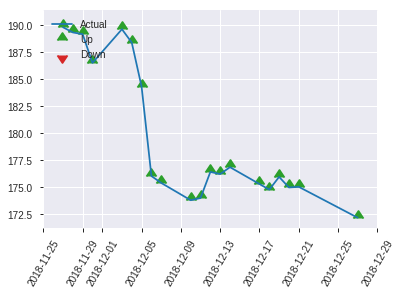


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27289371853790756
RMSE: 0.5223923032912215
LogLoss: 0.7674554692900716
Mean Per-Class Error: 0.4467878001297858
AUC: 0.5574302401038287
pr_auc: 0.5910558764950287
Gini: 0.11486048020765738
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44619401933384845: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   100  0.8696   (100.0/115.0)
1      5    129  0.0373   (5.0/134.0)
Total  20   229  0.4217   (105.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446194     0.710744  228
max f2                       0.124308     0.853503  248
max f0point5                 0.459321     0.616505  223
max accuracy                 0.459321     0.582329  223
max precision                0.965316     1         0
max recall                   0.124308     1         248
max specificity              0.965316     1         0
max absolute_mcc             0.459321     0.17299   223
max min_per_class_accuracy   0.661641     0.537313  121
max mean_per_class_accuracy  0.616605     0.553212  154

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 66.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.948632           1.85821   1.85821            1                0.956963  1                           0.956963            0.0223881       0.0223881                  85.8209   85.8209
    2        0.0200803                   0.937802           0.929104  1.48657            0.5              0.942448  0.8                         0.951157            0.00746269      0.0298507                  -7.08955  48.6567
    3        0.0321285                   0.930084           1.23881   1.39366            0.666667         0.934186  0.75                        0.944793            0.0149254       0.0447761                  23.8806   39.3657
    4        0.0401606                   0.927483           1.85821   1.48657            1                0.928237  0.8                         0.941482            0.0149254       0.0597015                  85.8209   48.6567
    5        0.0522088                   0.924085           0.619403  1.28645            0.333333         0.926429  0.692308                    0.938008            0.00746269      0.0671642                  -38.0597  28.6452
    6        0.100402                    0.896128           0.929104  1.11493            0.5              0.909632  0.6                         0.924388            0.0447761       0.11194                    -7.08955  11.4925
    7        0.15261                     0.851825           1.14351   1.12471            0.615385         0.871945  0.605263                    0.906447            0.0597015       0.171642                   14.3513   12.4705
    8        0.200803                    0.824166           1.23881   1.15209            0.666667         0.834482  0.62                        0.889175            0.0597015       0.231343                   23.8806   15.209
    9        0.301205                    0.742258           0.89194   1.06537            0.48             0.784714  0.573333                    0.854355            0.0895522       0.320896                   -10.806   6.53731
    10       0.401606                    0.698641           1.0406    1.05918            0.56             0.720456  0.57                        0.82088             0.104478        0.425373                   4.0597    5.91791
    11       0.502008                    0.657401           1.11493   1.07033            0.6              0.674471  0.576                       0.791598            0.11194         0.537313                   11.4925   7.03284
    12       0.598394                    0.622497           0.929104  1.04758            0.5              0.64029   0.563758                    0.767226            0.0895522       0.626866                   -7.08955  4.75809
    13       0.698795                    0.578174           0.89194   1.02522            0.48             0.601316  0.551724                    0.743389            0.0895522       0.716418                   -10.806   2.52187
    14       0.799197                    0.523924           1.0406    1.02715            0.56             0.550661  0.552764                    0.719177            0.104478        0.820896                   4.0597    2.71507
    15       0.899598                    0.459191           1.26358   1.05354            0.68             0.492617  0.566964                    0.693891            0.126866        0.947761                   26.3582   5.35381
    16       1                           0.124308           0.520299  1                  0.28             0.367446  0.538153                    0.661115          

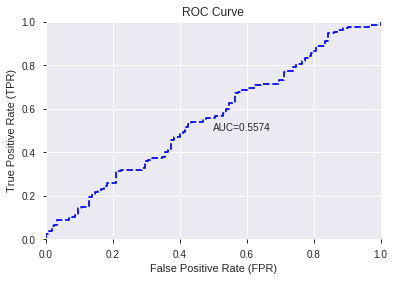

This function is available for GLM models only


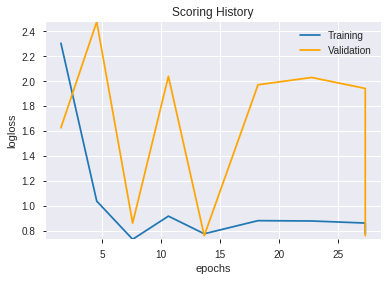

--2019-08-28 13:36:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190828_131919_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190828_131919_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'STOCHRSI_fastk',
 'CDLONNECK',
 'OBV',
 'aroondown_8',
 'CORREL_8',
 'aroondown_30',
 'CDL2CROWS',
 'CDLUPSIDEGAP2CROWS',
 'BETA_20',
 'CDLMORNINGDOJISTAR',
 'MFI_14',
 'CDLSPINNINGTOP',
 'HT_DCPERIOD',
 'aroonup_30',
 'HT_TRENDMODE',
 'AROONOSC_30',
 'CDLINNECK',
 'aroonup_12',
 'aroondown_14',
 'TRANGE',
 'aroonup_14',
 'BETA_12',
 'CDLSTICKSANDWICH',
 'aroonup_24',
 'aroondown_12',
 'BETA_24',
 'CDLPIERCING',
 'BETA_8',
 'HT_PHASOR_quadrature',
 'CORREL_24',
 'STOCHRSI_fastd',
 'CDLEVENINGDOJISTAR',
 'BETA_14',
 'CDLHIKKAKEMOD',
 'aroondown_24',
 'MFI_8',
 'CORREL_12',
 'HT_PHASOR_inphase',
 'MFI_12',
 'ADX_20',
 'DX_8',
 'aroonup_20',
 'CDLLONGLEGGEDDOJI',
 'ADXR_14',
 'DX_20',
 'STOCHF_fastd',
 'CDLSHORTLINE',
 'STDDEV_8',
 'aroondown_20',
 'ADXR_8',
 'CCI_20',
 'AROONOSC_8',
 'CORREL_20',
 'DX_12',
 'CDLHIKKAKE',
 'ADX_24',
 'CDLRICKSHAWMAN',
 'CCI_8',
 'STOCH_slowd',
 'PLUS_DI_30',
 'AROONOSC_14',
 'DX_14',
 'MFI_24',
 'DX_24',
 'CDLDOJI',
 'ULTOSC',
 'CDLLONGLINE',
 '

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190828_133644_model_1  0.581116  0.686651              0.470214  0.496736  0.246746

variable  relative_importance  scaled_importance    percentage
0          CDLCLOSINGMARUBOZU         2.337160e-02           1.000000  1.786481e-02
1          CDLMORNINGDOJISTAR         1.999855e-02           0.855677  1.528652e-02
2                   CDLONNECK         1.945822e-02           0.832559  1.487350e-02
3                 CDL3OUTSIDE         1.938719e-02           0.829519  1.481920e-02
4            CDLSTICKSANDWICH         1.838878e-02           0.786800  1.405604e-02
..                        ...                  ...                ...           ...
505  BBANDS_middleband_20_7_4         8.697955e-06           0.000372  6.648554e-06
506              LINEARREG_14         8.644368e-06           0.000370  6.607593e-06
507  BBANDS_middleband_24_6_3         1.832783e-06           0.000078  1.400945e-06
508  BBANDS_middleband_20_5_5         1.006641e-07           0.000004  7.694572e-08
509                 PLUS_DM_8         6.452396e-08           0.000003  4.932091e-08

[510 rows x 4 columns]

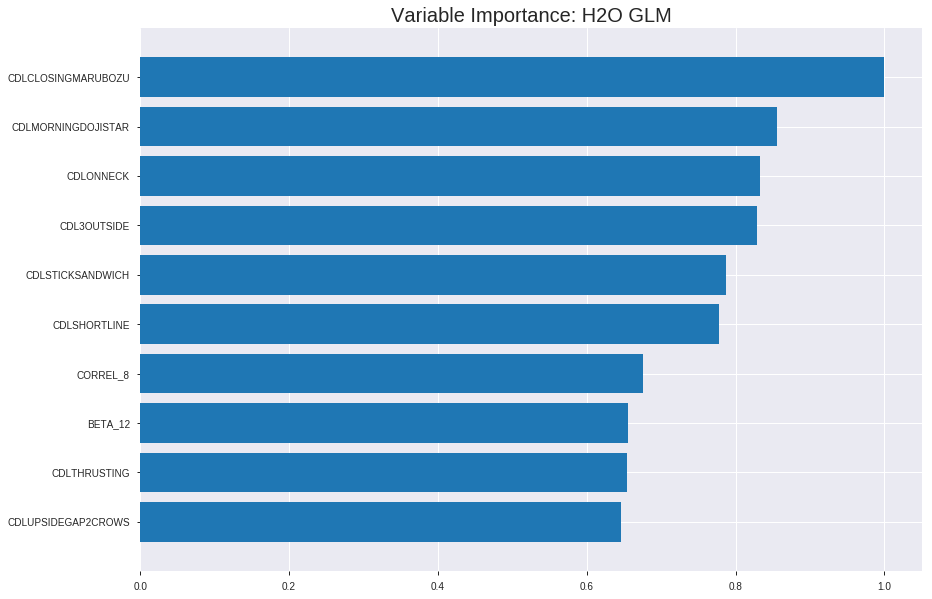

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190828_133644_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24498203655107226
RMSE: 0.4949566006743139
LogLoss: 0.6830445965553351
Null degrees of freedom: 1740
Residual degrees of freedom: 1230
Null deviance: 2409.7685981527216
Residual deviance: 2378.361285205677
AIC: 3400.361285205677
AUC: 0.5887135809979765
pr_auc: 0.5908888819004341
Gini: 0.1774271619959531
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47003505934889994: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      69   761   0.9169   (761.0/830.0)
1      22   889   0.0241   (22.0/911.0)
Total  91   1650  0.4497   (783.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.470035     0.69426   343
max f2                       0.439751     0.847158  379
max f0point5                 0.503356     0.603795  264
max accuracy                 0.51725      0.580701  220
max precision                0.676327     1         0
max recall                   0.358114     1         395
max specificity              0.676327     1         0
max absolute_mcc             0.51725      0.155232  220
max min_per_class_accuracy   0.525136     0.572289  192
max mean_per_class_accuracy  0.519723     0.576176  212

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 52.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.589627           1.38023   1.38023            0.722222         0.601182  0.722222                    0.601182            0.01427         0.01427                    38.0229   38.0229
    2        0.0201034                   0.584213           1.46142   1.41966            0.764706         0.586617  0.742857                    0.594108            0.01427         0.0285401                  46.1419   41.9664
    3        0.0304423                   0.579911           1.27406   1.37021            0.666667         0.581732  0.716981                    0.589905            0.0131723       0.0417124                  27.4058   37.0213
    4        0.0402068                   0.574648           1.12417   1.31046            0.588235         0.577259  0.685714                    0.586834            0.0109769       0.0526894                  12.4169   31.0459
    5        0.0505457                   0.571107           1.38023   1.32473            0.722222         0.572714  0.693182                    0.583946            0.01427         0.0669594                  38.0229   32.4731
    6        0.100517                    0.561321           1.09833   1.21218            0.574713         0.565861  0.634286                    0.574955            0.0548847       0.121844                   9.83257   21.2175
    7        0.150488                    0.55548            1.01046   1.14519            0.528736         0.558214  0.599237                    0.569396            0.050494        0.172338                   1.04596   14.5193
    8        0.20046                     0.550518           1.05439   1.12256            0.551724         0.553024  0.587393                    0.565315            0.0526894       0.225027                   5.43927   12.2558
    9        0.300402                    0.541207           1.09833   1.1145             0.574713         0.545554  0.583174                    0.55874             0.109769        0.334797                   9.83257   11.4496
    10       0.400345                    0.533113           1.15324   1.12417            0.603448         0.536854  0.588235                    0.553277            0.115258        0.450055                   15.3242   12.4169
    11       0.500287                    0.525434           1.18619   1.13656            0.62069          0.529295  0.594719                    0.548486            0.118551        0.568606                   18.6192   13.6559
    12       0.60023                     0.517534           1.03243   1.11922            0.54023          0.521536  0.585646                    0.543999            0.103183        0.671789                   3.24262   11.922
    13       0.700172                    0.50915            0.94456   1.09429            0.494253         0.513394  0.5726                      0.53963             0.0944018       0.766191                   -5.54399  9.42892
    14       0.800115                    0.499023           0.856694  1.06461            0.448276         0.504257  0.557071                    0.535212            0.0856202       0.851811                   -14.3306  6.46111
    15       0.900057                    0.481518           0.867677  1.04274            0.454023         0.49106   0.545629                    0.530309            0.0867179       0.938529                   -13.2323  4.27436
    16       1                           0.302682           0.615062  1                  0.321839         0.459802  0.523262                    0.523262          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2482678425852095
RMSE: 0.4982648317764455
LogLoss: 0.6896635847113508
Null degrees of freedom: 497
Residual degrees of freedom: -13
Null deviance: 689.5913742505304
Residual deviance: 686.9049303725054
AIC: 1708.9049303725055
AUC: 0.5348298088883863
pr_auc: 0.5386860012165887
Gini: 0.06965961777677254
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42620411194987445: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   223  0.9331   (223.0/239.0)
1      5    254  0.0193   (5.0/259.0)
Total  21   477  0.4578   (228.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426204     0.690217  378
max f2                       0.375335     0.844198  399
max f0point5                 0.468663     0.586243  326
max accuracy                 0.472581     0.550201  322
max precision                0.555574     0.608696  40
max recall                   0.375335     1         399
max specificity              0.596072     0.995816  0
max absolute_mcc             0.426204     0.118429  378
max min_per_class_accuracy   0.513553     0.528958  193
max mean_per_class_accuracy  0.472581     0.537196  322

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 50.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.584626           0.769112  0.769112           0.4              0.58856   0.4                         0.58856             0.00772201      0.00772201                 -23.0888   -23.0888
    2        0.0200803                   0.575221           0.769112  0.769112           0.4              0.579317  0.4                         0.583938            0.00772201      0.015444                   -23.0888   -23.0888
    3        0.0301205                   0.573544           1.15367   0.897297           0.6              0.574823  0.466667                    0.5809              0.011583        0.027027                   15.3668    -10.2703
    4        0.0401606                   0.568596           1.15367   0.96139            0.6              0.570865  0.5                         0.578391            0.011583        0.03861                    15.3668    -3.861
    5        0.0502008                   0.566336           1.15367   0.999846           0.6              0.567424  0.52                        0.576198            0.011583        0.0501931                  15.3668    -0.015444
    6        0.100402                    0.55363            1.30749   1.15367            0.68             0.559477  0.6                         0.567837            0.0656371       0.11583                    30.749     15.3668
    7        0.150602                    0.547057           0.846023  1.05112            0.44             0.550581  0.546667                    0.562085            0.042471        0.158301                   -15.3977   5.11197
    8        0.200803                    0.540963           1.15367   1.07676            0.6              0.544415  0.56                        0.557668            0.0579151       0.216216                   15.3668    7.67568
    9        0.301205                    0.530248           1.07676   1.07676            0.56             0.535691  0.56                        0.550342            0.108108        0.324324                   7.67568    7.67568
    10       0.399598                    0.522494           1.05949   1.07251            0.55102          0.525695  0.557789                    0.544273            0.104247        0.428571                   5.9491     7.25054
    11       0.5                         0.513357           0.999846  1.05792            0.52             0.518033  0.550201                    0.539004            0.100386        0.528958                   -0.015444  5.79151
    12       0.600402                    0.504913           0.807568  1.01605            0.42             0.509146  0.528428                    0.534011            0.0810811       0.610039                   -19.2432   1.60509
    13       0.698795                    0.494728           0.98101   1.01112            0.510204         0.500554  0.525862                    0.5293              0.0965251       0.706564                   -1.89898   1.1117
    14       0.799197                    0.479598           1.23058   1.03869            0.64             0.489189  0.540201                    0.524261            0.123552        0.830116                   23.0579    3.86876
    15       0.899598                    0.455449           0.922934  1.02577            0.48             0.466357  0.533482                    0.517798            0.0926641       0.92278                    -7.70656   2.57688
    16       1                           0.375335           0.769112  1                  0.4              0.426856  0.52008                  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-28 13:36:46  0.000 sec   2            2.2       511           1.37584           1.38077
    2019-08-28 13:36:46  0.595 sec   4            1.6       511           1.37389           1.38031
    2019-08-28 13:36:47  1.217 sec   6            1.2       511           1.37161           1.37988
    2019-08-28 13:36:48  1.811 sec   8            0.86      511           1.369             1.37954
    2019-08-28 13:36:48  2.402 sec   10           0.63      511           1.36609           1.37933
    2019-08-28 13:36:49  3.027 sec   12           0.46      511           1.36293           1.37936
    2019-08-28 13:36:49  3.701 sec   14           0.33      511           1.35961           1.37976
    2019-08-28 13:36:50  4.308 sec   16           0.24      511           1.35621           1.38065
    2019-08-28 13:36:51  4.898 sec   18           0.18      511           1.3528            1.38212
    2019-08-28 13:36:51  5.531 sec   20           0.13      511           1.34946           1.38426

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5783132530120482)

('F1', 0.7013698630136986)

('auc', 0.5811161583387411)

('logloss', 0.6866514400955119)

('mean_per_class_error', 0.43027255029201816)

('rmse', 0.496735676174377)

('mse', 0.24674633198441556)

glm prediction progress: |████████████████████████████████████████████████| 100%


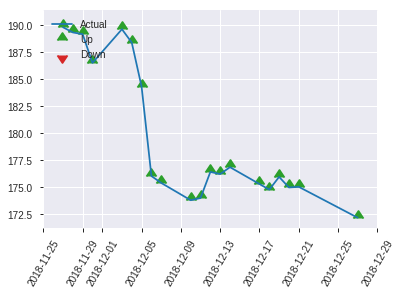


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24674633198441556
RMSE: 0.496735676174377
LogLoss: 0.6866514400955119
Null degrees of freedom: 248
Residual degrees of freedom: -262
Null deviance: 343.95763235704146
Residual deviance: 341.95241716756493
AIC: 1363.9524171675648
AUC: 0.5811161583387411
pr_auc: 0.6177839087415945
Gini: 0.16223231667748217
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47581437100207724: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   103  0.8957   (103.0/115.0)
1      6    128  0.0448   (6.0/134.0)
Total  18   231  0.4378   (109.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475814     0.70137   230
max f2                       0.365475     0.853503  248
max f0point5                 0.496819     0.611888  180
max accuracy                 0.498247     0.578313  172
max precision                0.581807     1         0
max recall                   0.365475     1         248
max specificity              0.581807     1         0
max absolute_mcc             0.542081     0.194395  29
max min_per_class_accuracy   0.514885     0.552239  124
max mean_per_class_accuracy  0.532792     0.569727  48

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 51.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.56495            1.23881   1.23881            0.666667         0.573749  0.666667                    0.573749            0.0149254       0.0149254                  23.8806   23.8806
    2        0.0200803                   0.558282           0.929104  1.11493            0.5              0.560709  0.6                         0.568533            0.00746269      0.0223881                  -7.08955  11.4925
    3        0.0321285                   0.553656           1.23881   1.16138            0.666667         0.556558  0.625                       0.564042            0.0149254       0.0373134                  23.8806   16.1381
    4        0.0401606                   0.549729           1.85821   1.30075            1                0.550909  0.7                         0.561416            0.0149254       0.0522388                  85.8209   30.0746
    5        0.0522088                   0.548195           1.85821   1.42939            1                0.548837  0.769231                    0.558513            0.0223881       0.0746269                  85.8209   42.9392
    6        0.100402                    0.543208           1.39366   1.41224            0.75             0.54554   0.76                        0.552286            0.0671642       0.141791                   39.3657   41.2239
    7        0.15261                     0.53614            1.28645   1.36921            0.692308         0.540747  0.736842                    0.548338            0.0671642       0.208955                   28.6452   36.9207
    8        0.200803                    0.5325             1.08396   1.30075            0.583333         0.533726  0.7                         0.544831            0.0522388       0.261194                   8.39552   30.0746
    9        0.301205                    0.526978           0.668955  1.09015            0.36             0.529769  0.586667                    0.539811            0.0671642       0.328358                   -33.1045  9.01493
    10       0.401606                    0.520489           1.0406    1.07776            0.56             0.523267  0.58                        0.535675            0.104478        0.432836                   4.0597    7.77612
    11       0.502008                    0.514885           1.18925   1.10006            0.64             0.518423  0.592                       0.532224            0.119403        0.552239                   18.9254   10.006
    12       0.598394                    0.507035           0.929104  1.07252            0.5              0.511018  0.577181                    0.528809            0.0895522       0.641791                   -7.08955  7.25233
    13       0.698795                    0.498234           1.11493   1.07862            0.6              0.503513  0.58046                     0.525174            0.11194         0.753731                   11.4925   7.86155
    14       0.799197                    0.491771           0.743284  1.03649            0.4              0.494938  0.557789                    0.521376            0.0746269       0.828358                   -25.6716  3.64884
    15       0.899598                    0.485319           0.966269  1.02865            0.52             0.488694  0.553571                    0.517728            0.0970149       0.925373                   -3.37313  2.86514
    16       1                           0.365475           0.743284  1                  0.4              0.465121  0.538153                    0.512446          

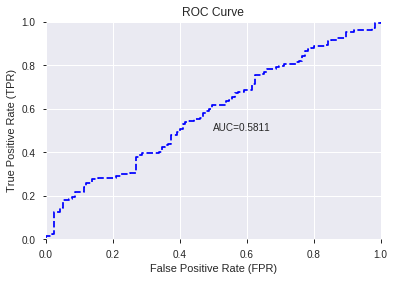

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


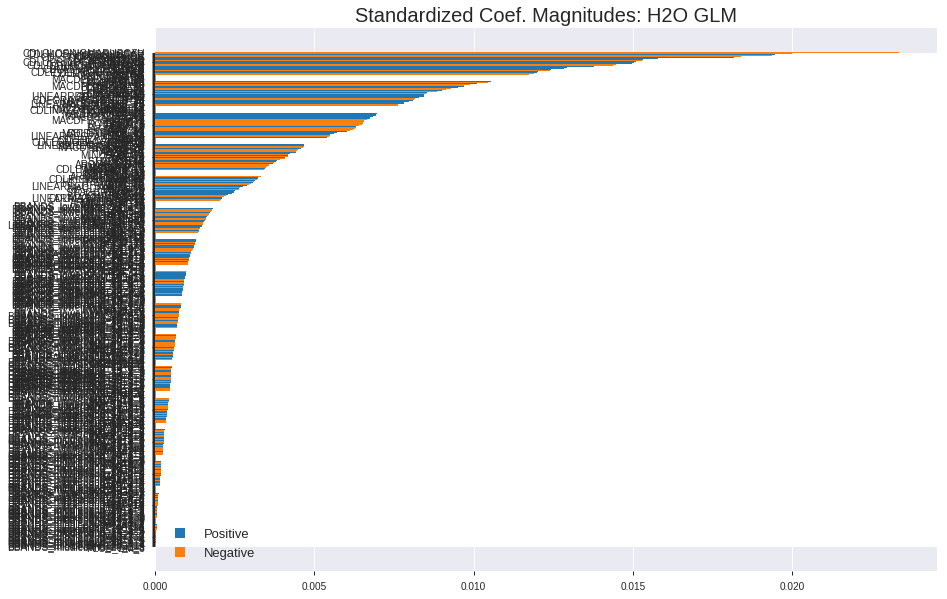

'log_likelihood'
--2019-08-28 13:37:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.137.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.137.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190828_133644_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190828_133644_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLCLOSINGMARUBOZU',
 'CDLMORNINGDOJISTAR',
 'CDLONNECK',
 'CDL3OUTSIDE',
 'CDLSTICKSANDWICH',
 'CDLSHORTLINE',
 'CORREL_8',
 'BETA_12',
 'CDLTHRUSTING',
 'CDLUPSIDEGAP2CROWS',
 'aroondown_8',
 'CDLTAKURI',
 'CDLDARKCLOUDCOVER',
 'CDLMORNINGSTAR',
 'CCI_20',
 'BETA_8',
 'CDLADVANCEBLOCK',
 'VAR_8',
 'CDL2CROWS',
 'CDLEVENINGDOJISTAR',
 'CDLEVENINGSTAR',
 'OBV',
 'CDLPIERCING',
 'CDLINNECK',
 'MFI_30',
 'DX_24',
 'MACDFIX_signal_24',
 'CCI_24',
 'CDLHAMMER',
 'WILLR_20',
 'CDLHIKKAKE',
 'PLUS_DI_30',
 'aroonup_12',
 'PLUS_DM_30',
 'MACDFIX_signal_20',
 'WILLR_30',
 'CDLHARAMI',
 'PLUS_DM_24',
 'DX_20',
 'STDDEV_8',
 'CORREL_14',
 'aroondown_12',
 'CDL3INSIDE',
 'LINEARREG_SLOPE_20',
 'PPO',
 'CDLDOJISTAR',
 'BETA_24',
 'PLUS_DM_20',
 'CDLGRAVESTONEDOJI',
 'MACDFIX_hist_20',
 'aroonup_14',
 'LINEARREG_ANGLE_20',
 'MACDFIX_hist_24',
 'ROCR100_12',
 'ROC_12',
 'ROCP_12',
 'aroondown_14',
 'MACDFIX_signal_14',
 'WILLR_14',
 'CDLINVERTEDHAMMER',
 'CORREL_24',
 'MACDFIX_hist_14',
 'aroondow

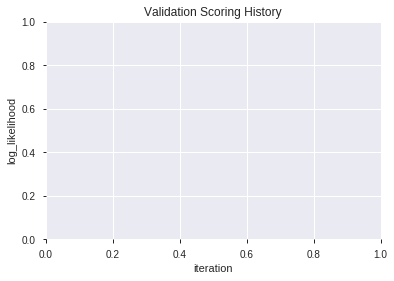

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190828_133716_model_3  0.607528  0.702412              0.423653  0.504535  0.254555
1  XGBoost_grid_1_AutoML_20190828_133716_model_1  0.572356  0.764695              0.478261  0.532701  0.283770
2  XGBoost_grid_1_AutoML_20190828_133716_model_4  0.564504  0.687512              0.491304  0.497181  0.247189
3  XGBoost_grid_1_AutoML_20190828_133716_model_5  0.564439  0.757716              0.486957  0.528707  0.279531
4               XGBoost_3_AutoML_20190828_133716  0.558858  0.734884              0.491304  0.519631  0.270017
5  XGBoost_grid_1_AutoML_20190828_133716_model_6  0.545101  0.757203              0.495036  0.529223  0.280077
6  XGBoost_grid_1_AutoML_20190828_133716_model_2  0.541856  0.691124              0.495652  0.498998  0.248999
7  XGBoost_grid_1_AutoML_20190828_133716_model_7  0.525633  0.729249              0.495652  0.516351  0.266618
8               XGBoost_1_AutoML_20190828_133716  0.518949  0.720795              0.500000  0.512731  0.262893
9               XGBoost_2_AutoML_20190828_133716  0.510578  0.713951              0.490688  0.509865  0.259962

variable  relative_importance  scaled_importance  percentage
0                    BETA_12            75.055977           1.000000    0.015437
1       HT_PHASOR_quadrature            74.506462           0.992679    0.015324
2                  CORREL_20            74.271675           0.989550    0.015275
3                     TRANGE            72.580330           0.967016    0.014928
4            MACDFIX_hist_14            70.075333           0.933641    0.014412
..                       ...                  ...                ...         ...
235  BBANDS_lowerband_20_5_5             1.391172           0.018535    0.000286
236                  NATR_20             1.361394           0.018138    0.000280
237                   CCI_12             1.342547           0.017887    0.000276
238  BBANDS_lowerband_24_1_4             0.866695           0.011547    0.000178
239  BBANDS_upperband_14_4_5             0.373646           0.004978    0.000077

[240 rows x 4 columns]

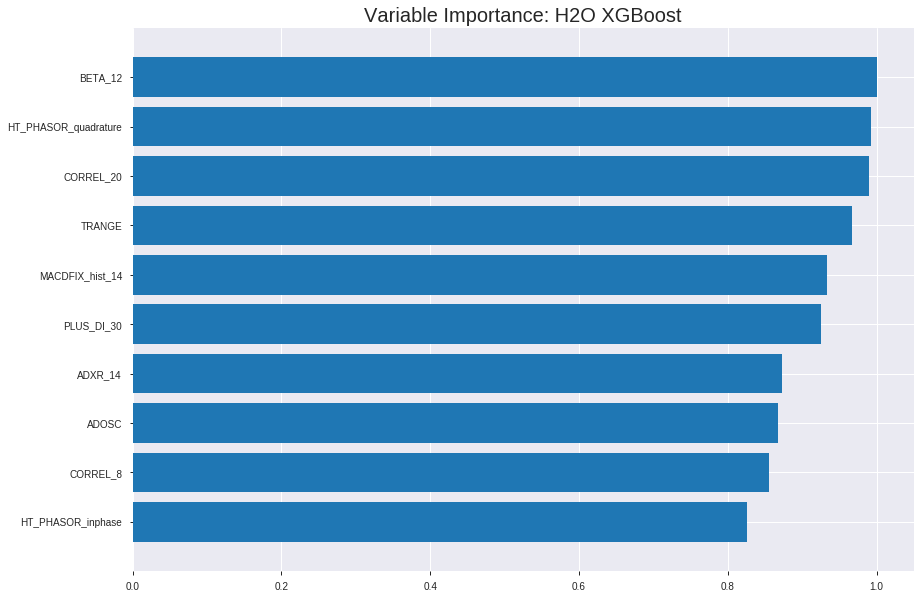

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190828_133716_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18853845706405833
RMSE: 0.4342101531102864
LogLoss: 0.5666703293280019
Mean Per-Class Error: 0.16575390475182838
AUC: 0.9140842183222462
pr_auc: 0.9180044445391923
Gini: 0.8281684366444924
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5048050085703532: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      637  193  0.2325   (193.0/830.0)
1      105  806  0.1153   (105.0/911.0)
Total  742  999  0.1712   (298.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504805     0.843979  216
max f2                       0.464655     0.902749  257
max f0point5                 0.532033     0.853571  187
max accuracy                 0.524893     0.833429  195
max precision                0.827469     1         0
max recall                   0.348501     1         355
max specificity              0.827469     1         0
max absolute_mcc             0.524893     0.667774  195
max min_per_class_accuracy   0.520461     0.829857  200
max mean_per_class_accuracy  0.524893     0.834246  195

Gains/Lift Table: Avg response rate: 52.33 %, avg score: 52.24 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.738388           1.91109    1.91109            1                0.761169  1                           0.761169            0.0197585       0.0197585                  91.1087   91.1087
    2        0.0201034                   0.717806           1.91109    1.91109            1                0.725553  1                           0.74387             0.0186608       0.0384193                  91.1087   91.1087
    3        0.0304423                   0.702176           1.91109    1.91109            1                0.707347  1                           0.731466            0.0197585       0.0581778                  91.1087   91.1087
    4        0.0402068                   0.691941           1.91109    1.91109            1                0.697152  1                           0.723132            0.0186608       0.0768386                  91.1087   91.1087
    5        0.0505457                   0.683559           1.91109    1.91109            1                0.688273  1                           0.716002            0.0197585       0.0965971                  91.1087   91.1087
    6        0.100517                    0.655752           1.84519    1.87833            0.965517         0.668994  0.982857                    0.692632            0.0922064       0.188804                   84.5187   87.8325
    7        0.150488                    0.63616            1.84519    1.86732            0.965517         0.645845  0.977099                    0.677096            0.0922064       0.28101                    84.5187   86.7321
    8        0.20046                     0.616199           1.82322    1.85633            0.954023         0.625341  0.971347                    0.664194            0.0911087       0.372119                   82.3221   85.6328
    9        0.300402                    0.583835           1.73535    1.81608            0.908046         0.601136  0.950287                    0.643215            0.173436        0.545554                   73.5355   81.608
    10       0.400345                    0.552245           1.41684    1.71641            0.741379         0.567255  0.898135                    0.624252            0.141603        0.687157                   41.684    71.6414
    11       0.500287                    0.523853           1.30701    1.63463            0.683908         0.537016  0.855339                    0.606825            0.130626        0.817783                   30.7008   63.4626
    12       0.60023                     0.495977           0.823744   1.49961            0.431034         0.510446  0.784689                    0.590777            0.0823271       0.90011                    -17.6256  49.9609
    13       0.700172                    0.466145           0.626046   1.37492            0.327586         0.481177  0.719442                    0.575133            0.0625686       0.962678                   -37.3954  37.4916
    14       0.800115                    0.431717           0.274581   1.23747            0.143678         0.450013  0.647523                    0.559504            0.0274424       0.990121                   -72.5419  23.7473
    15       0.900057                    0.387148           0.0768828  1.1086             0.0402299        0.411947  0.580089                    0.54312             0.00768386      0.997805                   -92.3117  10.8601
    16       1                           0.188592           0.0219665  1                  0.0114943        0.336128  0.523262                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2598384097677181
RMSE: 0.5097434744729138
LogLoss: 0.7140699199982578
Mean Per-Class Error: 0.4744834493788468
AUC: 0.5112356827837999
pr_auc: 0.5292642378742403
Gini: 0.022471365567599877
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2814156115055084: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   228  0.954    (228.0/239.0)
1      5    254  0.0193   (5.0/259.0)
Total  16   482  0.4679   (233.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.281416     0.68556    384
max f2                       0.206535     0.844198   399
max f0point5                 0.281416     0.580704   384
max accuracy                 0.37479      0.532129   319
max precision                0.729734     1          0
max recall                   0.206535     1          399
max specificity              0.729734     1          0
max absolute_mcc             0.281416     0.0757013  384
max min_per_class_accuracy   0.473936     0.498069   196
max mean_per_class_accuracy  0.494174     0.525517   167

Gains/Lift Table: Avg response rate: 52.01 %, avg score: 47.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0100402                   0.693137           1.15367   1.15367            0.6              0.713801  0.6                         0.713801            0.011583        0.011583                   15.3668    15.3668
    2        0.0200803                   0.669487           0.769112  0.96139            0.4              0.684295  0.5                         0.699048            0.00772201      0.019305                   -23.0888   -3.861
    3        0.0301205                   0.660412           1.15367   1.02548            0.6              0.663586  0.533333                    0.687227            0.011583        0.030888                   15.3668    2.54826
    4        0.0401606                   0.651393           1.15367   1.05753            0.6              0.656536  0.55                        0.679554            0.011583        0.042471                   15.3668    5.7529
    5        0.0502008                   0.639101           1.53822   1.15367            0.8              0.647468  0.6                         0.673137            0.015444        0.0579151                  53.8224    15.3668
    6        0.100402                    0.597395           0.999846  1.07676            0.52             0.616331  0.56                        0.644734            0.0501931       0.108108                   -0.015444  7.67568
    7        0.150602                    0.578479           0.769112  0.974208           0.4              0.587238  0.506667                    0.625569            0.03861         0.146718                   -23.0888   -2.57915
    8        0.200803                    0.564595           0.922934  0.96139            0.48             0.572499  0.5                         0.612301            0.046332        0.19305                    -7.70656   -3.861
    9        0.301205                    0.528939           1.15367   1.02548            0.6              0.544085  0.533333                    0.589563            0.11583         0.30888                    15.3668    2.54826
    10       0.399598                    0.503157           1.09873   1.04352            0.571429         0.515757  0.542714                    0.571389            0.108108        0.416988                   9.87314    4.35188
    11       0.5                         0.472763           0.807568  0.996139           0.42             0.485903  0.518072                    0.554223            0.0810811       0.498069                   -19.2432   -0.3861
    12       0.600402                    0.441442           0.999846  0.996759           0.52             0.45852   0.518395                    0.53822             0.100386        0.598456                   -0.015444  -0.324118
    13       0.698795                    0.410987           1.02025   1.00007            0.530612         0.425944  0.520115                    0.522411            0.100386        0.698842                   2.02506    0.0066569
    14       0.799197                    0.383549           1.11521   1.01453            0.58             0.397216  0.527638                    0.506683            0.111969        0.810811                   11.5212    1.45321
    15       0.899598                    0.339433           0.96139   1.0086             0.5              0.36483   0.524554                    0.490851            0.0965251       0.907336                   -3.861     0.860108
    16       1                           0.206535           0.922934  1                  0.48             0.295414  0.52008                  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-28 13:37:32  4.132 sec   0                  0.5              0.693147            0.5             0                  1                0.476738                         0.5                0.693147              0.5               0                    1                  0.47992
    2019-08-28 13:37:32  4.741 sec   5                  0.490449         0.674192            0.752336        0.758097           1.8105           0.322229                         0.500036           0.693224              0.526308          0.554412             1.53822            0.47992
    2019-08-28 13:37:33  4.947 sec   10                 0.484668         0.662813            0.774243        0.779397           1.80492          0.295233                         0.503959           0.701347              0.520105          0.548966             1.15367            0.47992
    2019-08-28 13:37:33  5.160 sec   15                 0.476829         0.647531            0.818558        0.825446           1.80492          0.289489                         0.503336           0.700099              0.52529           0.547257             1.28185            0.47992
    2019-08-28 13:37:33  5.375 sec   20                 0.469341         0.633071            0.846238        0.853386           1.80492          0.231476                         0.50546            0.704684              0.524975          0.549166             1.15367            0.47992
    2019-08-28 13:37:33  5.585 sec   25                 0.462573         0.620098            0.865626        0.870897           1.80492          0.223435                         0.505823           0.705461              0.520597          0.552086             1.53822            0.477912
    2019-08-28 13:37:33  5.791 sec   30                 0.455733         0.60708             0.881775        0.885682           1.91109          0.201034                         0.508333           0.710881              0.512221          0.545244             1.53822            0.47992
    2019-08-28 13:37:34  6.006 sec   35                 0.450608         0.597323            0.886659        0.889634           1.91109          0.192993                         0.507696           0.70943               0.511769          0.536108             1.15367            0.47992
    2019-08-28 13:37:34  6.227 sec   40                 0.445591         0.587826            0.892252        0.896794           1.91109          0.199885                         0.508859           0.712022              0.511777          0.537304             1.53822            0.467871
    2019-08-28 13:37:34  6.458 sec   45                 0.439771         0.576966            0.903414        0.90653            1.91109          0.186674                         0.509097           0.712651              0.513885          0.536224             1.53822            0.46988
    2019-08-28 13:37:34  6.679 sec   50                 0.43421          0.56667             0.914084        0.918004           1.91109          0.171166                         0.509743           0.71407               0.511236          0.529264             1.15367            0.467871

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BETA_12                  75.05597686767578      1.0                   0.01543672685556405
HT_PHASOR_quadrature     74.50646209716797      0.9926786007798338    0.015323708415601805
CORREL_20                74.27167510986328      0.9895504423425835    0.015275419888245044
TRANGE                   72.58032989501953      0.9670159915842435    0.01492756172704839
MACDFIX_hist_14          70.07533264160156      0.9336409379514822    0.014412360140329653
---                      ---                    ---                   ---
BBANDS_lowerband_20_5_5  1.391171932220459      0.018535125252890985  0.0002861216657625457
NATR_20                  1.361393928527832      0.018138381316760144  0.00027999723798889257
CCI_12                   1.3425474166870117     0.017887281902331808  0.0002761210849147702
BBANDS_lowerband_24_1_4  0.8666954040527344     0.011547320283109825  0.00017825282912408092
BBANDS_upperband_14_4_5  0.3736457824707031     0.0049782282246415    7.68475493284504e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.606425702811245)

('F1', 0.7130434782608696)

('auc', 0.6075275794938351)

('logloss', 0.702411903079031)

('mean_per_class_error', 0.39834523036988967)

('rmse', 0.5045348823650492)

('mse', 0.254555447523114)

xgboost prediction progress: |████████████████████████████████████████████| 100%


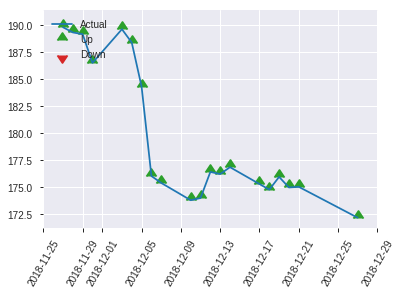


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.254555447523114
RMSE: 0.5045348823650492
LogLoss: 0.702411903079031
Mean Per-Class Error: 0.39834523036988967
AUC: 0.6075275794938351
pr_auc: 0.6044843078157477
Gini: 0.21505515898767014
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35824936628341675: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      27   88   0.7652   (88.0/115.0)
1      11   123  0.0821   (11.0/134.0)
Total  38   211  0.3976   (99.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.358249     0.713043  210
max f2                       0.29159      0.854592  247
max f0point5                 0.405734     0.633903  141
max accuracy                 0.405734     0.606426  141
max precision                0.630413     1         0
max recall                   0.29159      1         247
max specificity              0.630413     1         0
max absolute_mcc             0.358249     0.211684  210
max min_per_class_accuracy   0.415577     0.573913  125
max mean_per_class_accuracy  0.405734     0.601655  141

Gains/Lift Table: Avg response rate: 53.82 %, avg score: 42.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.589848           1.23881   1.23881            0.666667         0.609856  0.666667                    0.609856            0.0149254       0.0149254                  23.8806   23.8806
    2        0.0200803                   0.57995            0         0.743284           0                0.588251  0.4                         0.601214            0               0.0149254                  -100      -25.6716
    3        0.0321285                   0.574041           1.23881   0.929104           0.666667         0.577917  0.5                         0.592477            0.0149254       0.0298507                  23.8806   -7.08955
    4        0.0401606                   0.555937           0.929104  0.929104           0.5              0.563908  0.5                         0.586763            0.00746269      0.0373134                  -7.08955  -7.08955
    5        0.0522088                   0.550662           1.23881   1.00057            0.666667         0.553208  0.538462                    0.57902             0.0149254       0.0522388                  23.8806   0.0574053
    6        0.100402                    0.516602           1.39366   1.18925            0.75             0.530939  0.64                        0.555941            0.0671642       0.119403                   39.3657   18.9254
    7        0.15261                     0.492567           1.28645   1.22251            0.692308         0.505378  0.657895                    0.538643            0.0671642       0.186567                   28.6452   22.2506
    8        0.200803                    0.479013           1.08396   1.18925            0.583333         0.486784  0.64                        0.526197            0.0522388       0.238806                   8.39552   18.9254
    9        0.301205                    0.454644           1.33791   1.23881            0.72             0.467411  0.666667                    0.506602            0.134328        0.373134                   33.791    23.8806
    10       0.401606                    0.432094           0.966269  1.17067            0.52             0.441394  0.63                        0.4903              0.0970149       0.470149                   -3.37313  17.0672
    11       0.502008                    0.415805           0.966269  1.12979            0.52             0.422884  0.608                       0.476817            0.0970149       0.567164                   -3.37313  12.9791
    12       0.598394                    0.39973            1.23881   1.14735            0.666667         0.409134  0.61745                     0.465915            0.119403        0.686567                   23.8806   14.735
    13       0.698795                    0.382451           0.817612  1.09997            0.44             0.388855  0.591954                    0.454843            0.0820896       0.768657                   -18.2388  9.99743
    14       0.799197                    0.369638           0.89194   1.07384            0.48             0.375739  0.577889                    0.444905            0.0895522       0.858209                   -10.806   7.38393
    15       0.899598                    0.344073           0.817612  1.04524            0.44             0.357275  0.5625                      0.435125            0.0820896       0.940299                   -18.2388  4.52425
    16       1                           0.271776           0.594627  1                  0.32             0.325693  0.538153                    0.424138     

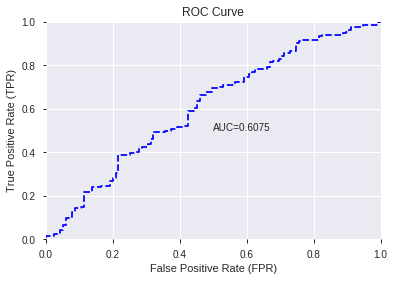

This function is available for GLM models only


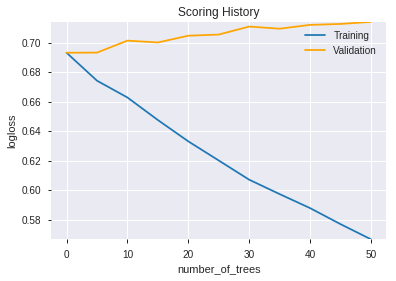

--2019-08-28 13:37:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190828_133716_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190828_133716_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a1a6',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BETA_12',
 'HT_PHASOR_quadrature',
 'CORREL_20',
 'TRANGE',
 'MACDFIX_hist_14',
 'PLUS_DI_30',
 'ADXR_14',
 'ADOSC',
 'CORREL_8',
 'HT_PHASOR_inphase',
 'STDDEV_20',
 'ULTOSC',
 'MACDEXT_signal',
 'DX_12',
 'BOP',
 'MFI_14',
 'MINUS_DM_30',
 'MOM_24',
 'STDDEV_14',
 'AD',
 'ATR_24',
 'HT_DCPERIOD',
 'ADX_24',
 'ROC_12',
 'MFI_30',
 'STOCHRSI_fastd',
 'ADX_8',
 'BETA_8',
 'ADX_12',
 'CCI_8',
 'LINEARREG_ANGLE_20',
 'MFI_8',
 'PLUS_DM_24',
 'CCI_24',
 'STDDEV_8',
 'MINUS_DI_14',
 'ATR_12',
 'MINUS_DI_30',
 'MACDFIX_hist_12',
 'CORREL_24',
 'WILLR_8',
 'LINEARREG_ANGLE_8',
 'CORREL_12',
 'MOM_8',
 'ROC_14',
 'CORREL_14',
 'STOCHF_fastd',
 'OBV',
 'PLUS_DM_12',
 'CDL3OUTSIDE',
 'AROONOSC_24',
 'MINUS_DI_20',
 'MACDFIX_signal_12',
 'BBANDS_lowerband_24_7_5',
 'VAR_20',
 'DX_8',
 'MOM_14',
 'CMO_14',
 'MINUS_DM_24',
 'MINUS_DI_12',
 'MOM_20',
 'PLUS_DI_8',
 'ADX_14',
 'WILLR_20',
 'CCI_20',
 'PLUS_DI_12',
 'CCI_14',
 'ROC_30',
 'MFI_12',
 'LINEARREG_ANGLE_12',
 'BETA_24',
 'BETA_14',
 'VAR

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.582
GLM             0.578
XGBoost         0.606
dtype: float64

DeepLearning    GLM  XGBoost
All          0.538  0.538    0.606
DLF          0.538  0.538    0.590
Fwe          0.538  0.538    0.606
RFE          0.582  0.578    0.606
XGBF         0.538  0.538    0.590





F1


DeepLearning    0.711
GLM             0.701
XGBoost         0.713
dtype: float64

DeepLearning    GLM  XGBoost
All          0.700  0.700    0.712
DLF          0.700  0.700    0.704
Fwe          0.700  0.700    0.712
RFE          0.711  0.701    0.713
XGBF         0.700  0.700    0.704





auc


DeepLearning    0.557
GLM             0.581
XGBoost         0.608
dtype: float64

DeepLearning    GLM  XGBoost
All          0.529  0.529    0.571
DLF          0.529  0.526    0.578
Fwe          0.522  0.529    0.571
RFE          0.557  0.581    0.608
XGBF         0.526  0.526    0.578





logloss


DeepLearning    18.315
GLM             18.160
XGBoost          0.817
dtype: float64

DeepLearning     GLM  XGBoost
All         18.006  18.136    0.817
DLF         18.065  18.160    0.777
Fwe         18.315  18.136    0.817
RFE          0.767   0.687    0.702
XGBF        18.158  18.160    0.777





mean_per_class_error


DeepLearning    0.478
GLM             0.474
XGBoost         0.416
dtype: float64

DeepLearning    GLM  XGBoost
All          0.467  0.471    0.416
DLF          0.467  0.474    0.415
Fwe          0.478  0.471    0.416
RFE          0.447  0.430    0.398
XGBF         0.474  0.474    0.415





rmse


DeepLearning    0.734
GLM             0.734
XGBoost         0.552
dtype: float64

DeepLearning    GLM  XGBoost
All          0.733  0.734    0.552
DLF          0.733  0.734    0.538
Fwe          0.734  0.734    0.552
RFE          0.522  0.497    0.505
XGBF         0.734  0.734    0.538





mse


DeepLearning    0.538
GLM             0.538
XGBoost         0.305
dtype: float64

DeepLearning    GLM  XGBoost
All          0.538  0.538    0.305
DLF          0.538  0.538    0.289
Fwe          0.538  0.538    0.305
RFE          0.273  0.247    0.255
XGBF         0.538  0.538    0.289

{'F1':       DeepLearning    GLM  XGBoost
 All          0.700    NaN      NaN
 DLF          0.700    NaN      NaN
 DLF            NaN  0.700      NaN
 DLF            NaN    NaN    0.704
 All            NaN  0.700      NaN
 All            NaN    NaN    0.712
 XGBF         0.700    NaN      NaN
 XGBF           NaN  0.700      NaN
 XGBF           NaN    NaN    0.704
 Fwe          0.700    NaN      NaN
 Fwe            NaN  0.700      NaN
 Fwe            NaN    NaN    0.712
 RFE          0.711    NaN      NaN
 RFE            NaN  0.701      NaN
 RFE            NaN    NaN    0.713,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.538    NaN      NaN
 DLF          0.538    NaN      NaN
 DLF            NaN  0.538      NaN
 DLF            NaN    NaN    0.590
 All            NaN  0.538      NaN
 All            NaN    NaN    0.606
 XGBF         0.538    NaN      NaN
 XGBF           NaN  0.538      NaN
 XGBF           NaN    NaN    0.590
 Fwe          0.538    NaN      NaN
 Fwe     